In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cv2 as cv
import open3d as o3d
import os

dataset = 21
  
with np.load("../data/Encoders%d.npz"%dataset) as data:
    encoder_counts = data["counts"] # 4 x n encoder counts
    encoder_stamps = data["time_stamps"] # encoder time stamps

with np.load("../data/Hokuyo%d.npz"%dataset) as data:
    lidar_angle_min = data["angle_min"] # start angle of the scan [rad]
    lidar_angle_max = data["angle_max"] # end angle of the scan [rad]
    lidar_angle_increment = data["angle_increment"] # angular distance between measurements [rad]
    lidar_range_min = data["range_min"] # minimum range value [m]
    lidar_range_max = data["range_max"] # maximum range value [m]
    lidar_ranges = data["ranges"]       # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamps = data["time_stamps"]  # acquisition times of the lidar scans

with np.load("../data/Imu%d.npz"%dataset) as data:
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements

with np.load("../data/Kinect%d.npz"%dataset) as data:
    disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images
    rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images

In [2]:
print("Shapes of data or value")
print("encoder counts: " + str(encoder_counts.shape))
print("encoder stamps: " + str(encoder_stamps.shape))
print("lidar_angle_min: " + str(lidar_angle_min))
print("lidar_angle_max: " + str(lidar_angle_max))
print("lidar_angle_increment: " + str(lidar_angle_increment))
print("lidar_range_min: " + str(lidar_range_min))
print("lidar_range_max: " + str(lidar_range_max))
print("lidar_ranges: " + str(lidar_ranges.shape))
print("lidar_stamps: " + str(lidar_stamps.shape))
print("imu_angular_velocity: " + str(imu_angular_velocity.shape))
print("imu_linear_acceleration: " + str(imu_linear_acceleration.shape))
print("imu_stamps: " + str(imu_stamps.shape))
print("disp_stamps: " + str(disp_stamps.shape))
print("rgb_stamps: " + str(rgb_stamps.shape))

Shapes of data or value
encoder counts: (4, 4789)
encoder stamps: (4789,)
lidar_angle_min: -2.356194490192345
lidar_angle_max: 2.356194490192345
lidar_angle_increment: [[0.00436332]]
lidar_range_min: 0.1
lidar_range_max: 30
lidar_ranges: (1081, 4785)
lidar_stamps: (4785,)
imu_angular_velocity: (3, 11730)
imu_linear_acceleration: (3, 11730)
imu_stamps: (11730,)
disp_stamps: (2188,)
rgb_stamps: (2112,)


(4789,)


/tmp/ipykernel_103576/2162649510.py:10: RuntimeWarning: invalid value encountered in divide
  V_r = D_r/e_int #Assuming there is an initial velocity
/tmp/ipykernel_103576/2162649510.py:14: RuntimeWarning: invalid value encountered in divide
  V_l = D_l/e_int


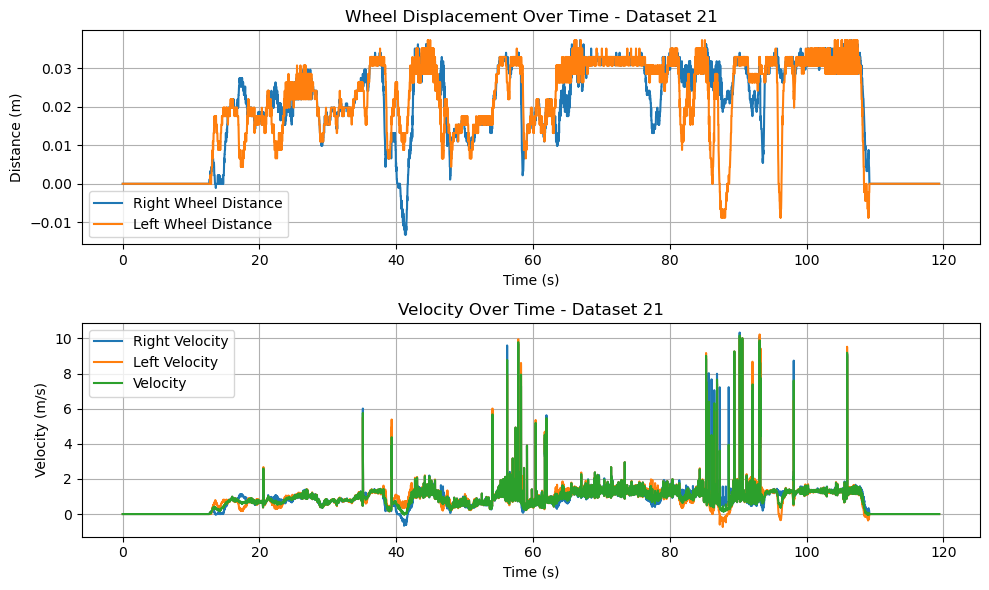

In [3]:
#Part 1 ENCODER AND IMU ODOMETRY
FR, FL, RR, RL = encoder_counts
e_time = encoder_stamps - encoder_stamps[0]
e_int = e_time[1:] - e_time[:-1]
e_int = np.insert(e_int,0,0)

print(e_int.shape)

D_r = ((FR+RR)/2)*0.0022
V_r = D_r/e_int #Assuming there is an initial velocity
V_r[0] = 0

D_l = ((RL+RL)/2)*0.0022
V_l = D_l/e_int
V_l[0] = 0

v = (V_r+V_l)/2

fig,ax = plt.subplots(2,1,figsize=(10,6))

ax[0].plot(e_time,D_r,label = "Right Wheel Distance")
ax[0].plot(e_time,D_l,label = "Left Wheel Distance")
ax[0].set_ylabel("Distance (m)")
ax[0].set_xlabel("Time (s)")
ax[0].set_title("Wheel Displacement Over Time - Dataset " + str(dataset))
ax[0].legend()
ax[0].grid()

ax[1].plot(e_time,V_r,label = "Right Velocity")
ax[1].plot(e_time,V_l,label = "Left Velocity")
ax[1].plot(e_time,v,label = "Velocity")
ax[1].set_ylabel("Velocity (m/s)")
ax[1].set_xlabel("Time (s)")
ax[1].set_title("Velocity Over Time - Dataset " + str(dataset))
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

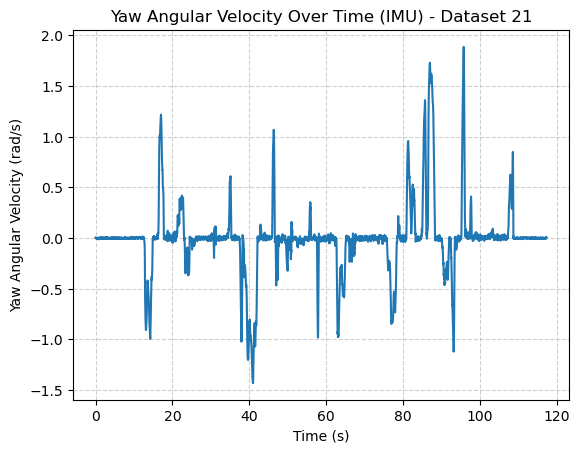

In [4]:
imu_time = imu_stamps - imu_stamps[0]
yaw_ang_velocity = imu_angular_velocity[2]

plt.plot(imu_time, yaw_ang_velocity, label="Yaw Angular Velocity")
plt.xlabel("Time (s)")
plt.ylabel("Yaw Angular Velocity (rad/s)")
plt.title("Yaw Angular Velocity Over Time (IMU) - Dataset " + str(dataset))
plt.grid(True, linestyle="--", alpha=0.6)


[[ 1. -0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


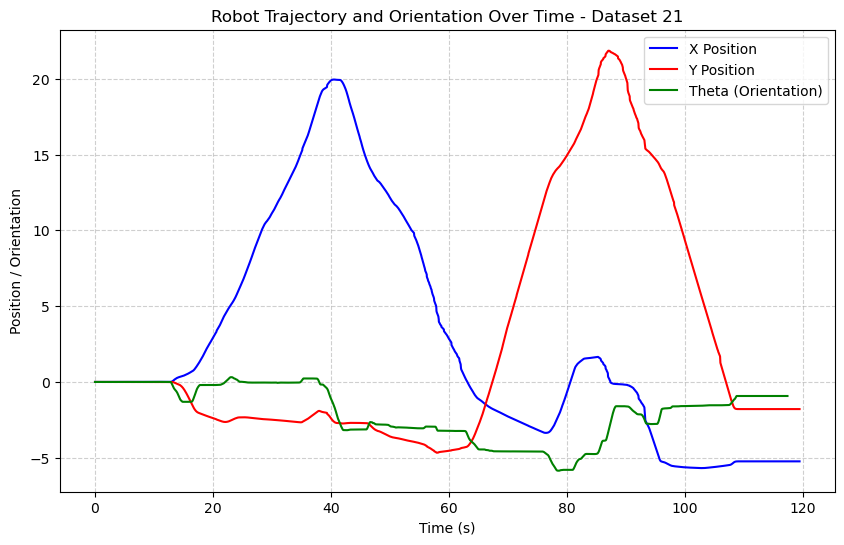

In [5]:
n = e_time.shape[0]
m = imu_time.shape[0]

x_odo = np.zeros(n)
y_odo = np.zeros(n)
theta = np.zeros(n)

indices = np.searchsorted(imu_time,e_time,side="left")
indices = np.clip(indices,0,len(imu_time)-1)

imu_sync = imu_time[indices]
imu_int = imu_sync[1:] - imu_sync[:-1]

omega_sync = yaw_ang_velocity[indices]

# calculating pose
for i in range(1,n):
    theta[i] = theta[i-1] + omega_sync[i-1]*imu_int[i-1] #assuming pose is 0 at start

    if omega_sync[i-1] * imu_int[i-1] == 0:
        inner = 1  
    else:
        inner = np.sin(omega_sync[i-1] * imu_int[i-1] / 2) / (omega_sync[i-1] * imu_int[i-1] / 2)

    x_odo[i] = x_odo[i-1] + v[i-1] * e_int[i] * inner * np.cos(theta[i-1] + (omega_sync[i-1] * e_int[i] / 2))
    y_odo[i] = y_odo[i-1] + v[i-1] * e_int[i] * inner * np.sin(theta[i-1] + (omega_sync[i-1] * e_int[i] / 2))

T_odo = np.zeros((3,3,n))
for i in range(n):
    T_odo[:,:,i] = np.array([
        [np.cos(theta[i]), -np.sin(theta[i]), x_odo[i]],
        [np.sin(theta[i]),  np.cos(theta[i]), y_odo[i]],
        [0, 0, 1]
    ])

print(T_odo[:,:,0])

plt.figure(figsize=(10, 6))  
plt.plot(e_time, x_odo, label="X Position", color="blue")
plt.plot(e_time, y_odo, label="Y Position", color="red")
plt.plot(imu_sync, theta, label="Theta (Orientation)", color="green")

plt.xlabel("Time (s)")
plt.ylabel("Position / Orientation")
plt.title("Robot Trajectory and Orientation Over Time - Dataset " + str(dataset))

plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)  

plt.show()


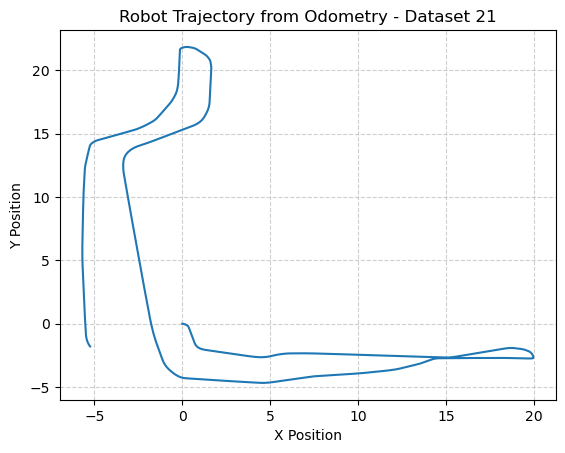

In [6]:
#Generating Robot trajectory
plt.plot(x_odo,y_odo)
plt.title("Robot Trajectory from Odometry - Dataset " + str(dataset))
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid(True, linestyle="--", alpha=0.6)


In [7]:
def sample_points(pc, num_samples=1500):
    """Downsample point cloud by selecting equally spaced points."""
    N = pc.shape[0]
    if N <= num_samples:
        return pc  # If already small, keep it as is
    indices = np.round(np.linspace(0, N - 1, num_samples)).astype(int)
    return pc[indices]

In [8]:
def disc_yaw(source_pc,target_pc,yaw_steps = 40):
    """Find the best yaw rotation by testing different angles and selecting the lowest ICP error."""
    best_angle = 0
    best_error = float('inf')
    best_transformed_pc = source_pc  

    # Discretize yaw angles from -π to π
    yaw_angles = np.linspace(-np.pi, np.pi, yaw_steps)

    target_avg = np.mean(target_pc,axis=0)
    t_align = target_pc-target_avg

    print(t_align)

    source_avg = np.mean(source_pc,axis=0)
    s_align = source_pc-source_avg

    print(s_align)

    for angle in yaw_angles:
        R = np.array([[np.cos(angle), -np.sin(angle), 0],
                  [np.sin(angle),  np.cos(angle), 0],
                  [0,             0,             1]])
        rotated_pc = (R @ s_align.T).T

        tree = scipy.spatial.KDTree(t_align)
        distances, _ = tree.query(rotated_pc)
        error = np.mean(distances**2)

        if error < best_error:
            best_error = error
            best_angle = angle
            best_transformed_pc = rotated_pc

    best_transformed_pc += target_avg 
    print(f"Best yaw angle: {np.degrees(best_angle):.2f}° with error: {best_error:.5f}")

    return best_transformed_pc, best_angle

In [9]:
def icp(source, target, T_odo=None, max_iter=50):
    '''
    Perform  ICP  to align a source point cloud to a target point cloud
    source: (N,2)
    target: (M,2)
    '''
    error = float('inf')

    if T_odo is None:
        T_odo = np.eye(3)

    source_h = np.hstack((source, np.ones((source.shape[0], 1))))  # (N,3) creating homogeneous points for transformation
    source_h = (T_odo @ source_h.T).T  # Apply initial transformation
    source = source_h[:, :2] 

    pose = T_odo.copy()

    for i in range(max_iter):
        tree = scipy.spatial.KDTree(target)
        dist, idx = tree.query(source)

        # matched_target = target[idx]
        idx = np.clip(idx, 0, target.shape[0] - 1)  # Prevent out-of-bounds indexing
        matched_target = target[idx]


        source_avg = np.mean(source,axis=0)
        target_avg = np.mean(matched_target,axis=0)

        s_align = source-source_avg
        t_align = matched_target-target_avg

        H = s_align.T@t_align

        U,S,Vt = np.linalg.svd(H)

        R = Vt.T @ U.T

        if np.linalg.det(R) < 0:
            Vt[-1, :] *= -1
            R = Vt.T @ U.T

        t = target_avg - R @ source_avg

        T = np.eye(3)
        T[:2,:2] = R
        T[:2,2] = t

        source = (R @ source.T).T + t
        error = np.mean(dist)

        pose = T @ pose

    return pose

In [10]:
# Scan Matching
# lidar data (1081,N) shape, takes 1081 values per scan, starting at -135 going to 135 degrees step angle 0.25 degrees
# N = 4962
# Given orientation and position from part 1, now match two robot frames knowing this

'''
e_time: odometry data time (4956,)
l_time: lidar data time (4962,)
T_odo: odometry trajectory (3,3,4956)
pc: point cloud in 2d (2,1081,4962)
lt_sync: lidar data time synced to odometry (4956,)
pc_sync: point cloud in 2d synced to odometry (2,1081,4956)
robot_T_lidar: lidar to robot frame (3,3)
T_icp: ICP trajectory (3,3,4956) 
'''
T_odo = T_odo
l_time = lidar_stamps-lidar_stamps[0]

#filtering out values
valid_mask = (lidar_ranges >= lidar_range_min) & (lidar_ranges <= lidar_range_max)
filtered_lidar_ranges = np.where(valid_mask, lidar_ranges, np.nan)  # Use NaN for ignored values

r = filtered_lidar_ranges #(1081,4962) shape
theta = np.radians(np.linspace(-135,135,r.shape[0])).reshape(-1,1)

x_sensor = r * np.cos(theta)
y_sensor = r * np.sin(theta)
pc = np.array([x_sensor,y_sensor]) #(2, 1081, 4962)

# syncing lidar data with odometry data
indices = np.searchsorted(l_time,e_time,side="left")
indices = np.clip(indices,0,len(l_time)-1)

l_orig_dist = (298.33-(330.2/2))/1000 #in meters

lt_sync = l_time[indices]
pc_sync = pc[:,:,indices]    

robot_T_lidar = np.array([
    [1,0,l_orig_dist],
    [0,1,0],
    [0,0,1]
])

T_icp_lidar = np.zeros((3,3,e_time.shape[0]))
T_icp_lidar[:,:,0] = np.eye(3)

for i in range(1,e_time.shape[0]): #for every scan
    T_delta = np.linalg.inv(T_odo[:,:,i-1]) @ T_odo[:,:,i] # getting relative pose change for initial icp check
    T_transformed = np.linalg.inv(robot_T_lidar)@T_delta@robot_T_lidar # expressing in lidar frame

    target_pc = pc_sync[:,:,i-1].T
    source_pc = pc_sync[:,:,i].T
    
    valid_source = ~np.isnan(source_pc).any(axis=1)
    valid_target = ~np.isnan(target_pc).any(axis=1)
    
    source_pc = source_pc[valid_source]
    target_pc = target_pc[valid_target]

    T_delta_icp = icp(source_pc,target_pc,T_transformed)
    
    T_icp_lidar[:,:,i] = T_icp_lidar[:,:,i-1]@T_delta_icp

T_icp = np.zeros((3,3,e_time.shape[0]))
for i in range(e_time.shape[0]):
    T_icp[:,:,i] = T_icp_lidar[:,:,i] @ np.linalg.inv(robot_T_lidar)


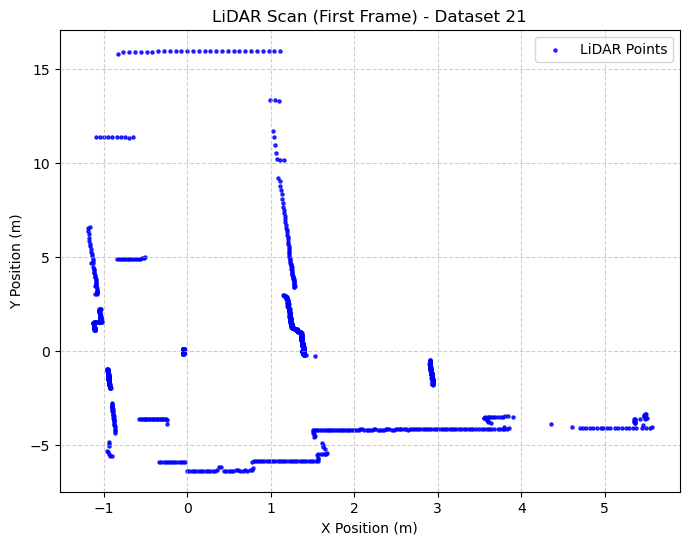

In [11]:
plt.figure(figsize=(8, 6))

# Scatter the LiDAR points from pc_sync for the first scan (index 0)
plt.scatter(pc_sync[0, :, 0], pc_sync[1, :, 0],
            c='blue', marker='o', s=5, alpha=0.8, label="LiDAR Points")

# Make it "pretty"
plt.title("LiDAR Scan (First Frame) - Dataset " + str(dataset))
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="best")

plt.show()


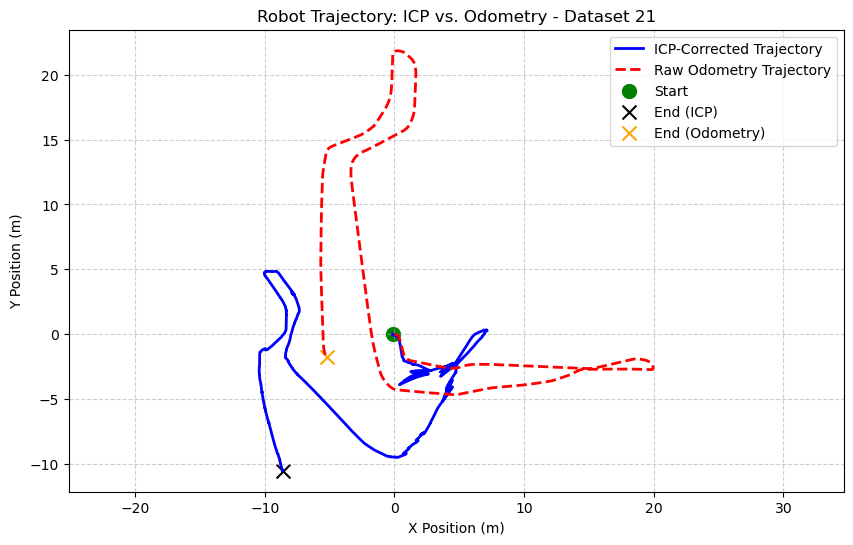

In [12]:
def plot_trajectory(T_icp, T_odo):
    x_icp = T_icp[0, 2, :] 
    y_icp = T_icp[1, 2, :] 

    x_odo = T_odo[0, 2, :] 
    y_odo = T_odo[1, 2, :] 

    plt.figure(figsize=(10, 6))
    plt.plot(x_icp, y_icp, label="ICP-Corrected Trajectory", color='blue', linewidth=2)
    plt.plot(x_odo, y_odo, label="Raw Odometry Trajectory", color='red', linestyle='dashed', linewidth=2)
    
    plt.scatter(x_icp[0], y_icp[0], color='green', marker='o', label="Start", s=100)
    plt.scatter(x_icp[-1], y_icp[-1], color='black', marker='x', label="End (ICP)", s=100)
    plt.scatter(x_odo[-1], y_odo[-1], color='orange', marker='x', label="End (Odometry)", s=100)

    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.title("Robot Trajectory: ICP vs. Odometry - Dataset " + str(dataset))
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.axis("equal")  # Keep aspect ratio correct

    plt.show()

# Call function with ICP and Odometry data
plot_trajectory(T_icp, T_odo)



In [13]:
def bresenham(x0, y0, x1, y1):
    """Generate points along a line using Bresenham’s algorithm."""
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    
    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    
    return points

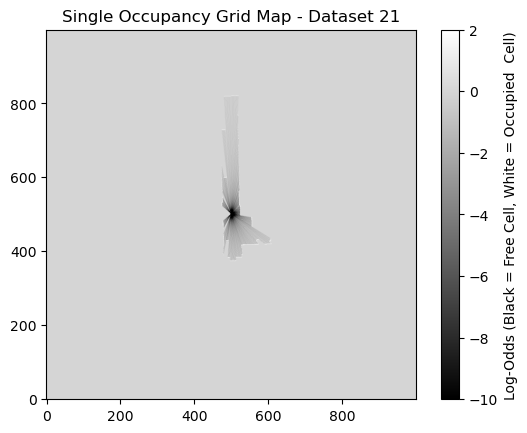

In [14]:
#Part 3 Occupancy and texture mapping

#creating the occupancy grid
grid_size = 1000
resolution = 0.05 #5cm per cell

occupancy_grid_first = np.zeros((grid_size, grid_size), dtype=np.float32) #storing the log odds

#tranforming the lidar sensor points to world coordinates
ff = pc_sync[:,:,0]
ff_homo = np.vstack((ff,np.ones(ff.shape[1])))
ff_trans = T_icp[:,:,0]@ff_homo
ff_trans = np.where(np.isfinite(ff_trans), ff_trans, np.nan)
ff_trans = ff_trans[:, ~np.isnan(ff_trans).any(axis=0)]

robot_origin = np.array([grid_size//2,grid_size//2])
robot_pos = (grid_size//2,grid_size//2)

x_world = ff_trans[0,:]
y_world = ff_trans[1,:]

x_grid = np.round(x_world/resolution + grid_size/2).astype(int)
y_grid = np.round(y_world/resolution + grid_size/2).astype(int)

l_occupied = +2
l_free = -0.5
l_max = 10
l_min = -10

occupancy_grid_first[y_grid, x_grid] = np.clip(occupancy_grid_first[y_grid, x_grid] + l_occupied, l_min, l_max)

for x_end, y_end in zip(x_grid, y_grid):
    free_cells = bresenham(robot_origin[0], robot_origin[1], x_end, y_end)
    
    for x, y in free_cells[:-1]:  # exclude the last point (occupied cell)
        if 0 <= x < grid_size and 0 <= y < grid_size:
            occupancy_grid_first[y, x] = np.clip(occupancy_grid_first[y, x] + l_free, l_min, l_max)

# Display occupancy grid
plt.imshow(occupancy_grid_first, cmap="gray", origin='lower')  # Inverted grayscale
plt.colorbar(label="Log-Odds (Black = Free Cell, White = Occupied  Cell)")
plt.title("Single Occupancy Grid Map - Dataset " + str(dataset))
plt.show()


Iteration: 0
Iteration 0: World Position: [-0.13323  0.     ] -> Grid Position: (497, 500)
Iteration: 1
Iteration 1: World Position: [-0.13373012  0.00074726] -> Grid Position: (497, 500)
Iteration: 2
Iteration 2: World Position: [-0.13358133  0.00029428] -> Grid Position: (497, 500)
Iteration: 3
Iteration 3: World Position: [-0.13358133  0.00029428] -> Grid Position: (497, 500)
Iteration: 4
Iteration 4: World Position: [-0.13347629 -0.0003027 ] -> Grid Position: (497, 500)
Iteration: 5
Iteration 5: World Position: [-0.13327751 -0.00061299] -> Grid Position: (497, 500)
Iteration: 6
Iteration 6: World Position: [-0.13327751 -0.00061299] -> Grid Position: (497, 500)
Iteration: 7
Iteration 7: World Position: [-0.13326169 -0.00084293] -> Grid Position: (497, 500)
Iteration: 8
Iteration 8: World Position: [-0.133269   -0.00111826] -> Grid Position: (497, 500)
Iteration: 9
Iteration 9: World Position: [-0.13357976 -0.00176699] -> Grid Position: (497, 500)
Iteration: 10
Iteration 10: World Po

Iteration: 90
Iteration 90: World Position: [-0.13208808 -0.012968  ] -> Grid Position: (497, 500)
Iteration: 91
Iteration 91: World Position: [-0.13188514 -0.01309672] -> Grid Position: (497, 500)
Iteration: 92
Iteration 92: World Position: [-0.13201124 -0.01173122] -> Grid Position: (497, 500)
Iteration: 93
Iteration 93: World Position: [-0.13214843 -0.01152664] -> Grid Position: (497, 500)
Iteration: 94
Iteration 94: World Position: [-0.13184109 -0.01213067] -> Grid Position: (497, 500)
Iteration: 95
Iteration 95: World Position: [-0.13182055 -0.01267917] -> Grid Position: (497, 500)
Iteration: 96
Iteration 96: World Position: [-0.1320659  -0.01235424] -> Grid Position: (497, 500)
Iteration: 97
Iteration 97: World Position: [-0.13145973 -0.01321996] -> Grid Position: (497, 500)
Iteration: 98
Iteration 98: World Position: [-0.13145973 -0.01321996] -> Grid Position: (497, 500)
Iteration: 99
Iteration 99: World Position: [-0.13173146 -0.01314296] -> Grid Position: (497, 500)
Iteration:

Iteration: 174
Iteration 174: World Position: [-0.13080556 -0.02122764] -> Grid Position: (497, 500)
Iteration: 175
Iteration 175: World Position: [-0.13071356 -0.02067381] -> Grid Position: (497, 500)
Iteration: 176
Iteration 176: World Position: [-0.1306208  -0.02050955] -> Grid Position: (497, 500)
Iteration: 177
Iteration 177: World Position: [-0.13090867 -0.02038576] -> Grid Position: (497, 500)
Iteration: 178
Iteration 178: World Position: [-0.13090867 -0.02038576] -> Grid Position: (497, 500)
Iteration: 179
Iteration 179: World Position: [-0.13042543 -0.02075414] -> Grid Position: (497, 500)
Iteration: 180
Iteration 180: World Position: [-0.13087922 -0.01986926] -> Grid Position: (497, 500)
Iteration: 181
Iteration 181: World Position: [-0.13089582 -0.02055933] -> Grid Position: (497, 500)
Iteration: 182
Iteration 182: World Position: [-0.13072131 -0.02047435] -> Grid Position: (497, 500)
Iteration: 183
Iteration 183: World Position: [-0.13072131 -0.02047435] -> Grid Position: (

Iteration: 262
Iteration 262: World Position: [-0.12923161 -0.03439257] -> Grid Position: (497, 499)
Iteration: 263
Iteration 263: World Position: [-0.12930012 -0.03422892] -> Grid Position: (497, 499)
Iteration: 264
Iteration 264: World Position: [-0.12939817 -0.03469932] -> Grid Position: (497, 499)
Iteration: 265
Iteration 265: World Position: [-0.12924344 -0.03492421] -> Grid Position: (497, 499)
Iteration: 266
Iteration 266: World Position: [-0.12924055 -0.03570471] -> Grid Position: (497, 499)
Iteration: 267
Iteration 267: World Position: [-0.12926938 -0.03565344] -> Grid Position: (497, 499)
Iteration: 268
Iteration 268: World Position: [-0.12935332 -0.03618614] -> Grid Position: (497, 499)
Iteration: 269
Iteration 269: World Position: [-0.1291651  -0.03655925] -> Grid Position: (497, 499)
Iteration: 270
Iteration 270: World Position: [-0.12919342 -0.03657282] -> Grid Position: (497, 499)
Iteration: 271
Iteration 271: World Position: [-0.12922913 -0.03713548] -> Grid Position: (

Iteration: 349
Iteration 349: World Position: [-0.12668971 -0.05548355] -> Grid Position: (497, 499)
Iteration: 350
Iteration 350: World Position: [-0.12685405 -0.05517996] -> Grid Position: (497, 499)
Iteration: 351
Iteration 351: World Position: [-0.12658887 -0.0556784 ] -> Grid Position: (497, 499)
Iteration: 352
Iteration 352: World Position: [-0.12667512 -0.05503075] -> Grid Position: (497, 499)
Iteration: 353
Iteration 353: World Position: [-0.12629327 -0.05602949] -> Grid Position: (497, 499)
Iteration: 354
Iteration 354: World Position: [-0.1265565  -0.05545909] -> Grid Position: (497, 499)
Iteration: 355
Iteration 355: World Position: [-0.12639399 -0.05664843] -> Grid Position: (497, 499)
Iteration: 356
Iteration 356: World Position: [-0.12604477 -0.05667426] -> Grid Position: (497, 499)
Iteration: 357
Iteration 357: World Position: [-0.12636707 -0.05671104] -> Grid Position: (497, 499)
Iteration: 358
Iteration 358: World Position: [-0.12606506 -0.05767779] -> Grid Position: (

Iteration: 435
Iteration 435: World Position: [-0.12382087 -0.07002782] -> Grid Position: (498, 499)
Iteration: 436
Iteration 436: World Position: [-0.12353273 -0.07100187] -> Grid Position: (498, 499)
Iteration: 437
Iteration 437: World Position: [-0.12365181 -0.0710564 ] -> Grid Position: (498, 499)
Iteration: 438
Iteration 438: World Position: [-0.12364954 -0.07091216] -> Grid Position: (498, 499)
Iteration: 439
Iteration 439: World Position: [-0.12359763 -0.07079834] -> Grid Position: (498, 499)
Iteration: 440
Iteration 440: World Position: [-0.12384055 -0.07054406] -> Grid Position: (498, 499)
Iteration: 441
Iteration 441: World Position: [-0.12366886 -0.07013076] -> Grid Position: (498, 499)
Iteration: 442
Iteration 442: World Position: [-0.12413085 -0.07045238] -> Grid Position: (498, 499)
Iteration: 443
Iteration 443: World Position: [-0.12374451 -0.07093183] -> Grid Position: (498, 499)
Iteration: 444
Iteration 444: World Position: [-0.12346593 -0.07075582] -> Grid Position: (

Iteration: 523
Iteration 523: World Position: [-0.10673563 -0.07612645] -> Grid Position: (498, 498)
Iteration: 524
Iteration 524: World Position: [-0.10001236 -0.07127762] -> Grid Position: (498, 499)
Iteration: 525
Iteration 525: World Position: [-0.09587084 -0.07162187] -> Grid Position: (498, 499)
Iteration: 526
Iteration 526: World Position: [-0.08835867 -0.06498026] -> Grid Position: (498, 499)
Iteration: 527
Iteration 527: World Position: [-0.07997658 -0.06015084] -> Grid Position: (498, 499)
Iteration: 528
Iteration 528: World Position: [-0.07073634 -0.05543544] -> Grid Position: (499, 499)
Iteration: 529
Iteration 529: World Position: [-0.06094666 -0.06114691] -> Grid Position: (499, 499)
Iteration: 530
Iteration 530: World Position: [-0.05112539 -0.05679822] -> Grid Position: (499, 499)
Iteration: 531
Iteration 531: World Position: [-0.04067579 -0.06164523] -> Grid Position: (499, 499)
Iteration: 532
Iteration 532: World Position: [-0.0279703  -0.05834928] -> Grid Position: (

Iteration: 609
Iteration 609: World Position: [ 0.37222904 -0.52384803] -> Grid Position: (507, 490)
Iteration: 610
Iteration 610: World Position: [ 0.37593057 -0.53457753] -> Grid Position: (508, 489)
Iteration: 611
Iteration 611: World Position: [ 0.38315741 -0.54628208] -> Grid Position: (508, 489)
Iteration: 612
Iteration 612: World Position: [ 0.38508336 -0.56086126] -> Grid Position: (508, 489)
Iteration: 613
Iteration 613: World Position: [ 0.38901495 -0.5711206 ] -> Grid Position: (508, 489)
Iteration: 614
Iteration 614: World Position: [ 0.39229887 -0.58478082] -> Grid Position: (508, 488)
Iteration: 615
Iteration 615: World Position: [ 0.39647206 -0.59743703] -> Grid Position: (508, 488)
Iteration: 616
Iteration 616: World Position: [ 0.39760144 -0.59553027] -> Grid Position: (508, 488)
Iteration: 617
Iteration 617: World Position: [ 0.39933801 -0.61307357] -> Grid Position: (508, 488)
Iteration: 618
Iteration 618: World Position: [ 0.40244139 -0.62396962] -> Grid Position: (

Iteration: 693
Iteration 693: World Position: [ 0.64897907 -1.83549622] -> Grid Position: (513, 463)
Iteration: 694
Iteration 694: World Position: [ 0.65646892 -1.84861906] -> Grid Position: (513, 463)
Iteration: 695
Iteration 695: World Position: [ 0.66401607 -1.86120188] -> Grid Position: (513, 463)
Iteration: 696
Iteration 696: World Position: [ 0.67517679 -1.8703765 ] -> Grid Position: (514, 463)
Iteration: 697
Iteration 697: World Position: [ 0.68290359 -1.88116316] -> Grid Position: (514, 462)
Iteration: 698
Iteration 698: World Position: [ 0.69112581 -1.9120787 ] -> Grid Position: (514, 462)
Iteration: 699
Iteration 699: World Position: [ 0.70066431 -1.94633123] -> Grid Position: (514, 461)
Iteration: 700
Iteration 700: World Position: [ 0.70408975 -2.03710591] -> Grid Position: (514, 459)
Iteration: 701
Iteration 701: World Position: [ 0.71600232 -2.05344327] -> Grid Position: (514, 459)
Iteration: 702
Iteration 702: World Position: [ 0.72970916 -2.06354156] -> Grid Position: (

Iteration: 775
Iteration 775: World Position: [ 2.0913354  -2.51468111] -> Grid Position: (542, 450)
Iteration: 776
Iteration 776: World Position: [ 2.10577897 -2.52026927] -> Grid Position: (542, 450)
Iteration: 777
Iteration 777: World Position: [ 2.11620969 -2.52656667] -> Grid Position: (542, 449)
Iteration: 778
Iteration 778: World Position: [ 2.1277669  -2.53264921] -> Grid Position: (543, 449)
Iteration: 779
Iteration 779: World Position: [ 2.13650867 -2.53910823] -> Grid Position: (543, 449)
Iteration: 780
Iteration 780: World Position: [ 2.14463014 -2.54243877] -> Grid Position: (543, 449)
Iteration: 781
Iteration 781: World Position: [ 2.15161455 -2.54331555] -> Grid Position: (543, 449)
Iteration: 782
Iteration 782: World Position: [ 2.15774841 -2.54718957] -> Grid Position: (543, 449)
Iteration: 783
Iteration 783: World Position: [ 2.16586295 -2.55157428] -> Grid Position: (543, 449)
Iteration: 784
Iteration 784: World Position: [ 2.17362916 -2.55671503] -> Grid Position: (

Iteration: 866
Iteration 866: World Position: [ 2.06711489 -3.03277296] -> Grid Position: (541, 439)
Iteration: 867
Iteration 867: World Position: [ 2.08407991 -3.0360528 ] -> Grid Position: (542, 439)
Iteration: 868
Iteration 868: World Position: [ 2.09479721 -3.03878572] -> Grid Position: (542, 439)
Iteration: 869
Iteration 869: World Position: [ 2.10520337 -3.04269379] -> Grid Position: (542, 439)
Iteration: 870
Iteration 870: World Position: [ 2.12588705 -3.04434916] -> Grid Position: (543, 439)
Iteration: 871
Iteration 871: World Position: [ 2.14781158 -3.04598535] -> Grid Position: (543, 439)
Iteration: 872
Iteration 872: World Position: [ 2.15539165 -3.05070579] -> Grid Position: (543, 439)
Iteration: 873
Iteration 873: World Position: [ 2.14899649 -3.05608465] -> Grid Position: (543, 439)
Iteration: 874
Iteration 874: World Position: [ 2.15550662 -3.06048038] -> Grid Position: (543, 439)
Iteration: 875
Iteration 875: World Position: [ 2.17974301 -3.06225658] -> Grid Position: (

Iteration: 949
Iteration 949: World Position: [ 0.80542175 -3.55688921] -> Grid Position: (516, 429)
Iteration: 950
Iteration 950: World Position: [ 0.83525233 -3.54394484] -> Grid Position: (517, 429)
Iteration: 951
Iteration 951: World Position: [ 0.85428814 -3.53116191] -> Grid Position: (517, 429)
Iteration: 952
Iteration 952: World Position: [ 0.88427912 -3.51857841] -> Grid Position: (518, 430)
Iteration: 953
Iteration 953: World Position: [ 0.89147977 -3.50875485] -> Grid Position: (518, 430)
Iteration: 954
Iteration 954: World Position: [ 0.90593599 -3.49976448] -> Grid Position: (518, 430)
Iteration: 955
Iteration 955: World Position: [ 0.91722473 -3.49162409] -> Grid Position: (518, 430)
Iteration: 956
Iteration 956: World Position: [ 0.93540433 -3.48207164] -> Grid Position: (519, 430)
Iteration: 957
Iteration 957: World Position: [ 0.93836009 -3.47708499] -> Grid Position: (519, 430)
Iteration: 958
Iteration 958: World Position: [ 0.95285328 -3.46897191] -> Grid Position: (

Iteration: 1039
Iteration 1039: World Position: [ 2.06310551 -2.99753997] -> Grid Position: (541, 440)
Iteration: 1040
Iteration 1040: World Position: [ 2.07629421 -2.99338612] -> Grid Position: (542, 440)
Iteration: 1041
Iteration 1041: World Position: [ 2.0886073  -2.99048669] -> Grid Position: (542, 440)
Iteration: 1042
Iteration 1042: World Position: [ 2.09516365 -2.99051983] -> Grid Position: (542, 440)
Iteration: 1043
Iteration 1043: World Position: [ 2.11840747 -2.98291392] -> Grid Position: (542, 440)
Iteration: 1044
Iteration 1044: World Position: [ 2.12237137 -2.98350606] -> Grid Position: (542, 440)
Iteration: 1045
Iteration 1045: World Position: [ 2.14382432 -2.97620251] -> Grid Position: (543, 440)
Iteration: 1046
Iteration 1046: World Position: [ 2.16782518 -2.96889055] -> Grid Position: (543, 441)
Iteration: 1047
Iteration 1047: World Position: [ 2.19444293 -2.96079474] -> Grid Position: (544, 441)
Iteration: 1048
Iteration 1048: World Position: [ 2.20710767 -2.95700764]

Iteration: 1121
Iteration 1121: World Position: [ 3.14733072 -2.70829824] -> Grid Position: (563, 446)
Iteration: 1122
Iteration 1122: World Position: [ 3.16169888 -2.70451559] -> Grid Position: (563, 446)
Iteration: 1123
Iteration 1123: World Position: [ 3.1751911  -2.70057197] -> Grid Position: (564, 446)
Iteration: 1124
Iteration 1124: World Position: [ 3.18777214 -2.69550176] -> Grid Position: (564, 446)
Iteration: 1125
Iteration 1125: World Position: [ 3.20166827 -2.69174162] -> Grid Position: (564, 446)
Iteration: 1126
Iteration 1126: World Position: [ 3.2145755  -2.68761605] -> Grid Position: (564, 446)
Iteration: 1127
Iteration 1127: World Position: [ 3.2145755  -2.68761605] -> Grid Position: (564, 446)
Iteration: 1128
Iteration 1128: World Position: [ 3.24452241 -2.67900429] -> Grid Position: (565, 446)
Iteration: 1129
Iteration 1129: World Position: [ 3.25812441 -2.67441477] -> Grid Position: (565, 447)
Iteration: 1130
Iteration 1130: World Position: [ 3.27160984 -2.67073298]

Iteration: 1211
Iteration 1211: World Position: [ 3.8577843  -2.52570556] -> Grid Position: (577, 449)
Iteration: 1212
Iteration 1212: World Position: [ 3.85562343 -2.52853563] -> Grid Position: (577, 449)
Iteration: 1213
Iteration 1213: World Position: [ 3.85562343 -2.52853563] -> Grid Position: (577, 449)
Iteration: 1214
Iteration 1214: World Position: [ 3.84916957 -2.53389275] -> Grid Position: (577, 449)
Iteration: 1215
Iteration 1215: World Position: [ 3.84115407 -2.53738216] -> Grid Position: (577, 449)
Iteration: 1216
Iteration 1216: World Position: [ 3.84549269 -2.53651669] -> Grid Position: (577, 449)
Iteration: 1217
Iteration 1217: World Position: [ 3.84352212 -2.53937463] -> Grid Position: (577, 449)
Iteration: 1218
Iteration 1218: World Position: [ 3.84010669 -2.5427837 ] -> Grid Position: (577, 449)
Iteration: 1219
Iteration 1219: World Position: [ 3.8550756  -2.53790841] -> Grid Position: (577, 449)
Iteration: 1220
Iteration 1220: World Position: [ 3.87498816 -2.52846054]

Iteration: 1292
Iteration 1292: World Position: [ 4.61758265 -2.28951472] -> Grid Position: (592, 454)
Iteration: 1293
Iteration 1293: World Position: [ 4.62529135 -2.28463588] -> Grid Position: (593, 454)
Iteration: 1294
Iteration 1294: World Position: [ 4.63706649 -2.27853428] -> Grid Position: (593, 454)
Iteration: 1295
Iteration 1295: World Position: [ 4.65097561 -2.27055047] -> Grid Position: (593, 455)
Iteration: 1296
Iteration 1296: World Position: [ 4.66327283 -2.26278741] -> Grid Position: (593, 455)
Iteration: 1297
Iteration 1297: World Position: [ 4.6735301  -2.25662133] -> Grid Position: (593, 455)
Iteration: 1298
Iteration 1298: World Position: [ 4.69385007 -2.24429674] -> Grid Position: (594, 455)
Iteration: 1299
Iteration 1299: World Position: [ 4.72106815 -2.22637504] -> Grid Position: (594, 455)
Iteration: 1300
Iteration 1300: World Position: [ 4.75478291 -2.20604663] -> Grid Position: (595, 456)
Iteration: 1301
Iteration 1301: World Position: [ 4.79151522 -2.18313555]

Iteration: 1374
Iteration 1374: World Position: [ 3.95169699 -2.96171939] -> Grid Position: (579, 441)
Iteration: 1375
Iteration 1375: World Position: [ 3.96312967 -2.95210668] -> Grid Position: (579, 441)
Iteration: 1376
Iteration 1376: World Position: [ 3.9717686  -2.94451534] -> Grid Position: (579, 441)
Iteration: 1377
Iteration 1377: World Position: [ 3.9814726  -2.93713541] -> Grid Position: (580, 441)
Iteration: 1378
Iteration 1378: World Position: [ 3.99277238 -2.92825734] -> Grid Position: (580, 441)
Iteration: 1379
Iteration 1379: World Position: [ 4.00187217 -2.92077138] -> Grid Position: (580, 442)
Iteration: 1380
Iteration 1380: World Position: [ 4.01040017 -2.91453121] -> Grid Position: (580, 442)
Iteration: 1381
Iteration 1381: World Position: [ 4.02215921 -2.90523282] -> Grid Position: (580, 442)
Iteration: 1382
Iteration 1382: World Position: [ 4.03384384 -2.89658129] -> Grid Position: (581, 442)
Iteration: 1383
Iteration 1383: World Position: [ 4.04336038 -2.88941237]

Iteration: 1465
Iteration 1465: World Position: [ 5.02294403 -1.72463842] -> Grid Position: (600, 466)
Iteration: 1466
Iteration 1466: World Position: [ 5.03625105 -1.70435512] -> Grid Position: (601, 466)
Iteration: 1467
Iteration 1467: World Position: [ 5.05097839 -1.68198432] -> Grid Position: (601, 466)
Iteration: 1468
Iteration 1468: World Position: [ 5.06401037 -1.66250279] -> Grid Position: (601, 467)
Iteration: 1469
Iteration 1469: World Position: [ 5.07731328 -1.64033831] -> Grid Position: (602, 467)
Iteration: 1470
Iteration 1470: World Position: [ 5.08873618 -1.6204238 ] -> Grid Position: (602, 468)
Iteration: 1471
Iteration 1471: World Position: [ 5.10218637 -1.60129615] -> Grid Position: (602, 468)
Iteration: 1472
Iteration 1472: World Position: [ 5.11818864 -1.57971458] -> Grid Position: (602, 468)
Iteration: 1473
Iteration 1473: World Position: [ 5.13228402 -1.55808237] -> Grid Position: (603, 469)
Iteration: 1474
Iteration 1474: World Position: [ 5.14304283 -1.53795087]

Iteration: 1553
Iteration 1553: World Position: [ 6.18575129 -0.02808792] -> Grid Position: (624, 499)
Iteration: 1554
Iteration 1554: World Position: [ 6.18823158 -0.02611042] -> Grid Position: (624, 499)
Iteration: 1555
Iteration 1555: World Position: [ 6.19145026 -0.02336553] -> Grid Position: (624, 500)
Iteration: 1556
Iteration 1556: World Position: [ 6.19846442 -0.01835327] -> Grid Position: (624, 500)
Iteration: 1557
Iteration 1557: World Position: [ 6.20111549 -0.0164043 ] -> Grid Position: (624, 500)
Iteration: 1558
Iteration 1558: World Position: [ 6.20372571 -0.01661374] -> Grid Position: (624, 500)
Iteration: 1559
Iteration 1559: World Position: [ 6.21162822 -0.01120405] -> Grid Position: (624, 500)
Iteration: 1560
Iteration 1560: World Position: [ 6.21560278 -0.00770371] -> Grid Position: (624, 500)
Iteration: 1561
Iteration 1561: World Position: [6.22833066e+00 2.54833984e-04] -> Grid Position: (625, 500)
Iteration: 1562
Iteration 1562: World Position: [6.23458427e+00 5.1

Iteration: 1643
Iteration 1643: World Position: [7.1312566  0.25336668] -> Grid Position: (643, 505)
Iteration: 1644
Iteration 1644: World Position: [7.13425814 0.25281194] -> Grid Position: (643, 505)
Iteration: 1645
Iteration 1645: World Position: [7.14151137 0.25750508] -> Grid Position: (643, 505)
Iteration: 1646
Iteration 1646: World Position: [7.14115191 0.25392501] -> Grid Position: (643, 505)
Iteration: 1647
Iteration 1647: World Position: [7.14635173 0.25236599] -> Grid Position: (643, 505)
Iteration: 1648
Iteration 1648: World Position: [7.14396531 0.25190322] -> Grid Position: (643, 505)
Iteration: 1649
Iteration 1649: World Position: [7.15099979 0.25498543] -> Grid Position: (643, 505)
Iteration: 1650
Iteration 1650: World Position: [7.14687684 0.25434305] -> Grid Position: (643, 505)
Iteration: 1651
Iteration 1651: World Position: [7.14236796 0.25424587] -> Grid Position: (643, 505)
Iteration: 1652
Iteration 1652: World Position: [7.13552111 0.25587703] -> Grid Position: (

Iteration: 1732
Iteration 1732: World Position: [ 6.36728138 -0.62265619] -> Grid Position: (627, 488)
Iteration: 1733
Iteration 1733: World Position: [ 6.35210956 -0.6371805 ] -> Grid Position: (627, 487)
Iteration: 1734
Iteration 1734: World Position: [ 6.33718335 -0.65163181] -> Grid Position: (627, 487)
Iteration: 1735
Iteration 1735: World Position: [ 6.32273402 -0.66803132] -> Grid Position: (626, 487)
Iteration: 1736
Iteration 1736: World Position: [ 6.31060374 -0.68225302] -> Grid Position: (626, 486)
Iteration: 1737
Iteration 1737: World Position: [ 6.2977619  -0.69671397] -> Grid Position: (626, 486)
Iteration: 1738
Iteration 1738: World Position: [ 6.2856438  -0.71370106] -> Grid Position: (626, 486)
Iteration: 1739
Iteration 1739: World Position: [ 6.27396331 -0.73038025] -> Grid Position: (625, 485)
Iteration: 1740
Iteration 1740: World Position: [ 6.26027989 -0.74769542] -> Grid Position: (625, 485)
Iteration: 1741
Iteration 1741: World Position: [ 6.24617722 -0.76645136]

Iteration: 1815
Iteration 1815: World Position: [ 5.37939267 -1.7325854 ] -> Grid Position: (608, 465)
Iteration: 1816
Iteration 1816: World Position: [ 5.37738128 -1.72868207] -> Grid Position: (608, 465)
Iteration: 1817
Iteration 1817: World Position: [ 5.36650395 -1.73894407] -> Grid Position: (607, 465)
Iteration: 1818
Iteration 1818: World Position: [ 5.3586231  -1.74650338] -> Grid Position: (607, 465)
Iteration: 1819
Iteration 1819: World Position: [ 5.34710731 -1.76006986] -> Grid Position: (607, 465)
Iteration: 1820
Iteration 1820: World Position: [ 5.33695529 -1.77231897] -> Grid Position: (607, 465)
Iteration: 1821
Iteration 1821: World Position: [ 5.32648736 -1.78257268] -> Grid Position: (607, 464)
Iteration: 1822
Iteration 1822: World Position: [ 5.31464613 -1.79545926] -> Grid Position: (606, 464)
Iteration: 1823
Iteration 1823: World Position: [ 5.30305877 -1.80802564] -> Grid Position: (606, 464)
Iteration: 1824
Iteration 1824: World Position: [ 5.29290111 -1.81945371]

Iteration: 1896
Iteration 1896: World Position: [ 4.76080299 -2.66116061] -> Grid Position: (595, 447)
Iteration: 1897
Iteration 1897: World Position: [ 4.76560313 -2.66926738] -> Grid Position: (595, 447)
Iteration: 1898
Iteration 1898: World Position: [ 4.76631643 -2.68025427] -> Grid Position: (595, 446)
Iteration: 1899
Iteration 1899: World Position: [ 4.76768123 -2.69080827] -> Grid Position: (595, 446)
Iteration: 1900
Iteration 1900: World Position: [ 4.76990106 -2.70128148] -> Grid Position: (595, 446)
Iteration: 1901
Iteration 1901: World Position: [ 4.77242807 -2.71283945] -> Grid Position: (595, 446)
Iteration: 1902
Iteration 1902: World Position: [ 4.77032822 -2.7300674 ] -> Grid Position: (595, 445)
Iteration: 1903
Iteration 1903: World Position: [ 4.76659577 -2.74647161] -> Grid Position: (595, 445)
Iteration: 1904
Iteration 1904: World Position: [ 4.76377541 -2.76073319] -> Grid Position: (595, 445)
Iteration: 1905
Iteration 1905: World Position: [ 4.76187757 -2.76996696]

Iteration: 1976
Iteration 1976: World Position: [ 4.0077465  -4.31013511] -> Grid Position: (580, 414)
Iteration: 1977
Iteration 1977: World Position: [ 4.00609187 -4.31871319] -> Grid Position: (580, 414)
Iteration: 1978
Iteration 1978: World Position: [ 4.00627139 -4.32502009] -> Grid Position: (580, 413)
Iteration: 1979
Iteration 1979: World Position: [ 4.00798335 -4.32672851] -> Grid Position: (580, 413)
Iteration: 1980
Iteration 1980: World Position: [ 4.01381879 -4.32479768] -> Grid Position: (580, 414)
Iteration: 1981
Iteration 1981: World Position: [ 4.01749402 -4.32705589] -> Grid Position: (580, 413)
Iteration: 1982
Iteration 1982: World Position: [ 4.019073   -4.33188086] -> Grid Position: (580, 413)
Iteration: 1983
Iteration 1983: World Position: [ 4.02438174 -4.33117609] -> Grid Position: (580, 413)
Iteration: 1984
Iteration 1984: World Position: [ 4.0299576  -4.32648444] -> Grid Position: (581, 413)
Iteration: 1985
Iteration 1985: World Position: [ 4.03397723 -4.32635764]

Iteration: 2065
Iteration 2065: World Position: [ 4.02443556 -4.54443868] -> Grid Position: (580, 409)
Iteration: 2066
Iteration 2066: World Position: [ 3.98067038 -4.62113411] -> Grid Position: (580, 408)
Iteration: 2067
Iteration 2067: World Position: [ 3.94748021 -4.67603584] -> Grid Position: (579, 406)
Iteration: 2068
Iteration 2068: World Position: [ 3.93164189 -4.70255429] -> Grid Position: (579, 406)
Iteration: 2069
Iteration 2069: World Position: [ 3.92731696 -4.70901432] -> Grid Position: (579, 406)
Iteration: 2070
Iteration 2070: World Position: [ 3.92349183 -4.72002232] -> Grid Position: (578, 406)
Iteration: 2071
Iteration 2071: World Position: [ 3.91804342 -4.73499577] -> Grid Position: (578, 405)
Iteration: 2072
Iteration 2072: World Position: [ 3.90692493 -4.75693293] -> Grid Position: (578, 405)
Iteration: 2073
Iteration 2073: World Position: [ 3.9056733  -4.76290133] -> Grid Position: (578, 405)
Iteration: 2074
Iteration 2074: World Position: [ 3.91516633 -4.7470881 ]

Iteration: 2152
Iteration 2152: World Position: [ 4.43525633 -4.13617443] -> Grid Position: (589, 417)
Iteration: 2153
Iteration 2153: World Position: [ 4.42629821 -4.15180445] -> Grid Position: (589, 417)
Iteration: 2154
Iteration 2154: World Position: [ 4.41389135 -4.16803478] -> Grid Position: (588, 417)
Iteration: 2155
Iteration 2155: World Position: [ 4.40763991 -4.17855159] -> Grid Position: (588, 416)
Iteration: 2156
Iteration 2156: World Position: [ 4.39394792 -4.19843976] -> Grid Position: (588, 416)
Iteration: 2157
Iteration 2157: World Position: [ 4.38660928 -4.20888942] -> Grid Position: (588, 416)
Iteration: 2158
Iteration 2158: World Position: [ 4.37260904 -4.22843555] -> Grid Position: (587, 415)
Iteration: 2159
Iteration 2159: World Position: [ 4.36573112 -4.23836595] -> Grid Position: (587, 415)
Iteration: 2160
Iteration 2160: World Position: [ 4.35886109 -4.24797378] -> Grid Position: (587, 415)
Iteration: 2161
Iteration 2161: World Position: [ 4.35167135 -4.25919414]

Iteration: 2232
Iteration 2232: World Position: [ 3.60952994 -5.33437125] -> Grid Position: (572, 393)
Iteration: 2233
Iteration 2233: World Position: [ 3.59566436 -5.3500549 ] -> Grid Position: (572, 393)
Iteration: 2234
Iteration 2234: World Position: [ 3.57883015 -5.37059344] -> Grid Position: (572, 393)
Iteration: 2235
Iteration 2235: World Position: [ 3.564682   -5.38690131] -> Grid Position: (571, 392)
Iteration: 2236
Iteration 2236: World Position: [ 3.5496307  -5.40431712] -> Grid Position: (571, 392)
Iteration: 2237
Iteration 2237: World Position: [ 3.53507062 -5.42336225] -> Grid Position: (571, 392)
Iteration: 2238
Iteration 2238: World Position: [ 3.51981339 -5.44157878] -> Grid Position: (570, 391)
Iteration: 2239
Iteration 2239: World Position: [ 3.50586122 -5.45981079] -> Grid Position: (570, 391)
Iteration: 2240
Iteration 2240: World Position: [ 3.48974738 -5.48119222] -> Grid Position: (570, 390)
Iteration: 2241
Iteration 2241: World Position: [ 3.47462688 -5.49988553]

Iteration: 2313
Iteration 2313: World Position: [ 2.59378561 -7.17735907] -> Grid Position: (552, 356)
Iteration: 2314
Iteration 2314: World Position: [ 2.59299722 -7.17872834] -> Grid Position: (552, 356)
Iteration: 2315
Iteration 2315: World Position: [ 2.59220514 -7.18009548] -> Grid Position: (552, 356)
Iteration: 2316
Iteration 2316: World Position: [ 2.5668647  -7.22261935] -> Grid Position: (551, 356)
Iteration: 2317
Iteration 2317: World Position: [ 2.55498595 -7.24573953] -> Grid Position: (551, 355)
Iteration: 2318
Iteration 2318: World Position: [ 2.5468937  -7.26603722] -> Grid Position: (551, 355)
Iteration: 2319
Iteration 2319: World Position: [ 2.51757661 -7.31374735] -> Grid Position: (550, 354)
Iteration: 2320
Iteration 2320: World Position: [ 2.5073311  -7.33419094] -> Grid Position: (550, 353)
Iteration: 2321
Iteration 2321: World Position: [ 2.49110621 -7.35694772] -> Grid Position: (550, 353)
Iteration: 2322
Iteration 2322: World Position: [ 2.47564033 -7.39436063]

Iteration: 2403
Iteration 2403: World Position: [ 1.98616362 -7.88265857] -> Grid Position: (540, 342)
Iteration: 2404
Iteration 2404: World Position: [ 1.98616362 -7.88265857] -> Grid Position: (540, 342)
Iteration: 2405
Iteration 2405: World Position: [ 1.96600489 -7.91173873] -> Grid Position: (539, 342)
Iteration: 2406
Iteration 2406: World Position: [ 1.95389544 -7.92184855] -> Grid Position: (539, 342)
Iteration: 2407
Iteration 2407: World Position: [ 1.94044046 -7.93040097] -> Grid Position: (539, 341)
Iteration: 2408
Iteration 2408: World Position: [ 1.9289572  -7.94066932] -> Grid Position: (539, 341)
Iteration: 2409
Iteration 2409: World Position: [ 1.9289572  -7.94066932] -> Grid Position: (539, 341)
Iteration: 2410
Iteration 2410: World Position: [ 1.9289572  -7.94066932] -> Grid Position: (539, 341)
Iteration: 2411
Iteration 2411: World Position: [ 1.90386591 -7.96654656] -> Grid Position: (538, 341)
Iteration: 2412
Iteration 2412: World Position: [ 1.88000979 -7.98932965]

Iteration: 2484
Iteration 2484: World Position: [ 1.06378156 -8.83704004] -> Grid Position: (521, 323)
Iteration: 2485
Iteration 2485: World Position: [ 1.06378156 -8.83704004] -> Grid Position: (521, 323)
Iteration: 2486
Iteration 2486: World Position: [ 1.06378156 -8.83704004] -> Grid Position: (521, 323)
Iteration: 2487
Iteration 2487: World Position: [ 1.06742588 -8.83881346] -> Grid Position: (521, 323)
Iteration: 2488
Iteration 2488: World Position: [ 1.06825415 -8.84598192] -> Grid Position: (521, 323)
Iteration: 2489
Iteration 2489: World Position: [ 1.06825415 -8.84598192] -> Grid Position: (521, 323)
Iteration: 2490
Iteration 2490: World Position: [ 1.07852099 -8.85224232] -> Grid Position: (522, 323)
Iteration: 2491
Iteration 2491: World Position: [ 1.06632325 -8.86287718] -> Grid Position: (521, 323)
Iteration: 2492
Iteration 2492: World Position: [ 1.05121564 -8.87423209] -> Grid Position: (521, 323)
Iteration: 2493
Iteration 2493: World Position: [ 1.04761596 -8.88301254]

Iteration: 2566
Iteration 2566: World Position: [ 0.29006357 -9.49443675] -> Grid Position: (506, 310)
Iteration: 2567
Iteration 2567: World Position: [ 0.26758327 -9.49466833] -> Grid Position: (505, 310)
Iteration: 2568
Iteration 2568: World Position: [ 0.24483004 -9.49648442] -> Grid Position: (505, 310)
Iteration: 2569
Iteration 2569: World Position: [ 0.22289544 -9.49541927] -> Grid Position: (504, 310)
Iteration: 2570
Iteration 2570: World Position: [ 0.199615   -9.49254743] -> Grid Position: (504, 310)
Iteration: 2571
Iteration 2571: World Position: [ 0.17864009 -9.49545397] -> Grid Position: (504, 310)
Iteration: 2572
Iteration 2572: World Position: [ 0.15745184 -9.50222174] -> Grid Position: (503, 310)
Iteration: 2573
Iteration 2573: World Position: [ 0.14272613 -9.48947557] -> Grid Position: (503, 310)
Iteration: 2574
Iteration 2574: World Position: [ 0.12590636 -9.49826318] -> Grid Position: (503, 310)
Iteration: 2575
Iteration 2575: World Position: [ 0.10208688 -9.49701695]

Iteration: 2653
Iteration 2653: World Position: [-1.35154498 -9.04285346] -> Grid Position: (473, 319)
Iteration: 2654
Iteration 2654: World Position: [-1.36761196 -9.03838077] -> Grid Position: (473, 319)
Iteration: 2655
Iteration 2655: World Position: [-1.38414523 -9.0319583 ] -> Grid Position: (472, 319)
Iteration: 2656
Iteration 2656: World Position: [-1.39699477 -9.02634101] -> Grid Position: (472, 319)
Iteration: 2657
Iteration 2657: World Position: [-1.4147661  -9.01759279] -> Grid Position: (472, 320)
Iteration: 2658
Iteration 2658: World Position: [-1.4311733  -9.01195886] -> Grid Position: (471, 320)
Iteration: 2659
Iteration 2659: World Position: [-1.44714657 -9.00298492] -> Grid Position: (471, 320)
Iteration: 2660
Iteration 2660: World Position: [-1.46484751 -8.99329497] -> Grid Position: (471, 320)
Iteration: 2661
Iteration 2661: World Position: [-1.48048527 -8.98016056] -> Grid Position: (470, 320)
Iteration: 2662
Iteration 2662: World Position: [-1.50101532 -8.97342701]

Iteration: 2742
Iteration 2742: World Position: [-2.66525697 -8.09958605] -> Grid Position: (447, 338)
Iteration: 2743
Iteration 2743: World Position: [-2.67655682 -8.08859638] -> Grid Position: (446, 338)
Iteration: 2744
Iteration 2744: World Position: [-2.68726597 -8.07681182] -> Grid Position: (446, 338)
Iteration: 2745
Iteration 2745: World Position: [-2.70025093 -8.06325083] -> Grid Position: (446, 339)
Iteration: 2746
Iteration 2746: World Position: [-2.71183913 -8.05255561] -> Grid Position: (446, 339)
Iteration: 2747
Iteration 2747: World Position: [-2.71183913 -8.05255561] -> Grid Position: (446, 339)
Iteration: 2748
Iteration 2748: World Position: [-2.7363967  -8.02746841] -> Grid Position: (445, 339)
Iteration: 2749
Iteration 2749: World Position: [-2.74666877 -8.0178244 ] -> Grid Position: (445, 340)
Iteration: 2750
Iteration 2750: World Position: [-2.75876261 -8.00553038] -> Grid Position: (445, 340)
Iteration: 2751
Iteration 2751: World Position: [-2.77081316 -7.99464823]

Iteration: 2826
Iteration 2826: World Position: [-3.67869725 -7.05014824] -> Grid Position: (426, 359)
Iteration: 2827
Iteration 2827: World Position: [-3.69442863 -7.03499516] -> Grid Position: (426, 359)
Iteration: 2828
Iteration 2828: World Position: [-3.70624945 -7.02281809] -> Grid Position: (426, 360)
Iteration: 2829
Iteration 2829: World Position: [-3.71801748 -7.00893966] -> Grid Position: (426, 360)
Iteration: 2830
Iteration 2830: World Position: [-3.73264093 -6.99442825] -> Grid Position: (425, 360)
Iteration: 2831
Iteration 2831: World Position: [-3.74703548 -6.9792359 ] -> Grid Position: (425, 360)
Iteration: 2832
Iteration 2832: World Position: [-3.75999453 -6.9641533 ] -> Grid Position: (425, 361)
Iteration: 2833
Iteration 2833: World Position: [-3.77149168 -6.9488886 ] -> Grid Position: (425, 361)
Iteration: 2834
Iteration 2834: World Position: [-3.78528883 -6.93374172] -> Grid Position: (424, 361)
Iteration: 2835
Iteration 2835: World Position: [-3.79746363 -6.9195432 ]

Iteration: 2910
Iteration 2910: World Position: [-4.85756026 -5.78226992] -> Grid Position: (403, 384)
Iteration: 2911
Iteration 2911: World Position: [-4.87306241 -5.76361812] -> Grid Position: (403, 385)
Iteration: 2912
Iteration 2912: World Position: [-4.88821647 -5.74739787] -> Grid Position: (402, 385)
Iteration: 2913
Iteration 2913: World Position: [-4.88821647 -5.74739787] -> Grid Position: (402, 385)
Iteration: 2914
Iteration 2914: World Position: [-4.91734004 -5.71576046] -> Grid Position: (402, 386)
Iteration: 2915
Iteration 2915: World Position: [-4.93030799 -5.70220968] -> Grid Position: (401, 386)
Iteration: 2916
Iteration 2916: World Position: [-4.94680448 -5.68577318] -> Grid Position: (401, 386)
Iteration: 2917
Iteration 2917: World Position: [-4.94680448 -5.68577318] -> Grid Position: (401, 386)
Iteration: 2918
Iteration 2918: World Position: [-4.97566667 -5.65513285] -> Grid Position: (400, 387)
Iteration: 2919
Iteration 2919: World Position: [-4.99172742 -5.63966749]

Iteration: 3000
Iteration 3000: World Position: [-6.38059223 -4.19230191] -> Grid Position: (372, 416)
Iteration: 3001
Iteration 3001: World Position: [-6.41754683 -4.15512131] -> Grid Position: (372, 417)
Iteration: 3002
Iteration 3002: World Position: [-6.43364363 -4.13825708] -> Grid Position: (371, 417)
Iteration: 3003
Iteration 3003: World Position: [-6.45107209 -4.12096277] -> Grid Position: (371, 418)
Iteration: 3004
Iteration 3004: World Position: [-6.45107209 -4.12096277] -> Grid Position: (371, 418)
Iteration: 3005
Iteration 3005: World Position: [-6.47080092 -4.11104172] -> Grid Position: (371, 418)
Iteration: 3006
Iteration 3006: World Position: [-6.48849883 -4.09306508] -> Grid Position: (370, 418)
Iteration: 3007
Iteration 3007: World Position: [-6.50835527 -4.07381066] -> Grid Position: (370, 419)
Iteration: 3008
Iteration 3008: World Position: [-6.50835527 -4.07381066] -> Grid Position: (370, 419)
Iteration: 3009
Iteration 3009: World Position: [-6.54383873 -4.03596943]

Iteration: 3082
Iteration 3082: World Position: [-7.82851219 -2.70670577] -> Grid Position: (343, 446)
Iteration: 3083
Iteration 3083: World Position: [-7.85188027 -2.6700627 ] -> Grid Position: (343, 447)
Iteration: 3084
Iteration 3084: World Position: [-7.85188027 -2.6700627 ] -> Grid Position: (343, 447)
Iteration: 3085
Iteration 3085: World Position: [-7.87420443 -2.63018479] -> Grid Position: (343, 447)
Iteration: 3086
Iteration 3086: World Position: [-7.87420443 -2.63018479] -> Grid Position: (343, 447)
Iteration: 3087
Iteration 3087: World Position: [-7.89802051 -2.59178159] -> Grid Position: (342, 448)
Iteration: 3088
Iteration 3088: World Position: [-7.89802051 -2.59178159] -> Grid Position: (342, 448)
Iteration: 3089
Iteration 3089: World Position: [-7.92392496 -2.55560492] -> Grid Position: (342, 449)
Iteration: 3090
Iteration 3090: World Position: [-7.92392496 -2.55560492] -> Grid Position: (342, 449)
Iteration: 3091
Iteration 3091: World Position: [-7.95025464 -2.51930232]

Iteration: 3166
Iteration 3166: World Position: [-8.23690632 -0.92189024] -> Grid Position: (335, 482)
Iteration: 3167
Iteration 3167: World Position: [-8.22276599 -0.88951802] -> Grid Position: (336, 482)
Iteration: 3168
Iteration 3168: World Position: [-8.21241249 -0.86384333] -> Grid Position: (336, 483)
Iteration: 3169
Iteration 3169: World Position: [-8.19173963 -0.82194413] -> Grid Position: (336, 484)
Iteration: 3170
Iteration 3170: World Position: [-8.19173963 -0.82194413] -> Grid Position: (336, 484)
Iteration: 3171
Iteration 3171: World Position: [-8.18065986 -0.79742911] -> Grid Position: (336, 484)
Iteration: 3172
Iteration 3172: World Position: [-8.1685287  -0.76892767] -> Grid Position: (337, 485)
Iteration: 3173
Iteration 3173: World Position: [-8.14740766 -0.71502315] -> Grid Position: (337, 486)
Iteration: 3174
Iteration 3174: World Position: [-8.14740766 -0.71502315] -> Grid Position: (337, 486)
Iteration: 3175
Iteration 3175: World Position: [-8.13810191 -0.69126639]

Iteration: 3253
Iteration 3253: World Position: [-7.53625435  1.26914637] -> Grid Position: (349, 525)
Iteration: 3254
Iteration 3254: World Position: [-7.53625435  1.26914637] -> Grid Position: (349, 525)
Iteration: 3255
Iteration 3255: World Position: [-7.52497171  1.29316041] -> Grid Position: (350, 526)
Iteration: 3256
Iteration 3256: World Position: [-7.51279049  1.31742582] -> Grid Position: (350, 526)
Iteration: 3257
Iteration 3257: World Position: [-7.49582861  1.36645741] -> Grid Position: (350, 527)
Iteration: 3258
Iteration 3258: World Position: [-7.49582861  1.36645741] -> Grid Position: (350, 527)
Iteration: 3259
Iteration 3259: World Position: [-7.47814433  1.41453539] -> Grid Position: (350, 528)
Iteration: 3260
Iteration 3260: World Position: [-7.47814433  1.41453539] -> Grid Position: (350, 528)
Iteration: 3261
Iteration 3261: World Position: [-7.46030567  1.46237799] -> Grid Position: (351, 529)
Iteration: 3262
Iteration 3262: World Position: [-7.46030567  1.46237799]

Iteration: 3333
Iteration 3333: World Position: [-7.63443426  2.82086125] -> Grid Position: (347, 556)
Iteration: 3334
Iteration 3334: World Position: [-7.64286797  2.83671411] -> Grid Position: (347, 557)
Iteration: 3335
Iteration 3335: World Position: [-7.66453555  2.86964593] -> Grid Position: (347, 557)
Iteration: 3336
Iteration 3336: World Position: [-7.66453555  2.86964593] -> Grid Position: (347, 557)
Iteration: 3337
Iteration 3337: World Position: [-7.68506031  2.9028379 ] -> Grid Position: (346, 558)
Iteration: 3338
Iteration 3338: World Position: [-7.68506031  2.9028379 ] -> Grid Position: (346, 558)
Iteration: 3339
Iteration 3339: World Position: [-7.70888516  2.95400145] -> Grid Position: (346, 559)
Iteration: 3340
Iteration 3340: World Position: [-7.70888516  2.95400145] -> Grid Position: (346, 559)
Iteration: 3341
Iteration 3341: World Position: [-7.73582926  2.98950637] -> Grid Position: (345, 560)
Iteration: 3342
Iteration 3342: World Position: [-7.73582926  2.98950637]

Iteration: 3418
Iteration 3418: World Position: [-8.66031776  4.32694853] -> Grid Position: (327, 587)
Iteration: 3419
Iteration 3419: World Position: [-8.66853311  4.34131461] -> Grid Position: (327, 587)
Iteration: 3420
Iteration 3420: World Position: [-8.66853311  4.34131461] -> Grid Position: (327, 587)
Iteration: 3421
Iteration 3421: World Position: [-8.66853311  4.34131461] -> Grid Position: (327, 587)
Iteration: 3422
Iteration 3422: World Position: [-8.68116865  4.35946427] -> Grid Position: (326, 587)
Iteration: 3423
Iteration 3423: World Position: [-8.71953817  4.41446586] -> Grid Position: (326, 588)
Iteration: 3424
Iteration 3424: World Position: [-8.73033239  4.43125231] -> Grid Position: (325, 589)
Iteration: 3425
Iteration 3425: World Position: [-8.74446864  4.4489426 ] -> Grid Position: (325, 589)
Iteration: 3426
Iteration 3426: World Position: [-8.75822897  4.46529535] -> Grid Position: (325, 589)
Iteration: 3427
Iteration 3427: World Position: [-8.77175785  4.48285681]

Iteration: 3501
Iteration 3501: World Position: [-9.94261517  4.79470178] -> Grid Position: (301, 596)
Iteration: 3502
Iteration 3502: World Position: [-9.95242005  4.78754888] -> Grid Position: (301, 596)
Iteration: 3503
Iteration 3503: World Position: [-9.97792114  4.7817681 ] -> Grid Position: (300, 596)
Iteration: 3504
Iteration 3504: World Position: [-9.99045826  4.77623861] -> Grid Position: (300, 596)
Iteration: 3505
Iteration 3505: World Position: [-10.00048575   4.77036987] -> Grid Position: (300, 595)
Iteration: 3506
Iteration 3506: World Position: [-10.00930646   4.76058914] -> Grid Position: (300, 595)
Iteration: 3507
Iteration 3507: World Position: [-10.03278607   4.75183536] -> Grid Position: (299, 595)
Iteration: 3508
Iteration 3508: World Position: [-10.03124172   4.73701849] -> Grid Position: (299, 595)
Iteration: 3509
Iteration 3509: World Position: [-10.0362998    4.72185738] -> Grid Position: (299, 594)
Iteration: 3510
Iteration 3510: World Position: [-10.04049379  

Iteration: 3590
Iteration 3590: World Position: [-9.05318121  3.19159414] -> Grid Position: (319, 564)
Iteration: 3591
Iteration 3591: World Position: [-9.03975585  3.17011309] -> Grid Position: (319, 563)
Iteration: 3592
Iteration 3592: World Position: [-9.02397779  3.14732149] -> Grid Position: (320, 563)
Iteration: 3593
Iteration 3593: World Position: [-9.00837438  3.12453259] -> Grid Position: (320, 562)
Iteration: 3594
Iteration 3594: World Position: [-8.98117502  3.07848194] -> Grid Position: (320, 562)
Iteration: 3595
Iteration 3595: World Position: [-8.96734766  3.05596346] -> Grid Position: (321, 561)
Iteration: 3596
Iteration 3596: World Position: [-8.95344748  3.03509532] -> Grid Position: (321, 561)
Iteration: 3597
Iteration 3597: World Position: [-8.95344748  3.03509532] -> Grid Position: (321, 561)
Iteration: 3598
Iteration 3598: World Position: [-8.95344748  3.03509532] -> Grid Position: (321, 561)
Iteration: 3599
Iteration 3599: World Position: [-8.92382903  2.99137516]

Iteration: 3680
Iteration 3680: World Position: [-8.32786817  1.46750846] -> Grid Position: (333, 529)
Iteration: 3681
Iteration 3681: World Position: [-8.32847773  1.44683064] -> Grid Position: (333, 529)
Iteration: 3682
Iteration 3682: World Position: [-8.32877241  1.42680932] -> Grid Position: (333, 529)
Iteration: 3683
Iteration 3683: World Position: [-8.33065507  1.40705056] -> Grid Position: (333, 528)
Iteration: 3684
Iteration 3684: World Position: [-8.33314069  1.364608  ] -> Grid Position: (333, 527)
Iteration: 3685
Iteration 3685: World Position: [-8.33468986  1.3417085 ] -> Grid Position: (333, 527)
Iteration: 3686
Iteration 3686: World Position: [-8.33568749  1.31870906] -> Grid Position: (333, 526)
Iteration: 3687
Iteration 3687: World Position: [-8.33547609  1.29669169] -> Grid Position: (333, 526)
Iteration: 3688
Iteration 3688: World Position: [-8.3353715   1.27435426] -> Grid Position: (333, 525)
Iteration: 3689
Iteration 3689: World Position: [-8.33531967  1.24877835]

Iteration: 3770
Iteration 3770: World Position: [-8.63194097 -0.10047233] -> Grid Position: (327, 498)
Iteration: 3771
Iteration 3771: World Position: [-8.64929427 -0.12080526] -> Grid Position: (327, 498)
Iteration: 3772
Iteration 3772: World Position: [-8.66606301 -0.14150704] -> Grid Position: (327, 497)
Iteration: 3773
Iteration 3773: World Position: [-8.68432417 -0.16236125] -> Grid Position: (326, 497)
Iteration: 3774
Iteration 3774: World Position: [-8.68258986 -0.18264376] -> Grid Position: (326, 496)
Iteration: 3775
Iteration 3775: World Position: [-8.69690491 -0.20220141] -> Grid Position: (326, 496)
Iteration: 3776
Iteration 3776: World Position: [-8.71422444 -0.22176331] -> Grid Position: (326, 496)
Iteration: 3777
Iteration 3777: World Position: [-8.73073105 -0.23965511] -> Grid Position: (325, 495)
Iteration: 3778
Iteration 3778: World Position: [-8.74913883 -0.25608384] -> Grid Position: (325, 495)
Iteration: 3779
Iteration 3779: World Position: [-8.76469925 -0.26509498]

Iteration: 3851
Iteration 3851: World Position: [-10.22093691  -1.24270889] -> Grid Position: (296, 475)
Iteration: 3852
Iteration 3852: World Position: [-10.23233816  -1.25662252] -> Grid Position: (295, 475)
Iteration: 3853
Iteration 3853: World Position: [-10.24600751  -1.26480162] -> Grid Position: (295, 475)
Iteration: 3854
Iteration 3854: World Position: [-10.25586659  -1.27780653] -> Grid Position: (295, 474)
Iteration: 3855
Iteration 3855: World Position: [-10.26742028  -1.28631534] -> Grid Position: (295, 474)
Iteration: 3856
Iteration 3856: World Position: [-10.27668491  -1.30094905] -> Grid Position: (294, 474)
Iteration: 3857
Iteration 3857: World Position: [-10.28499484  -1.31280936] -> Grid Position: (294, 474)
Iteration: 3858
Iteration 3858: World Position: [-10.29279155  -1.32078688] -> Grid Position: (294, 474)
Iteration: 3859
Iteration 3859: World Position: [-10.29955606  -1.33360027] -> Grid Position: (294, 473)
Iteration: 3860
Iteration 3860: World Position: [-10.30

Iteration: 3936
Iteration 3936: World Position: [-10.43172892  -2.90509289] -> Grid Position: (291, 442)
Iteration: 3937
Iteration 3937: World Position: [-10.42999476  -2.92907779] -> Grid Position: (291, 441)
Iteration: 3938
Iteration 3938: World Position: [-10.43490625  -2.92803075] -> Grid Position: (291, 441)
Iteration: 3939
Iteration 3939: World Position: [-10.43419014  -2.94074918] -> Grid Position: (291, 441)
Iteration: 3940
Iteration 3940: World Position: [-10.4291322   -2.95415461] -> Grid Position: (291, 441)
Iteration: 3941
Iteration 3941: World Position: [-10.43082905  -2.97080678] -> Grid Position: (291, 441)
Iteration: 3942
Iteration 3942: World Position: [-10.43014685  -2.98628063] -> Grid Position: (291, 440)
Iteration: 3943
Iteration 3943: World Position: [-10.42018275  -3.01476384] -> Grid Position: (292, 440)
Iteration: 3944
Iteration 3944: World Position: [-10.41524247  -3.03081952] -> Grid Position: (292, 439)
Iteration: 3945
Iteration 3945: World Position: [-10.41

Iteration: 4024
Iteration 4024: World Position: [-10.25596596  -4.24638704] -> Grid Position: (295, 415)
Iteration: 4025
Iteration 4025: World Position: [-10.25344741  -4.26223301] -> Grid Position: (295, 415)
Iteration: 4026
Iteration 4026: World Position: [-10.25066784  -4.27871596] -> Grid Position: (295, 414)
Iteration: 4027
Iteration 4027: World Position: [-10.24655543  -4.29950468] -> Grid Position: (295, 414)
Iteration: 4028
Iteration 4028: World Position: [-10.24309028  -4.31811255] -> Grid Position: (295, 414)
Iteration: 4029
Iteration 4029: World Position: [-10.23274574  -4.36148716] -> Grid Position: (295, 413)
Iteration: 4030
Iteration 4030: World Position: [-10.22993138  -4.37550854] -> Grid Position: (295, 412)
Iteration: 4031
Iteration 4031: World Position: [-10.22805291  -4.39329642] -> Grid Position: (295, 412)
Iteration: 4032
Iteration 4032: World Position: [-10.22262652  -4.41794474] -> Grid Position: (296, 412)
Iteration: 4033
Iteration 4033: World Position: [-10.21

Iteration: 4105
Iteration 4105: World Position: [-9.97139377 -5.76996544] -> Grid Position: (301, 385)
Iteration: 4106
Iteration 4106: World Position: [-9.96187832 -5.80720133] -> Grid Position: (301, 384)
Iteration: 4107
Iteration 4107: World Position: [-9.95643535 -5.82949495] -> Grid Position: (301, 383)
Iteration: 4108
Iteration 4108: World Position: [-9.95081418 -5.85188654] -> Grid Position: (301, 383)
Iteration: 4109
Iteration 4109: World Position: [-9.94687684 -5.86755858] -> Grid Position: (301, 383)
Iteration: 4110
Iteration 4110: World Position: [-9.94174068 -5.89022967] -> Grid Position: (301, 382)
Iteration: 4111
Iteration 4111: World Position: [-9.94155037 -5.8947579 ] -> Grid Position: (301, 382)
Iteration: 4112
Iteration 4112: World Position: [-9.94108355 -5.89978561] -> Grid Position: (301, 382)
Iteration: 4113
Iteration 4113: World Position: [-9.94071513 -5.90355886] -> Grid Position: (301, 382)
Iteration: 4114
Iteration 4114: World Position: [-9.93446448 -5.9290361 ]

Iteration: 4189
Iteration 4189: World Position: [-9.64014771 -7.00231075] -> Grid Position: (307, 360)
Iteration: 4190
Iteration 4190: World Position: [-9.63811118 -7.02330288] -> Grid Position: (307, 360)
Iteration: 4191
Iteration 4191: World Position: [-9.63400087 -7.04394185] -> Grid Position: (307, 359)
Iteration: 4192
Iteration 4192: World Position: [-9.62926093 -7.0626063 ] -> Grid Position: (307, 359)
Iteration: 4193
Iteration 4193: World Position: [-9.62326019 -7.08345577] -> Grid Position: (308, 358)
Iteration: 4194
Iteration 4194: World Position: [-9.619403   -7.10016894] -> Grid Position: (308, 358)
Iteration: 4195
Iteration 4195: World Position: [-9.61501753 -7.1194481 ] -> Grid Position: (308, 358)
Iteration: 4196
Iteration 4196: World Position: [-9.61048814 -7.14303843] -> Grid Position: (308, 357)
Iteration: 4197
Iteration 4197: World Position: [-9.60657795 -7.15856617] -> Grid Position: (308, 357)
Iteration: 4198
Iteration 4198: World Position: [-9.60109573 -7.17913007]

Iteration: 4279
Iteration 4279: World Position: [-9.15058145 -8.82439104] -> Grid Position: (317, 324)
Iteration: 4280
Iteration 4280: World Position: [-9.14516996 -8.84443404] -> Grid Position: (317, 323)
Iteration: 4281
Iteration 4281: World Position: [-9.13482382 -8.85274802] -> Grid Position: (317, 323)
Iteration: 4282
Iteration 4282: World Position: [-9.12717254 -8.87622567] -> Grid Position: (317, 322)
Iteration: 4283
Iteration 4283: World Position: [-9.12087266 -8.89671738] -> Grid Position: (318, 322)
Iteration: 4284
Iteration 4284: World Position: [-9.11434405 -8.91711393] -> Grid Position: (318, 322)
Iteration: 4285
Iteration 4285: World Position: [-9.108428  -8.9384488] -> Grid Position: (318, 321)
Iteration: 4286
Iteration 4286: World Position: [-9.1013528  -8.96098892] -> Grid Position: (318, 321)
Iteration: 4287
Iteration 4287: World Position: [-9.09470708 -8.98201976] -> Grid Position: (318, 320)
Iteration: 4288
Iteration 4288: World Position: [-9.08697899 -9.00682848] -

Iteration: 4366
Iteration 4366: World Position: [ -8.66809233 -10.43313742] -> Grid Position: (327, 291)
Iteration: 4367
Iteration 4367: World Position: [ -8.66768161 -10.43476645] -> Grid Position: (327, 291)
Iteration: 4368
Iteration 4368: World Position: [ -8.66994651 -10.43456791] -> Grid Position: (327, 291)
Iteration: 4369
Iteration 4369: World Position: [ -8.66756294 -10.4332901 ] -> Grid Position: (327, 291)
Iteration: 4370
Iteration 4370: World Position: [ -8.66801188 -10.43075023] -> Grid Position: (327, 291)
Iteration: 4371
Iteration 4371: World Position: [ -8.66885158 -10.43095202] -> Grid Position: (327, 291)
Iteration: 4372
Iteration 4372: World Position: [ -8.66637405 -10.44802512] -> Grid Position: (327, 291)
Iteration: 4373
Iteration 4373: World Position: [ -8.66626552 -10.45056628] -> Grid Position: (327, 291)
Iteration: 4374
Iteration 4374: World Position: [ -8.66538607 -10.45319286] -> Grid Position: (327, 291)
Iteration: 4375
Iteration 4375: World Position: [ -8.66

Iteration: 4446
Iteration 4446: World Position: [ -8.6531713  -10.47239457] -> Grid Position: (327, 291)
Iteration: 4447
Iteration 4447: World Position: [ -8.65312785 -10.47222087] -> Grid Position: (327, 291)
Iteration: 4448
Iteration 4448: World Position: [ -8.65352705 -10.47201868] -> Grid Position: (327, 291)
Iteration: 4449
Iteration 4449: World Position: [ -8.65405319 -10.47270623] -> Grid Position: (327, 291)
Iteration: 4450
Iteration 4450: World Position: [ -8.65313178 -10.47191047] -> Grid Position: (327, 291)
Iteration: 4451
Iteration 4451: World Position: [ -8.65322213 -10.47195272] -> Grid Position: (327, 291)
Iteration: 4452
Iteration 4452: World Position: [ -8.65358381 -10.47243042] -> Grid Position: (327, 291)
Iteration: 4453
Iteration 4453: World Position: [ -8.65308132 -10.47165469] -> Grid Position: (327, 291)
Iteration: 4454
Iteration 4454: World Position: [ -8.65337907 -10.47225022] -> Grid Position: (327, 291)
Iteration: 4455
Iteration 4455: World Position: [ -8.65

Iteration: 4525
Iteration 4525: World Position: [ -8.6485196  -10.48742479] -> Grid Position: (327, 290)
Iteration: 4526
Iteration 4526: World Position: [ -8.64852642 -10.48698289] -> Grid Position: (327, 290)
Iteration: 4527
Iteration 4527: World Position: [ -8.64836961 -10.48614625] -> Grid Position: (327, 290)
Iteration: 4528
Iteration 4528: World Position: [ -8.64855796 -10.48633981] -> Grid Position: (327, 290)
Iteration: 4529
Iteration 4529: World Position: [ -8.64852095 -10.48637923] -> Grid Position: (327, 290)
Iteration: 4530
Iteration 4530: World Position: [ -8.64791712 -10.48662979] -> Grid Position: (327, 290)
Iteration: 4531
Iteration 4531: World Position: [ -8.64843522 -10.4869657 ] -> Grid Position: (327, 290)
Iteration: 4532
Iteration 4532: World Position: [ -8.64812295 -10.48602218] -> Grid Position: (327, 290)
Iteration: 4533
Iteration 4533: World Position: [ -8.64770056 -10.48619697] -> Grid Position: (327, 290)
Iteration: 4534
Iteration 4534: World Position: [ -8.64

Iteration: 4605
Iteration 4605: World Position: [ -8.64351971 -10.50285746] -> Grid Position: (327, 290)
Iteration: 4606
Iteration 4606: World Position: [ -8.64335577 -10.50525158] -> Grid Position: (327, 290)
Iteration: 4607
Iteration 4607: World Position: [ -8.64291938 -10.50486038] -> Grid Position: (327, 290)
Iteration: 4608
Iteration 4608: World Position: [ -8.64335148 -10.50539048] -> Grid Position: (327, 290)
Iteration: 4609
Iteration 4609: World Position: [ -8.6429303  -10.50528187] -> Grid Position: (327, 290)
Iteration: 4610
Iteration 4610: World Position: [ -8.64285663 -10.50629972] -> Grid Position: (327, 290)
Iteration: 4611
Iteration 4611: World Position: [ -8.64216494 -10.50574486] -> Grid Position: (327, 290)
Iteration: 4612
Iteration 4612: World Position: [ -8.64264515 -10.50533328] -> Grid Position: (327, 290)
Iteration: 4613
Iteration 4613: World Position: [ -8.64235501 -10.50523552] -> Grid Position: (327, 290)
Iteration: 4614
Iteration 4614: World Position: [ -8.64

Iteration: 4684
Iteration 4684: World Position: [ -8.63574947 -10.51478115] -> Grid Position: (327, 290)
Iteration: 4685
Iteration 4685: World Position: [ -8.63560861 -10.51429631] -> Grid Position: (327, 290)
Iteration: 4686
Iteration 4686: World Position: [ -8.63545826 -10.51446826] -> Grid Position: (327, 290)
Iteration: 4687
Iteration 4687: World Position: [ -8.63574633 -10.51487429] -> Grid Position: (327, 290)
Iteration: 4688
Iteration 4688: World Position: [ -8.63605371 -10.51667869] -> Grid Position: (327, 290)
Iteration: 4689
Iteration 4689: World Position: [ -8.63495452 -10.51562099] -> Grid Position: (327, 290)
Iteration: 4690
Iteration 4690: World Position: [ -8.63476393 -10.51562449] -> Grid Position: (327, 290)
Iteration: 4691
Iteration 4691: World Position: [ -8.63490449 -10.51544956] -> Grid Position: (327, 290)
Iteration: 4692
Iteration 4692: World Position: [ -8.635341   -10.51734835] -> Grid Position: (327, 290)
Iteration: 4693
Iteration 4693: World Position: [ -8.63

Iteration: 4763
Iteration 4763: World Position: [ -8.62569139 -10.53416957] -> Grid Position: (327, 289)
Iteration: 4764
Iteration 4764: World Position: [ -8.62554742 -10.53410689] -> Grid Position: (327, 289)
Iteration: 4765
Iteration 4765: World Position: [ -8.62502615 -10.53398988] -> Grid Position: (327, 289)
Iteration: 4766
Iteration 4766: World Position: [ -8.62536888 -10.53382762] -> Grid Position: (327, 289)
Iteration: 4767
Iteration 4767: World Position: [ -8.62487159 -10.53411228] -> Grid Position: (328, 289)
Iteration: 4768
Iteration 4768: World Position: [ -8.62458578 -10.53542865] -> Grid Position: (328, 289)
Iteration: 4769
Iteration 4769: World Position: [ -8.62415687 -10.53497169] -> Grid Position: (328, 289)
Iteration: 4770
Iteration 4770: World Position: [ -8.62431365 -10.534327  ] -> Grid Position: (328, 289)
Iteration: 4771
Iteration 4771: World Position: [ -8.62464172 -10.53527726] -> Grid Position: (328, 289)
Iteration: 4772
Iteration 4772: World Position: [ -8.62

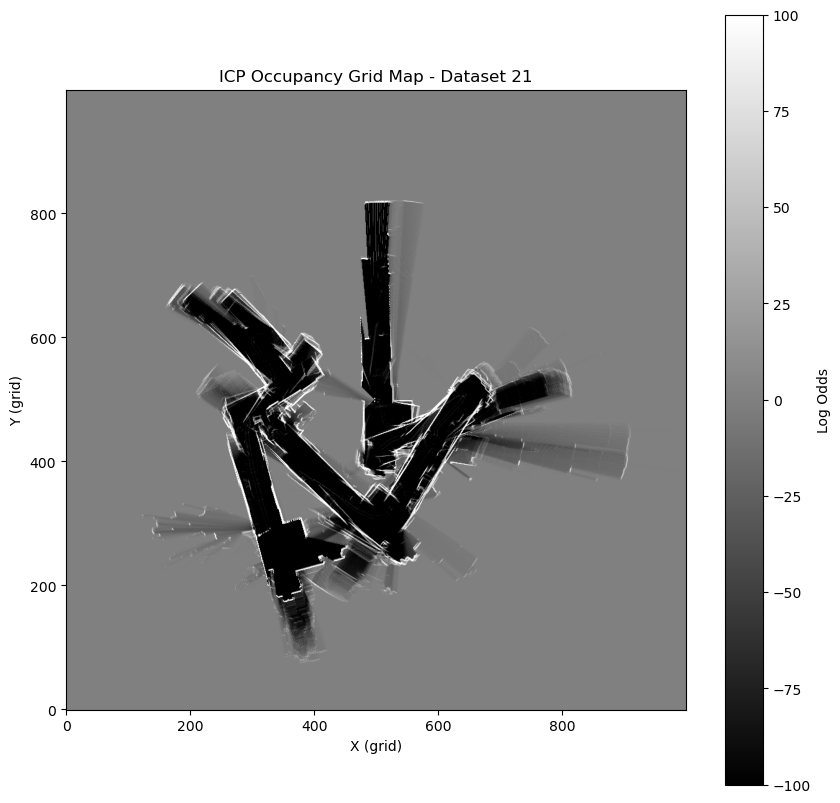

In [15]:
# Testing occupancy map T_icp
resolution = 0.05  # 5 cm per grid cell (meters per grid unit)
scale_factor = 1 / resolution  # Convert meters to grid units
grid_size = 1000  # Define a large fixed occupancy grid

occupancy_grid = np.zeros((grid_size, grid_size), dtype=np.float32)

grid_center_x = grid_size // 2
grid_center_y = grid_size // 2

l_occupied = +4
l_free = -0.5
l_max = 100
l_min = -100

positions_world_icp = []
robot_origin = np.array([0, 0, 1])  # Start in world coordinates (meters)

for i in range(e_time.shape[0]):
    print(f"Iteration: {i}")

    curr_origin = np.dot(T_icp[:, :, i], robot_origin)
    positions_world_icp.append(curr_origin[:2])

    robot_x_grid = np.round(curr_origin[0] * scale_factor + grid_center_x).astype(int)
    robot_y_grid = np.round(curr_origin[1] * scale_factor + grid_center_y).astype(int)

    print(f"Iteration {i}: World Position: {curr_origin[:2]} -> Grid Position: ({robot_x_grid}, {robot_y_grid})")

    ff = pc_sync[:, :, i]
    valid_mask = np.isfinite(ff).all(axis=0)  # Eliminate nan
    ff = ff[:, valid_mask]
    ff_homo = np.vstack((ff, np.ones(ff.shape[1])))
    ff_trans = T_icp[:, :, i] @ ff_homo  

    x_world = ff_trans[0, :]
    y_world = ff_trans[1, :]

    x_grid = np.round(x_world * scale_factor + grid_center_x).astype(int)
    y_grid = np.round(y_world * scale_factor + grid_center_y).astype(int)

    valid_mask = (x_grid >= 0) & (x_grid < grid_size) & (y_grid >= 0) & (y_grid < grid_size)
    x_valid = x_grid[valid_mask]
    y_valid = y_grid[valid_mask]

    occupancy_grid[y_valid, x_valid] = np.clip(occupancy_grid[y_valid, x_valid] + l_occupied, l_min, l_max)

    free_x_list = []
    free_y_list = []

    for x_end, y_end in zip(x_valid, y_valid):
        free_cells = np.array(bresenham(robot_x_grid, robot_y_grid, x_end, y_end))[:-1]  # Exclude last occupied cell
        free_x_list.append(free_cells[:, 0])
        free_y_list.append(free_cells[:, 1])

    if free_x_list:
        free_x = np.concatenate(free_x_list)
        free_y = np.concatenate(free_y_list)

        valid_free_mask = (free_x >= 0) & (free_x < grid_size) & (free_y >= 0) & (free_y < grid_size)
        free_x = free_x[valid_free_mask]
        free_y = free_y[valid_free_mask]

        occupancy_grid[free_y, free_x] = np.clip(occupancy_grid[free_y, free_x] + l_free, l_min, l_max)

plt.figure(figsize=(10, 10))
plt.imshow(occupancy_grid, cmap="gray", origin="lower")
plt.colorbar(label="Log Odds")
plt.xlabel("X (grid)")
plt.ylabel("Y (grid)")
plt.title("ICP Occupancy Grid Map - Dataset " + str(dataset))
plt.show()


Iteration: 0
Iteration 0: World Position: [-0.13323  0.     ] -> Grid Position: (497, 500)
Iteration: 1
Iteration 1: World Position: [-0.13373012  0.00074726] -> Grid Position: (497, 500)
Iteration: 2
Iteration 2: World Position: [-0.13358133  0.00029428] -> Grid Position: (497, 500)
Iteration: 3
Iteration 3: World Position: [-0.13358133  0.00029428] -> Grid Position: (497, 500)
Iteration: 4
Iteration 4: World Position: [-0.13347629 -0.0003027 ] -> Grid Position: (497, 500)
Iteration: 5
Iteration 5: World Position: [-0.13327751 -0.00061299] -> Grid Position: (497, 500)
Iteration: 6
Iteration 6: World Position: [-0.13327751 -0.00061299] -> Grid Position: (497, 500)
Iteration: 7
Iteration 7: World Position: [-0.13326169 -0.00084293] -> Grid Position: (497, 500)
Iteration: 8
Iteration 8: World Position: [-0.133269   -0.00111826] -> Grid Position: (497, 500)
Iteration: 9
Iteration 9: World Position: [-0.13357976 -0.00176699] -> Grid Position: (497, 500)
Iteration: 10
Iteration 10: World Po

Iteration: 86
Iteration 86: World Position: [-0.13219291 -0.01166491] -> Grid Position: (497, 500)
Iteration: 87
Iteration 87: World Position: [-0.13213004 -0.0132083 ] -> Grid Position: (497, 500)
Iteration: 88
Iteration 88: World Position: [-0.13205086 -0.01354302] -> Grid Position: (497, 500)
Iteration: 89
Iteration 89: World Position: [-0.13189904 -0.01313965] -> Grid Position: (497, 500)
Iteration: 90
Iteration 90: World Position: [-0.13208808 -0.012968  ] -> Grid Position: (497, 500)
Iteration: 91
Iteration 91: World Position: [-0.13188514 -0.01309672] -> Grid Position: (497, 500)
Iteration: 92
Iteration 92: World Position: [-0.13201124 -0.01173122] -> Grid Position: (497, 500)
Iteration: 93
Iteration 93: World Position: [-0.13214843 -0.01152664] -> Grid Position: (497, 500)
Iteration: 94
Iteration 94: World Position: [-0.13184109 -0.01213067] -> Grid Position: (497, 500)
Iteration: 95
Iteration 95: World Position: [-0.13182055 -0.01267917] -> Grid Position: (497, 500)
Iteration:

Iteration: 174
Iteration 174: World Position: [-0.13080556 -0.02122764] -> Grid Position: (497, 500)
Iteration: 175
Iteration 175: World Position: [-0.13071356 -0.02067381] -> Grid Position: (497, 500)
Iteration: 176
Iteration 176: World Position: [-0.1306208  -0.02050955] -> Grid Position: (497, 500)
Iteration: 177
Iteration 177: World Position: [-0.13090867 -0.02038576] -> Grid Position: (497, 500)
Iteration: 178
Iteration 178: World Position: [-0.13090867 -0.02038576] -> Grid Position: (497, 500)
Iteration: 179
Iteration 179: World Position: [-0.13042543 -0.02075414] -> Grid Position: (497, 500)
Iteration: 180
Iteration 180: World Position: [-0.13087922 -0.01986926] -> Grid Position: (497, 500)
Iteration: 181
Iteration 181: World Position: [-0.13089582 -0.02055933] -> Grid Position: (497, 500)
Iteration: 182
Iteration 182: World Position: [-0.13072131 -0.02047435] -> Grid Position: (497, 500)
Iteration: 183
Iteration 183: World Position: [-0.13072131 -0.02047435] -> Grid Position: (

Iteration: 262
Iteration 262: World Position: [-0.12923161 -0.03439257] -> Grid Position: (497, 499)
Iteration: 263
Iteration 263: World Position: [-0.12930012 -0.03422892] -> Grid Position: (497, 499)
Iteration: 264
Iteration 264: World Position: [-0.12939817 -0.03469932] -> Grid Position: (497, 499)
Iteration: 265
Iteration 265: World Position: [-0.12924344 -0.03492421] -> Grid Position: (497, 499)
Iteration: 266
Iteration 266: World Position: [-0.12924055 -0.03570471] -> Grid Position: (497, 499)
Iteration: 267
Iteration 267: World Position: [-0.12926938 -0.03565344] -> Grid Position: (497, 499)
Iteration: 268
Iteration 268: World Position: [-0.12935332 -0.03618614] -> Grid Position: (497, 499)
Iteration: 269
Iteration 269: World Position: [-0.1291651  -0.03655925] -> Grid Position: (497, 499)
Iteration: 270
Iteration 270: World Position: [-0.12919342 -0.03657282] -> Grid Position: (497, 499)
Iteration: 271
Iteration 271: World Position: [-0.12922913 -0.03713548] -> Grid Position: (

Iteration: 350
Iteration 350: World Position: [-0.12685405 -0.05517996] -> Grid Position: (497, 499)
Iteration: 351
Iteration 351: World Position: [-0.12658887 -0.0556784 ] -> Grid Position: (497, 499)
Iteration: 352
Iteration 352: World Position: [-0.12667512 -0.05503075] -> Grid Position: (497, 499)
Iteration: 353
Iteration 353: World Position: [-0.12629327 -0.05602949] -> Grid Position: (497, 499)
Iteration: 354
Iteration 354: World Position: [-0.1265565  -0.05545909] -> Grid Position: (497, 499)
Iteration: 355
Iteration 355: World Position: [-0.12639399 -0.05664843] -> Grid Position: (497, 499)
Iteration: 356
Iteration 356: World Position: [-0.12604477 -0.05667426] -> Grid Position: (497, 499)
Iteration: 357
Iteration 357: World Position: [-0.12636707 -0.05671104] -> Grid Position: (497, 499)
Iteration: 358
Iteration 358: World Position: [-0.12606506 -0.05767779] -> Grid Position: (497, 499)
Iteration: 359
Iteration 359: World Position: [-0.12590493 -0.05830521] -> Grid Position: (

Iteration: 437
Iteration 437: World Position: [-0.12365181 -0.0710564 ] -> Grid Position: (498, 499)
Iteration: 438
Iteration 438: World Position: [-0.12364954 -0.07091216] -> Grid Position: (498, 499)
Iteration: 439
Iteration 439: World Position: [-0.12359763 -0.07079834] -> Grid Position: (498, 499)
Iteration: 440
Iteration 440: World Position: [-0.12384055 -0.07054406] -> Grid Position: (498, 499)
Iteration: 441
Iteration 441: World Position: [-0.12366886 -0.07013076] -> Grid Position: (498, 499)
Iteration: 442
Iteration 442: World Position: [-0.12413085 -0.07045238] -> Grid Position: (498, 499)
Iteration: 443
Iteration 443: World Position: [-0.12374451 -0.07093183] -> Grid Position: (498, 499)
Iteration: 444
Iteration 444: World Position: [-0.12346593 -0.07075582] -> Grid Position: (498, 499)
Iteration: 445
Iteration 445: World Position: [-0.12368132 -0.07145492] -> Grid Position: (498, 499)
Iteration: 446
Iteration 446: World Position: [-0.12397821 -0.07080527] -> Grid Position: (

Iteration: 523
Iteration 523: World Position: [-0.10673563 -0.07612645] -> Grid Position: (498, 498)
Iteration: 524
Iteration 524: World Position: [-0.10001236 -0.07127762] -> Grid Position: (498, 499)
Iteration: 525
Iteration 525: World Position: [-0.09587084 -0.07162187] -> Grid Position: (498, 499)
Iteration: 526
Iteration 526: World Position: [-0.08835867 -0.06498026] -> Grid Position: (498, 499)
Iteration: 527
Iteration 527: World Position: [-0.07997658 -0.06015084] -> Grid Position: (498, 499)
Iteration: 528
Iteration 528: World Position: [-0.07073634 -0.05543544] -> Grid Position: (499, 499)
Iteration: 529
Iteration 529: World Position: [-0.06094666 -0.06114691] -> Grid Position: (499, 499)
Iteration: 530
Iteration 530: World Position: [-0.05112539 -0.05679822] -> Grid Position: (499, 499)
Iteration: 531
Iteration 531: World Position: [-0.04067579 -0.06164523] -> Grid Position: (499, 499)
Iteration: 532
Iteration 532: World Position: [-0.0279703  -0.05834928] -> Grid Position: (

Iteration: 608
Iteration 608: World Position: [ 0.36764187 -0.51093974] -> Grid Position: (507, 490)
Iteration: 609
Iteration 609: World Position: [ 0.37222904 -0.52384803] -> Grid Position: (507, 490)
Iteration: 610
Iteration 610: World Position: [ 0.37593057 -0.53457753] -> Grid Position: (508, 489)
Iteration: 611
Iteration 611: World Position: [ 0.38315741 -0.54628208] -> Grid Position: (508, 489)
Iteration: 612
Iteration 612: World Position: [ 0.38508336 -0.56086126] -> Grid Position: (508, 489)
Iteration: 613
Iteration 613: World Position: [ 0.38901495 -0.5711206 ] -> Grid Position: (508, 489)
Iteration: 614
Iteration 614: World Position: [ 0.39229887 -0.58478082] -> Grid Position: (508, 488)
Iteration: 615
Iteration 615: World Position: [ 0.39647206 -0.59743703] -> Grid Position: (508, 488)
Iteration: 616
Iteration 616: World Position: [ 0.39760144 -0.59553027] -> Grid Position: (508, 488)
Iteration: 617
Iteration 617: World Position: [ 0.39933801 -0.61307357] -> Grid Position: (

Iteration: 692
Iteration 692: World Position: [ 0.64172498 -1.82046385] -> Grid Position: (513, 464)
Iteration: 693
Iteration 693: World Position: [ 0.64897907 -1.83549622] -> Grid Position: (513, 463)
Iteration: 694
Iteration 694: World Position: [ 0.65646892 -1.84861906] -> Grid Position: (513, 463)
Iteration: 695
Iteration 695: World Position: [ 0.66401607 -1.86120188] -> Grid Position: (513, 463)
Iteration: 696
Iteration 696: World Position: [ 0.67517679 -1.8703765 ] -> Grid Position: (514, 463)
Iteration: 697
Iteration 697: World Position: [ 0.68290359 -1.88116316] -> Grid Position: (514, 462)
Iteration: 698
Iteration 698: World Position: [ 0.69112581 -1.9120787 ] -> Grid Position: (514, 462)
Iteration: 699
Iteration 699: World Position: [ 0.70066431 -1.94633123] -> Grid Position: (514, 461)
Iteration: 700
Iteration 700: World Position: [ 0.70408975 -2.03710591] -> Grid Position: (514, 459)
Iteration: 701
Iteration 701: World Position: [ 0.71600232 -2.05344327] -> Grid Position: (

Iteration: 783
Iteration 783: World Position: [ 2.16586295 -2.55157428] -> Grid Position: (543, 449)
Iteration: 784
Iteration 784: World Position: [ 2.17362916 -2.55671503] -> Grid Position: (543, 449)
Iteration: 785
Iteration 785: World Position: [ 2.18295313 -2.55911246] -> Grid Position: (544, 449)
Iteration: 786
Iteration 786: World Position: [ 2.19190978 -2.56515782] -> Grid Position: (544, 449)
Iteration: 787
Iteration 787: World Position: [ 2.19937223 -2.56801181] -> Grid Position: (544, 449)
Iteration: 788
Iteration 788: World Position: [ 2.20908635 -2.57255532] -> Grid Position: (544, 449)
Iteration: 789
Iteration 789: World Position: [ 2.22500715 -2.57783199] -> Grid Position: (545, 448)
Iteration: 790
Iteration 790: World Position: [ 2.2384623  -2.58499374] -> Grid Position: (545, 448)
Iteration: 791
Iteration 791: World Position: [ 2.24549417 -2.58932786] -> Grid Position: (545, 448)
Iteration: 792
Iteration 792: World Position: [ 2.25367306 -2.59393808] -> Grid Position: (

Iteration: 876
Iteration 876: World Position: [ 2.21336845 -3.06283136] -> Grid Position: (544, 439)
Iteration: 877
Iteration 877: World Position: [ 2.24060791 -3.06571867] -> Grid Position: (545, 439)
Iteration: 878
Iteration 878: World Position: [ 2.26643128 -3.06874959] -> Grid Position: (545, 439)
Iteration: 879
Iteration 879: World Position: [ 2.30016239 -3.06948113] -> Grid Position: (546, 439)
Iteration: 880
Iteration 880: World Position: [ 2.34648059 -3.06967263] -> Grid Position: (547, 439)
Iteration: 881
Iteration 881: World Position: [ 2.40413153 -3.06761862] -> Grid Position: (548, 439)
Iteration: 882
Iteration 882: World Position: [ 2.45579691 -3.06604732] -> Grid Position: (549, 439)
Iteration: 883
Iteration 883: World Position: [ 2.48851504 -3.06654987] -> Grid Position: (550, 439)
Iteration: 884
Iteration 884: World Position: [ 2.50130728 -3.06976574] -> Grid Position: (550, 439)
Iteration: 885
Iteration 885: World Position: [ 2.5111102  -3.07146138] -> Grid Position: (

Iteration: 966
Iteration 966: World Position: [ 1.05944047 -3.3916942 ] -> Grid Position: (521, 432)
Iteration: 967
Iteration 967: World Position: [ 1.07061114 -3.38381906] -> Grid Position: (521, 432)
Iteration: 968
Iteration 968: World Position: [ 1.08493139 -3.37405783] -> Grid Position: (522, 433)
Iteration: 969
Iteration 969: World Position: [ 1.10178841 -3.36318183] -> Grid Position: (522, 433)
Iteration: 970
Iteration 970: World Position: [ 1.11746462 -3.35463458] -> Grid Position: (522, 433)
Iteration: 971
Iteration 971: World Position: [ 1.12699596 -3.34788619] -> Grid Position: (523, 433)
Iteration: 972
Iteration 972: World Position: [ 1.12836732 -3.34326002] -> Grid Position: (523, 433)
Iteration: 973
Iteration 973: World Position: [ 1.16547066 -3.32583851] -> Grid Position: (523, 433)
Iteration: 974
Iteration 974: World Position: [ 1.17956017 -3.31797224] -> Grid Position: (524, 434)
Iteration: 975
Iteration 975: World Position: [ 1.1903928  -3.30823367] -> Grid Position: (

Iteration: 1052
Iteration 1052: World Position: [ 2.26581095 -2.94339577] -> Grid Position: (545, 441)
Iteration: 1053
Iteration 1053: World Position: [ 2.28354018 -2.9398235 ] -> Grid Position: (546, 441)
Iteration: 1054
Iteration 1054: World Position: [ 2.29659237 -2.93692105] -> Grid Position: (546, 441)
Iteration: 1055
Iteration 1055: World Position: [ 2.30574069 -2.93388968] -> Grid Position: (546, 441)
Iteration: 1056
Iteration 1056: World Position: [ 2.31881513 -2.92953603] -> Grid Position: (546, 441)
Iteration: 1057
Iteration 1057: World Position: [ 2.31881513 -2.92953603] -> Grid Position: (546, 441)
Iteration: 1058
Iteration 1058: World Position: [ 2.34589325 -2.92191067] -> Grid Position: (547, 442)
Iteration: 1059
Iteration 1059: World Position: [ 2.34589325 -2.92191067] -> Grid Position: (547, 442)
Iteration: 1060
Iteration 1060: World Position: [ 2.37577233 -2.91348726] -> Grid Position: (548, 442)
Iteration: 1061
Iteration 1061: World Position: [ 2.3916247  -2.90971956]

Iteration: 1142
Iteration 1142: World Position: [ 3.41700138 -2.62689071] -> Grid Position: (568, 447)
Iteration: 1143
Iteration 1143: World Position: [ 3.41700138 -2.62689071] -> Grid Position: (568, 447)
Iteration: 1144
Iteration 1144: World Position: [ 3.43121866 -2.62258913] -> Grid Position: (569, 448)
Iteration: 1145
Iteration 1145: World Position: [ 3.45107329 -2.61634043] -> Grid Position: (569, 448)
Iteration: 1146
Iteration 1146: World Position: [ 3.45768719 -2.61494393] -> Grid Position: (569, 448)
Iteration: 1147
Iteration 1147: World Position: [ 3.45768719 -2.61494393] -> Grid Position: (569, 448)
Iteration: 1148
Iteration 1148: World Position: [ 3.46603562 -2.61304789] -> Grid Position: (569, 448)
Iteration: 1149
Iteration 1149: World Position: [ 3.48568908 -2.60661037] -> Grid Position: (570, 448)
Iteration: 1150
Iteration 1150: World Position: [ 3.49357267 -2.6040009 ] -> Grid Position: (570, 448)
Iteration: 1151
Iteration 1151: World Position: [ 3.49357267 -2.6040009 ]

Iteration: 1222
Iteration 1222: World Position: [ 3.91572872 -2.50876068] -> Grid Position: (578, 450)
Iteration: 1223
Iteration 1223: World Position: [ 3.93013776 -2.50304578] -> Grid Position: (579, 450)
Iteration: 1224
Iteration 1224: World Position: [ 3.96543615 -2.4866698 ] -> Grid Position: (579, 450)
Iteration: 1225
Iteration 1225: World Position: [ 3.96543615 -2.4866698 ] -> Grid Position: (579, 450)
Iteration: 1226
Iteration 1226: World Position: [ 3.9733665  -2.48570676] -> Grid Position: (579, 450)
Iteration: 1227
Iteration 1227: World Position: [ 3.98066953 -2.48509732] -> Grid Position: (580, 450)
Iteration: 1228
Iteration 1228: World Position: [ 4.00187352 -2.47503402] -> Grid Position: (580, 450)
Iteration: 1229
Iteration 1229: World Position: [ 4.01532019 -2.47021292] -> Grid Position: (580, 451)
Iteration: 1230
Iteration 1230: World Position: [ 4.03185225 -2.46397572] -> Grid Position: (581, 451)
Iteration: 1231
Iteration 1231: World Position: [ 4.04506306 -2.45801161]

Iteration: 1302
Iteration 1302: World Position: [ 4.83236057 -2.15923579] -> Grid Position: (597, 457)
Iteration: 1303
Iteration 1303: World Position: [ 4.86783025 -2.13744582] -> Grid Position: (597, 457)
Iteration: 1304
Iteration 1304: World Position: [ 4.89865709 -2.11994356] -> Grid Position: (598, 458)
Iteration: 1305
Iteration 1305: World Position: [ 4.9229904  -2.10402849] -> Grid Position: (598, 458)
Iteration: 1306
Iteration 1306: World Position: [ 4.9492475  -2.08810035] -> Grid Position: (599, 458)
Iteration: 1307
Iteration 1307: World Position: [ 4.97376034 -2.07309414] -> Grid Position: (599, 459)
Iteration: 1308
Iteration 1308: World Position: [ 4.99601006 -2.06122107] -> Grid Position: (600, 459)
Iteration: 1309
Iteration 1309: World Position: [ 5.01359968 -2.05196729] -> Grid Position: (600, 459)
Iteration: 1310
Iteration 1310: World Position: [ 5.02126241 -2.04795554] -> Grid Position: (600, 459)
Iteration: 1311
Iteration 1311: World Position: [ 5.02930479 -2.04378436]

Iteration: 1383
Iteration 1383: World Position: [ 4.04336038 -2.88941237] -> Grid Position: (581, 442)
Iteration: 1384
Iteration 1384: World Position: [ 4.05500617 -2.87990558] -> Grid Position: (581, 442)
Iteration: 1385
Iteration 1385: World Position: [ 4.06648402 -2.87048476] -> Grid Position: (581, 443)
Iteration: 1386
Iteration 1386: World Position: [ 4.07880982 -2.86087357] -> Grid Position: (582, 443)
Iteration: 1387
Iteration 1387: World Position: [ 4.09158383 -2.85235914] -> Grid Position: (582, 443)
Iteration: 1388
Iteration 1388: World Position: [ 4.10348746 -2.84307736] -> Grid Position: (582, 443)
Iteration: 1389
Iteration 1389: World Position: [ 4.11503081 -2.83347958] -> Grid Position: (582, 443)
Iteration: 1390
Iteration 1390: World Position: [ 4.12409724 -2.82611609] -> Grid Position: (582, 443)
Iteration: 1391
Iteration 1391: World Position: [ 4.1356993  -2.81750112] -> Grid Position: (583, 444)
Iteration: 1392
Iteration 1392: World Position: [ 4.14517344 -2.80959463]

Iteration: 1474
Iteration 1474: World Position: [ 5.14304283 -1.53795087] -> Grid Position: (603, 469)
Iteration: 1475
Iteration 1475: World Position: [ 5.15707084 -1.5172846 ] -> Grid Position: (603, 470)
Iteration: 1476
Iteration 1476: World Position: [ 5.1691266  -1.49772355] -> Grid Position: (603, 470)
Iteration: 1477
Iteration 1477: World Position: [ 5.18191683 -1.47699785] -> Grid Position: (604, 470)
Iteration: 1478
Iteration 1478: World Position: [ 5.1950343  -1.45609163] -> Grid Position: (604, 471)
Iteration: 1479
Iteration 1479: World Position: [ 5.20694374 -1.43789288] -> Grid Position: (604, 471)
Iteration: 1480
Iteration 1480: World Position: [ 5.22080714 -1.41641667] -> Grid Position: (604, 472)
Iteration: 1481
Iteration 1481: World Position: [ 5.23082351 -1.39816366] -> Grid Position: (605, 472)
Iteration: 1482
Iteration 1482: World Position: [ 5.24243451 -1.37842526] -> Grid Position: (605, 472)
Iteration: 1483
Iteration 1483: World Position: [ 5.25477498 -1.35866276]

Iteration: 1562
Iteration 1562: World Position: [6.23458427e+00 5.11286153e-03] -> Grid Position: (625, 500)
Iteration: 1563
Iteration 1563: World Position: [6.24161488 0.01042217] -> Grid Position: (625, 500)
Iteration: 1564
Iteration 1564: World Position: [6.26017311 0.02029379] -> Grid Position: (625, 500)
Iteration: 1565
Iteration 1565: World Position: [6.2696425  0.02494964] -> Grid Position: (625, 500)
Iteration: 1566
Iteration 1566: World Position: [6.29647352 0.04021957] -> Grid Position: (626, 501)
Iteration: 1567
Iteration 1567: World Position: [6.30642818 0.04484303] -> Grid Position: (626, 501)
Iteration: 1568
Iteration 1568: World Position: [6.32908031 0.05875571] -> Grid Position: (627, 501)
Iteration: 1569
Iteration 1569: World Position: [6.3402875  0.06485379] -> Grid Position: (627, 501)
Iteration: 1570
Iteration 1570: World Position: [6.3402875  0.06485379] -> Grid Position: (627, 501)
Iteration: 1571
Iteration 1571: World Position: [6.35232683 0.07070106] -> Grid Pos

Iteration: 1650
Iteration 1650: World Position: [7.14687684 0.25434305] -> Grid Position: (643, 505)
Iteration: 1651
Iteration 1651: World Position: [7.14236796 0.25424587] -> Grid Position: (643, 505)
Iteration: 1652
Iteration 1652: World Position: [7.13552111 0.25587703] -> Grid Position: (643, 505)
Iteration: 1653
Iteration 1653: World Position: [7.13469241 0.25726622] -> Grid Position: (643, 505)
Iteration: 1654
Iteration 1654: World Position: [7.13228061 0.25786264] -> Grid Position: (643, 505)
Iteration: 1655
Iteration 1655: World Position: [7.12912243 0.25753425] -> Grid Position: (643, 505)
Iteration: 1656
Iteration 1656: World Position: [7.12569569 0.25800023] -> Grid Position: (643, 505)
Iteration: 1657
Iteration 1657: World Position: [7.11842513 0.25746125] -> Grid Position: (642, 505)
Iteration: 1658
Iteration 1658: World Position: [7.11066077 0.25728646] -> Grid Position: (642, 505)
Iteration: 1659
Iteration 1659: World Position: [7.1007905  0.25395442] -> Grid Position: (

Iteration: 1739
Iteration 1739: World Position: [ 6.27396331 -0.73038025] -> Grid Position: (625, 485)
Iteration: 1740
Iteration 1740: World Position: [ 6.26027989 -0.74769542] -> Grid Position: (625, 485)
Iteration: 1741
Iteration 1741: World Position: [ 6.24617722 -0.76645136] -> Grid Position: (625, 485)
Iteration: 1742
Iteration 1742: World Position: [ 6.23488846 -0.78265325] -> Grid Position: (625, 484)
Iteration: 1743
Iteration 1743: World Position: [ 6.22395495 -0.79959351] -> Grid Position: (624, 484)
Iteration: 1744
Iteration 1744: World Position: [ 6.21205478 -0.81568875] -> Grid Position: (624, 484)
Iteration: 1745
Iteration 1745: World Position: [ 6.19998059 -0.83396826] -> Grid Position: (624, 483)
Iteration: 1746
Iteration 1746: World Position: [ 6.18452226 -0.85551134] -> Grid Position: (624, 483)
Iteration: 1747
Iteration 1747: World Position: [ 6.17343367 -0.87051472] -> Grid Position: (623, 483)
Iteration: 1748
Iteration 1748: World Position: [ 6.16535274 -0.87930924]

Iteration: 1823
Iteration 1823: World Position: [ 5.30305877 -1.80802564] -> Grid Position: (606, 464)
Iteration: 1824
Iteration 1824: World Position: [ 5.29290111 -1.81945371] -> Grid Position: (606, 464)
Iteration: 1825
Iteration 1825: World Position: [ 5.2817522  -1.83109108] -> Grid Position: (606, 463)
Iteration: 1826
Iteration 1826: World Position: [ 5.26552635 -1.84974006] -> Grid Position: (605, 463)
Iteration: 1827
Iteration 1827: World Position: [ 5.25112196 -1.86732374] -> Grid Position: (605, 463)
Iteration: 1828
Iteration 1828: World Position: [ 5.24131789 -1.87821536] -> Grid Position: (605, 462)
Iteration: 1829
Iteration 1829: World Position: [ 5.22764612 -1.89621517] -> Grid Position: (605, 462)
Iteration: 1830
Iteration 1830: World Position: [ 5.19903319 -1.93227688] -> Grid Position: (604, 461)
Iteration: 1831
Iteration 1831: World Position: [ 5.19903319 -1.93227688] -> Grid Position: (604, 461)
Iteration: 1832
Iteration 1832: World Position: [ 5.19697176 -1.93219514]

Iteration: 1905
Iteration 1905: World Position: [ 4.76187757 -2.76996696] -> Grid Position: (595, 445)
Iteration: 1906
Iteration 1906: World Position: [ 4.75806335 -2.78216475] -> Grid Position: (595, 444)
Iteration: 1907
Iteration 1907: World Position: [ 4.7535843  -2.79234826] -> Grid Position: (595, 444)
Iteration: 1908
Iteration 1908: World Position: [ 4.74918433 -2.80582327] -> Grid Position: (595, 444)
Iteration: 1909
Iteration 1909: World Position: [ 4.74969468 -2.81484646] -> Grid Position: (595, 444)
Iteration: 1910
Iteration 1910: World Position: [ 4.75141221 -2.82052899] -> Grid Position: (595, 444)
Iteration: 1911
Iteration 1911: World Position: [ 4.75186085 -2.82707478] -> Grid Position: (595, 443)
Iteration: 1912
Iteration 1912: World Position: [ 4.75213322 -2.83519741] -> Grid Position: (595, 443)
Iteration: 1913
Iteration 1913: World Position: [ 4.75320886 -2.84321038] -> Grid Position: (595, 443)
Iteration: 1914
Iteration 1914: World Position: [ 4.75112021 -2.85363854]

Iteration: 1990
Iteration 1990: World Position: [ 4.07006497 -4.28982944] -> Grid Position: (581, 414)
Iteration: 1991
Iteration 1991: World Position: [ 4.07710847 -4.28054453] -> Grid Position: (582, 414)
Iteration: 1992
Iteration 1992: World Position: [ 4.07921081 -4.2822973 ] -> Grid Position: (582, 414)
Iteration: 1993
Iteration 1993: World Position: [ 4.08174746 -4.28376693] -> Grid Position: (582, 414)
Iteration: 1994
Iteration 1994: World Position: [ 4.08581555 -4.2833173 ] -> Grid Position: (582, 414)
Iteration: 1995
Iteration 1995: World Position: [ 4.08335611 -4.29483217] -> Grid Position: (582, 414)
Iteration: 1996
Iteration 1996: World Position: [ 4.07901604 -4.30793222] -> Grid Position: (582, 414)
Iteration: 1997
Iteration 1997: World Position: [ 4.07886387 -4.31397075] -> Grid Position: (582, 414)
Iteration: 1998
Iteration 1998: World Position: [ 4.07389169 -4.33128635] -> Grid Position: (581, 413)
Iteration: 1999
Iteration 1999: World Position: [ 4.06612622 -4.35228437]

Iteration: 2076
Iteration 2076: World Position: [ 3.93853139 -4.70236954] -> Grid Position: (579, 406)
Iteration: 2077
Iteration 2077: World Position: [ 3.94552078 -4.68649841] -> Grid Position: (579, 406)
Iteration: 2078
Iteration 2078: World Position: [ 3.94445958 -4.69045929] -> Grid Position: (579, 406)
Iteration: 2079
Iteration 2079: World Position: [ 3.93896222 -4.70191085] -> Grid Position: (579, 406)
Iteration: 2080
Iteration 2080: World Position: [ 3.93788158 -4.70801654] -> Grid Position: (579, 406)
Iteration: 2081
Iteration 2081: World Position: [ 3.93500203 -4.71520129] -> Grid Position: (579, 406)
Iteration: 2082
Iteration 2082: World Position: [ 3.92918595 -4.72827049] -> Grid Position: (579, 405)
Iteration: 2083
Iteration 2083: World Position: [ 3.92165519 -4.74270882] -> Grid Position: (578, 405)
Iteration: 2084
Iteration 2084: World Position: [ 3.92467447 -4.74089656] -> Grid Position: (578, 405)
Iteration: 2085
Iteration 2085: World Position: [ 3.92723435 -4.73679013]

Iteration: 2156
Iteration 2156: World Position: [ 4.39394792 -4.19843976] -> Grid Position: (588, 416)
Iteration: 2157
Iteration 2157: World Position: [ 4.38660928 -4.20888942] -> Grid Position: (588, 416)
Iteration: 2158
Iteration 2158: World Position: [ 4.37260904 -4.22843555] -> Grid Position: (587, 415)
Iteration: 2159
Iteration 2159: World Position: [ 4.36573112 -4.23836595] -> Grid Position: (587, 415)
Iteration: 2160
Iteration 2160: World Position: [ 4.35886109 -4.24797378] -> Grid Position: (587, 415)
Iteration: 2161
Iteration 2161: World Position: [ 4.35167135 -4.25919414] -> Grid Position: (587, 415)
Iteration: 2162
Iteration 2162: World Position: [ 4.35167135 -4.25919414] -> Grid Position: (587, 415)
Iteration: 2163
Iteration 2163: World Position: [ 4.34551695 -4.26892985] -> Grid Position: (587, 415)
Iteration: 2164
Iteration 2164: World Position: [ 4.34551695 -4.26892985] -> Grid Position: (587, 415)
Iteration: 2165
Iteration 2165: World Position: [ 4.34551695 -4.26892985]

Iteration: 2249
Iteration 2249: World Position: [ 3.33876322 -5.70213307] -> Grid Position: (567, 386)
Iteration: 2250
Iteration 2250: World Position: [ 3.31449709 -5.74665013] -> Grid Position: (566, 385)
Iteration: 2251
Iteration 2251: World Position: [ 3.30576476 -5.76416655] -> Grid Position: (566, 385)
Iteration: 2252
Iteration 2252: World Position: [ 3.30576476 -5.76416655] -> Grid Position: (566, 385)
Iteration: 2253
Iteration 2253: World Position: [ 3.30576476 -5.76416655] -> Grid Position: (566, 385)
Iteration: 2254
Iteration 2254: World Position: [ 3.29497751 -5.78159473] -> Grid Position: (566, 384)
Iteration: 2255
Iteration 2255: World Position: [ 3.28700557 -5.79779874] -> Grid Position: (566, 384)
Iteration: 2256
Iteration 2256: World Position: [ 3.27800326 -5.81533618] -> Grid Position: (566, 384)
Iteration: 2257
Iteration 2257: World Position: [ 3.27103166 -5.83116921] -> Grid Position: (565, 383)
Iteration: 2258
Iteration 2258: World Position: [ 3.25036118 -5.86903954]

Iteration: 2338
Iteration 2338: World Position: [ 2.33443026 -7.60343776] -> Grid Position: (547, 348)
Iteration: 2339
Iteration 2339: World Position: [ 2.32879659 -7.61225589] -> Grid Position: (547, 348)
Iteration: 2340
Iteration 2340: World Position: [ 2.32528754 -7.6195996 ] -> Grid Position: (547, 348)
Iteration: 2341
Iteration 2341: World Position: [ 2.32244209 -7.62516128] -> Grid Position: (546, 347)
Iteration: 2342
Iteration 2342: World Position: [ 2.3157891  -7.63222611] -> Grid Position: (546, 347)
Iteration: 2343
Iteration 2343: World Position: [ 2.31067501 -7.63497408] -> Grid Position: (546, 347)
Iteration: 2344
Iteration 2344: World Position: [ 2.3186637  -7.62874572] -> Grid Position: (546, 347)
Iteration: 2345
Iteration 2345: World Position: [ 2.3100254 -7.6357022] -> Grid Position: (546, 347)
Iteration: 2346
Iteration 2346: World Position: [ 2.30668593 -7.63896337] -> Grid Position: (546, 347)
Iteration: 2347
Iteration 2347: World Position: [ 2.30668593 -7.63896337] -

Iteration: 2425
Iteration 2425: World Position: [ 1.72441163 -8.1298741 ] -> Grid Position: (534, 337)
Iteration: 2426
Iteration 2426: World Position: [ 1.71132204 -8.13972857] -> Grid Position: (534, 337)
Iteration: 2427
Iteration 2427: World Position: [ 1.71132204 -8.13972857] -> Grid Position: (534, 337)
Iteration: 2428
Iteration 2428: World Position: [ 1.70534026 -8.14565471] -> Grid Position: (534, 337)
Iteration: 2429
Iteration 2429: World Position: [ 1.69768416 -8.15136401] -> Grid Position: (534, 337)
Iteration: 2430
Iteration 2430: World Position: [ 1.68093745 -8.17021316] -> Grid Position: (534, 337)
Iteration: 2431
Iteration 2431: World Position: [ 1.66538389 -8.18895201] -> Grid Position: (533, 336)
Iteration: 2432
Iteration 2432: World Position: [ 1.76529179 -8.21611558] -> Grid Position: (535, 336)
Iteration: 2433
Iteration 2433: World Position: [ 1.7794571  -8.22906066] -> Grid Position: (536, 335)
Iteration: 2434
Iteration 2434: World Position: [ 1.82809487 -8.20921668]

Iteration: 2510
Iteration 2510: World Position: [ 0.73680604 -9.18043333] -> Grid Position: (515, 316)
Iteration: 2511
Iteration 2511: World Position: [ 0.72313304 -9.19281191] -> Grid Position: (514, 316)
Iteration: 2512
Iteration 2512: World Position: [ 0.71479917 -9.20016273] -> Grid Position: (514, 316)
Iteration: 2513
Iteration 2513: World Position: [ 0.70300351 -9.21424776] -> Grid Position: (514, 316)
Iteration: 2514
Iteration 2514: World Position: [ 0.69264527 -9.22319018] -> Grid Position: (514, 316)
Iteration: 2515
Iteration 2515: World Position: [ 0.67233742 -9.24247413] -> Grid Position: (513, 315)
Iteration: 2516
Iteration 2516: World Position: [ 0.67553643 -9.23493237] -> Grid Position: (514, 315)
Iteration: 2517
Iteration 2517: World Position: [ 0.73354914 -9.17910909] -> Grid Position: (515, 316)
Iteration: 2518
Iteration 2518: World Position: [ 0.77062372 -9.15281294] -> Grid Position: (515, 317)
Iteration: 2519
Iteration 2519: World Position: [ 0.83149955 -9.15279786]

Iteration: 2597
Iteration 2597: World Position: [-0.31805294 -9.45933539] -> Grid Position: (494, 311)
Iteration: 2598
Iteration 2598: World Position: [-0.33459142 -9.45867373] -> Grid Position: (493, 311)
Iteration: 2599
Iteration 2599: World Position: [-0.34494093 -9.46187326] -> Grid Position: (493, 311)
Iteration: 2600
Iteration 2600: World Position: [-0.36976277 -9.45713851] -> Grid Position: (493, 311)
Iteration: 2601
Iteration 2601: World Position: [-0.3883815  -9.45477601] -> Grid Position: (492, 311)
Iteration: 2602
Iteration 2602: World Position: [-0.40355216 -9.45370936] -> Grid Position: (492, 311)
Iteration: 2603
Iteration 2603: World Position: [-0.42127365 -9.4500012 ] -> Grid Position: (492, 311)
Iteration: 2604
Iteration 2604: World Position: [-0.43713067 -9.44942557] -> Grid Position: (491, 311)
Iteration: 2605
Iteration 2605: World Position: [-0.46189427 -9.43820863] -> Grid Position: (491, 311)
Iteration: 2606
Iteration 2606: World Position: [-0.47750197 -9.43662918]

Iteration: 2680
Iteration 2680: World Position: [-1.82249183 -8.771861  ] -> Grid Position: (464, 325)
Iteration: 2681
Iteration 2681: World Position: [-1.83998613 -8.75901005] -> Grid Position: (463, 325)
Iteration: 2682
Iteration 2682: World Position: [-1.85515732 -8.74683442] -> Grid Position: (463, 325)
Iteration: 2683
Iteration 2683: World Position: [-1.86710925 -8.73859431] -> Grid Position: (463, 325)
Iteration: 2684
Iteration 2684: World Position: [-1.88338077 -8.7258014 ] -> Grid Position: (462, 325)
Iteration: 2685
Iteration 2685: World Position: [-1.89898427 -8.71429216] -> Grid Position: (462, 326)
Iteration: 2686
Iteration 2686: World Position: [-1.91873005 -8.69725191] -> Grid Position: (462, 326)
Iteration: 2687
Iteration 2687: World Position: [-1.94026972 -8.68232137] -> Grid Position: (461, 326)
Iteration: 2688
Iteration 2688: World Position: [-1.95674556 -8.66937006] -> Grid Position: (461, 327)
Iteration: 2689
Iteration 2689: World Position: [-1.98008465 -8.64999676]

Iteration: 2760
Iteration 2760: World Position: [-2.86481965 -7.90315337] -> Grid Position: (443, 342)
Iteration: 2761
Iteration 2761: World Position: [-2.87856535 -7.88881978] -> Grid Position: (442, 342)
Iteration: 2762
Iteration 2762: World Position: [-2.88539798 -7.88077839] -> Grid Position: (442, 342)
Iteration: 2763
Iteration 2763: World Position: [-2.89557639 -7.86914806] -> Grid Position: (442, 343)
Iteration: 2764
Iteration 2764: World Position: [-2.90540427 -7.85893473] -> Grid Position: (442, 343)
Iteration: 2765
Iteration 2765: World Position: [-2.91583344 -7.84689419] -> Grid Position: (442, 343)
Iteration: 2766
Iteration 2766: World Position: [-2.92540287 -7.83501834] -> Grid Position: (441, 343)
Iteration: 2767
Iteration 2767: World Position: [-2.93356782 -7.8277078 ] -> Grid Position: (441, 343)
Iteration: 2768
Iteration 2768: World Position: [-2.94569474 -7.81556227] -> Grid Position: (441, 344)
Iteration: 2769
Iteration 2769: World Position: [-2.95685353 -7.8043765 ]

Iteration: 2841
Iteration 2841: World Position: [-3.8854249  -6.82171576] -> Grid Position: (422, 364)
Iteration: 2842
Iteration 2842: World Position: [-3.89888224 -6.8064165 ] -> Grid Position: (422, 364)
Iteration: 2843
Iteration 2843: World Position: [-3.91240766 -6.7916829 ] -> Grid Position: (422, 364)
Iteration: 2844
Iteration 2844: World Position: [-3.91240766 -6.7916829 ] -> Grid Position: (422, 364)
Iteration: 2845
Iteration 2845: World Position: [-3.94362053 -6.75914482] -> Grid Position: (421, 365)
Iteration: 2846
Iteration 2846: World Position: [-3.95726778 -6.74452104] -> Grid Position: (421, 365)
Iteration: 2847
Iteration 2847: World Position: [-3.97216618 -6.72904201] -> Grid Position: (421, 365)
Iteration: 2848
Iteration 2848: World Position: [-3.98365669 -6.71604123] -> Grid Position: (420, 366)
Iteration: 2849
Iteration 2849: World Position: [-3.99847343 -6.70085149] -> Grid Position: (420, 366)
Iteration: 2850
Iteration 2850: World Position: [-4.01173143 -6.6855719 ]

Iteration: 2924
Iteration 2924: World Position: [-5.06014125 -5.56806256] -> Grid Position: (399, 389)
Iteration: 2925
Iteration 2925: World Position: [-5.07891363 -5.54924568] -> Grid Position: (398, 389)
Iteration: 2926
Iteration 2926: World Position: [-5.11415037 -5.51285605] -> Grid Position: (398, 390)
Iteration: 2927
Iteration 2927: World Position: [-5.12871513 -5.49737109] -> Grid Position: (397, 390)
Iteration: 2928
Iteration 2928: World Position: [-5.12871513 -5.49737109] -> Grid Position: (397, 390)
Iteration: 2929
Iteration 2929: World Position: [-5.16289701 -5.46444853] -> Grid Position: (397, 391)
Iteration: 2930
Iteration 2930: World Position: [-5.17928423 -5.44713551] -> Grid Position: (396, 391)
Iteration: 2931
Iteration 2931: World Position: [-5.19612424 -5.42939107] -> Grid Position: (396, 391)
Iteration: 2932
Iteration 2932: World Position: [-5.19612424 -5.42939107] -> Grid Position: (396, 391)
Iteration: 2933
Iteration 2933: World Position: [-5.21423933 -5.41007563]

Iteration: 3009
Iteration 3009: World Position: [-6.54383873 -4.03596943] -> Grid Position: (369, 419)
Iteration: 3010
Iteration 3010: World Position: [-6.56147549 -4.01774713] -> Grid Position: (369, 420)
Iteration: 3011
Iteration 3011: World Position: [-6.57818271 -3.9985881 ] -> Grid Position: (368, 420)
Iteration: 3012
Iteration 3012: World Position: [-6.57818271 -3.9985881 ] -> Grid Position: (368, 420)
Iteration: 3013
Iteration 3013: World Position: [-6.61399223 -3.96126983] -> Grid Position: (368, 421)
Iteration: 3014
Iteration 3014: World Position: [-6.63169706 -3.94188461] -> Grid Position: (367, 421)
Iteration: 3015
Iteration 3015: World Position: [-6.64929811 -3.92418597] -> Grid Position: (367, 422)
Iteration: 3016
Iteration 3016: World Position: [-6.64929811 -3.92418597] -> Grid Position: (367, 422)
Iteration: 3017
Iteration 3017: World Position: [-6.68269048 -3.88816998] -> Grid Position: (366, 422)
Iteration: 3018
Iteration 3018: World Position: [-6.70042012 -3.87042292]

Iteration: 3096
Iteration 3096: World Position: [-8.0071752  -2.44357399] -> Grid Position: (340, 451)
Iteration: 3097
Iteration 3097: World Position: [-8.02924054 -2.40516019] -> Grid Position: (339, 452)
Iteration: 3098
Iteration 3098: World Position: [-8.02924054 -2.40516019] -> Grid Position: (339, 452)
Iteration: 3099
Iteration 3099: World Position: [-8.05363779 -2.36857162] -> Grid Position: (339, 453)
Iteration: 3100
Iteration 3100: World Position: [-8.06300544 -2.35095712] -> Grid Position: (339, 453)
Iteration: 3101
Iteration 3101: World Position: [-8.07493486 -2.33235764] -> Grid Position: (339, 453)
Iteration: 3102
Iteration 3102: World Position: [-8.07493486 -2.33235764] -> Grid Position: (339, 453)
Iteration: 3103
Iteration 3103: World Position: [-8.0988248 -2.2949689] -> Grid Position: (338, 454)
Iteration: 3104
Iteration 3104: World Position: [-8.10750165 -2.27764649] -> Grid Position: (338, 454)
Iteration: 3105
Iteration 3105: World Position: [-8.11469654 -2.25842997] -

Iteration: 3180
Iteration 3180: World Position: [-8.09264377 -0.54334649] -> Grid Position: (338, 489)
Iteration: 3181
Iteration 3181: World Position: [-8.08547554 -0.51903852] -> Grid Position: (338, 490)
Iteration: 3182
Iteration 3182: World Position: [-8.08547554 -0.51903852] -> Grid Position: (338, 490)
Iteration: 3183
Iteration 3183: World Position: [-8.07280971 -0.46977081] -> Grid Position: (339, 491)
Iteration: 3184
Iteration 3184: World Position: [-8.0645417  -0.44632243] -> Grid Position: (339, 491)
Iteration: 3185
Iteration 3185: World Position: [-8.05710696 -0.42090314] -> Grid Position: (339, 492)
Iteration: 3186
Iteration 3186: World Position: [-8.05710696 -0.42090314] -> Grid Position: (339, 492)
Iteration: 3187
Iteration 3187: World Position: [-8.05031381 -0.39200905] -> Grid Position: (339, 492)
Iteration: 3188
Iteration 3188: World Position: [-8.0406098  -0.34199633] -> Grid Position: (339, 493)
Iteration: 3189
Iteration 3189: World Position: [-8.03505791 -0.31713173]

Iteration: 3267
Iteration 3267: World Position: [-7.39244806  1.59949722] -> Grid Position: (352, 532)
Iteration: 3268
Iteration 3268: World Position: [-7.39244806  1.59949722] -> Grid Position: (352, 532)
Iteration: 3269
Iteration 3269: World Position: [-7.38266334  1.63795411] -> Grid Position: (352, 533)
Iteration: 3270
Iteration 3270: World Position: [-7.38266334  1.63795411] -> Grid Position: (352, 533)
Iteration: 3271
Iteration 3271: World Position: [-7.37796636  1.65816683] -> Grid Position: (352, 533)
Iteration: 3272
Iteration 3272: World Position: [-7.37479352  1.67444776] -> Grid Position: (353, 533)
Iteration: 3273
Iteration 3273: World Position: [-7.33922671  1.71905023] -> Grid Position: (353, 534)
Iteration: 3274
Iteration 3274: World Position: [-7.33922671  1.71905023] -> Grid Position: (353, 534)
Iteration: 3275
Iteration 3275: World Position: [-7.33452786  1.73521874] -> Grid Position: (353, 535)
Iteration: 3276
Iteration 3276: World Position: [-7.33404634  1.74870028]

Iteration: 3351
Iteration 3351: World Position: [-7.84150807  3.12807129] -> Grid Position: (343, 563)
Iteration: 3352
Iteration 3352: World Position: [-7.84150807  3.12807129] -> Grid Position: (343, 563)
Iteration: 3353
Iteration 3353: World Position: [-7.76151633  3.06023517] -> Grid Position: (345, 561)
Iteration: 3354
Iteration 3354: World Position: [-7.76151633  3.06023517] -> Grid Position: (345, 561)
Iteration: 3355
Iteration 3355: World Position: [-7.76025013  3.06839846] -> Grid Position: (345, 561)
Iteration: 3356
Iteration 3356: World Position: [-7.76025013  3.06839846] -> Grid Position: (345, 561)
Iteration: 3357
Iteration 3357: World Position: [-7.70450232  3.01940375] -> Grid Position: (346, 560)
Iteration: 3358
Iteration 3358: World Position: [-7.70450232  3.01940375] -> Grid Position: (346, 560)
Iteration: 3359
Iteration 3359: World Position: [-7.80191814  3.12891929] -> Grid Position: (344, 563)
Iteration: 3360
Iteration 3360: World Position: [-7.80191814  3.12891929]

Iteration: 3433
Iteration 3433: World Position: [-8.83175994  4.58044228] -> Grid Position: (323, 592)
Iteration: 3434
Iteration 3434: World Position: [-8.83175994  4.58044228] -> Grid Position: (323, 592)
Iteration: 3435
Iteration 3435: World Position: [-8.83175994  4.58044228] -> Grid Position: (323, 592)
Iteration: 3436
Iteration 3436: World Position: [-8.84463183  4.59648202] -> Grid Position: (323, 592)
Iteration: 3437
Iteration 3437: World Position: [-8.84463183  4.59648202] -> Grid Position: (323, 592)
Iteration: 3438
Iteration 3438: World Position: [-8.84956552  4.60597479] -> Grid Position: (323, 592)
Iteration: 3439
Iteration 3439: World Position: [-8.85705711  4.61746559] -> Grid Position: (323, 592)
Iteration: 3440
Iteration 3440: World Position: [-8.86689117  4.62801435] -> Grid Position: (323, 593)
Iteration: 3441
Iteration 3441: World Position: [-8.89084339  4.65706967] -> Grid Position: (322, 593)
Iteration: 3442
Iteration 3442: World Position: [-8.8968349   4.66520456]

Iteration: 3515
Iteration 3515: World Position: [-10.03915709   4.66801677] -> Grid Position: (299, 593)
Iteration: 3516
Iteration 3516: World Position: [-10.03067402   4.65100547] -> Grid Position: (299, 593)
Iteration: 3517
Iteration 3517: World Position: [-10.00706274   4.61812164] -> Grid Position: (300, 592)
Iteration: 3518
Iteration 3518: World Position: [-10.01001926   4.60371222] -> Grid Position: (300, 592)
Iteration: 3519
Iteration 3519: World Position: [-10.00849109   4.58955287] -> Grid Position: (300, 592)
Iteration: 3520
Iteration 3520: World Position: [-10.00455261   4.58317811] -> Grid Position: (300, 592)
Iteration: 3521
Iteration 3521: World Position: [-10.00148442   4.57607904] -> Grid Position: (300, 592)
Iteration: 3522
Iteration 3522: World Position: [-9.99817326  4.56223024] -> Grid Position: (300, 591)
Iteration: 3523
Iteration 3523: World Position: [-9.9950312   4.55608905] -> Grid Position: (300, 591)
Iteration: 3524
Iteration 3524: World Position: [-9.9980007

Iteration: 3597
Iteration 3597: World Position: [-8.95344748  3.03509532] -> Grid Position: (321, 561)
Iteration: 3598
Iteration 3598: World Position: [-8.95344748  3.03509532] -> Grid Position: (321, 561)
Iteration: 3599
Iteration 3599: World Position: [-8.92382903  2.99137516] -> Grid Position: (322, 560)
Iteration: 3600
Iteration 3600: World Position: [-8.91116734  2.96956304] -> Grid Position: (322, 559)
Iteration: 3601
Iteration 3601: World Position: [-8.88219125  2.92522739] -> Grid Position: (322, 559)
Iteration: 3602
Iteration 3602: World Position: [-8.88219125  2.92522739] -> Grid Position: (322, 559)
Iteration: 3603
Iteration 3603: World Position: [-8.85259477  2.8794299 ] -> Grid Position: (323, 558)
Iteration: 3604
Iteration 3604: World Position: [-8.82331255  2.83517159] -> Grid Position: (324, 557)
Iteration: 3605
Iteration 3605: World Position: [-8.82331255  2.83517159] -> Grid Position: (324, 557)
Iteration: 3606
Iteration 3606: World Position: [-8.79234558  2.78922642]

Iteration: 3683
Iteration 3683: World Position: [-8.33065507  1.40705056] -> Grid Position: (333, 528)
Iteration: 3684
Iteration 3684: World Position: [-8.33314069  1.364608  ] -> Grid Position: (333, 527)
Iteration: 3685
Iteration 3685: World Position: [-8.33468986  1.3417085 ] -> Grid Position: (333, 527)
Iteration: 3686
Iteration 3686: World Position: [-8.33568749  1.31870906] -> Grid Position: (333, 526)
Iteration: 3687
Iteration 3687: World Position: [-8.33547609  1.29669169] -> Grid Position: (333, 526)
Iteration: 3688
Iteration 3688: World Position: [-8.3353715   1.27435426] -> Grid Position: (333, 525)
Iteration: 3689
Iteration 3689: World Position: [-8.33531967  1.24877835] -> Grid Position: (333, 525)
Iteration: 3690
Iteration 3690: World Position: [-8.33531967  1.24877835] -> Grid Position: (333, 525)
Iteration: 3691
Iteration 3691: World Position: [-8.33713624  1.22194182] -> Grid Position: (333, 524)
Iteration: 3692
Iteration 3692: World Position: [-8.33734122  1.19407524]

Iteration: 3763
Iteration 3763: World Position: [-8.52451039  0.02165283] -> Grid Position: (330, 500)
Iteration: 3764
Iteration 3764: World Position: [-8.54115943e+00  7.97913123e-03] -> Grid Position: (329, 500)
Iteration: 3765
Iteration 3765: World Position: [-8.55578321e+00 -6.06608793e-03] -> Grid Position: (329, 500)
Iteration: 3766
Iteration 3766: World Position: [-8.56824945 -0.02087504] -> Grid Position: (329, 500)
Iteration: 3767
Iteration 3767: World Position: [-8.58459046 -0.04201732] -> Grid Position: (328, 499)
Iteration: 3768
Iteration 3768: World Position: [-8.60026665 -0.0604814 ] -> Grid Position: (328, 499)
Iteration: 3769
Iteration 3769: World Position: [-8.61749842 -0.08136362] -> Grid Position: (328, 498)
Iteration: 3770
Iteration 3770: World Position: [-8.63194097 -0.10047233] -> Grid Position: (327, 498)
Iteration: 3771
Iteration 3771: World Position: [-8.64929427 -0.12080526] -> Grid Position: (327, 498)
Iteration: 3772
Iteration 3772: World Position: [-8.66606

Iteration: 3846
Iteration 3846: World Position: [-10.14764739  -1.19929299] -> Grid Position: (297, 476)
Iteration: 3847
Iteration 3847: World Position: [-10.16379419  -1.2104352 ] -> Grid Position: (297, 476)
Iteration: 3848
Iteration 3848: World Position: [-10.18013623  -1.21444726] -> Grid Position: (296, 476)
Iteration: 3849
Iteration 3849: World Position: [-10.19249516  -1.23025944] -> Grid Position: (296, 475)
Iteration: 3850
Iteration 3850: World Position: [-10.20473437  -1.23964585] -> Grid Position: (296, 475)
Iteration: 3851
Iteration 3851: World Position: [-10.22093691  -1.24270889] -> Grid Position: (296, 475)
Iteration: 3852
Iteration 3852: World Position: [-10.23233816  -1.25662252] -> Grid Position: (295, 475)
Iteration: 3853
Iteration 3853: World Position: [-10.24600751  -1.26480162] -> Grid Position: (295, 475)
Iteration: 3854
Iteration 3854: World Position: [-10.25586659  -1.27780653] -> Grid Position: (295, 474)
Iteration: 3855
Iteration 3855: World Position: [-10.26

Iteration: 3927
Iteration 3927: World Position: [-10.4326311   -2.72841082] -> Grid Position: (291, 445)
Iteration: 3928
Iteration 3928: World Position: [-10.43151949  -2.75729033] -> Grid Position: (291, 445)
Iteration: 3929
Iteration 3929: World Position: [-10.42862933  -2.78789323] -> Grid Position: (291, 444)
Iteration: 3930
Iteration 3930: World Position: [-10.4234198   -2.81885504] -> Grid Position: (292, 444)
Iteration: 3931
Iteration 3931: World Position: [-10.42161846  -2.86164528] -> Grid Position: (292, 443)
Iteration: 3932
Iteration 3932: World Position: [-10.42565324  -2.87915576] -> Grid Position: (291, 442)
Iteration: 3933
Iteration 3933: World Position: [-10.42565324  -2.87915576] -> Grid Position: (291, 442)
Iteration: 3934
Iteration 3934: World Position: [-10.42343046  -2.90013639] -> Grid Position: (292, 442)
Iteration: 3935
Iteration 3935: World Position: [-10.42343046  -2.90013639] -> Grid Position: (292, 442)
Iteration: 3936
Iteration 3936: World Position: [-10.43

Iteration: 4011
Iteration 4011: World Position: [-10.2738643   -4.05473923] -> Grid Position: (295, 419)
Iteration: 4012
Iteration 4012: World Position: [-10.28053711  -4.03769517] -> Grid Position: (294, 419)
Iteration: 4013
Iteration 4013: World Position: [-10.2797436   -4.04659168] -> Grid Position: (294, 419)
Iteration: 4014
Iteration 4014: World Position: [-10.27832714  -4.06124167] -> Grid Position: (294, 419)
Iteration: 4015
Iteration 4015: World Position: [-10.27397605  -4.08274378] -> Grid Position: (295, 418)
Iteration: 4016
Iteration 4016: World Position: [-10.27166855  -4.10120204] -> Grid Position: (295, 418)
Iteration: 4017
Iteration 4017: World Position: [-10.27083169  -4.12837044] -> Grid Position: (295, 417)
Iteration: 4018
Iteration 4018: World Position: [-10.26939506  -4.14640012] -> Grid Position: (295, 417)
Iteration: 4019
Iteration 4019: World Position: [-10.26647841  -4.16144191] -> Grid Position: (295, 417)
Iteration: 4020
Iteration 4020: World Position: [-10.26

Iteration: 4097
Iteration 4097: World Position: [-9.99801633 -5.65259317] -> Grid Position: (300, 387)
Iteration: 4098
Iteration 4098: World Position: [-9.99511511 -5.66783696] -> Grid Position: (300, 387)
Iteration: 4099
Iteration 4099: World Position: [-9.99242051 -5.68030965] -> Grid Position: (300, 386)
Iteration: 4100
Iteration 4100: World Position: [-9.98883554 -5.69947554] -> Grid Position: (300, 386)
Iteration: 4101
Iteration 4101: World Position: [-9.99544303 -5.67666642] -> Grid Position: (300, 386)
Iteration: 4102
Iteration 4102: World Position: [-9.99067822 -5.69559665] -> Grid Position: (300, 386)
Iteration: 4103
Iteration 4103: World Position: [-9.98409456 -5.7181833 ] -> Grid Position: (300, 386)
Iteration: 4104
Iteration 4104: World Position: [-9.97673923 -5.74749198] -> Grid Position: (300, 385)
Iteration: 4105
Iteration 4105: World Position: [-9.97139377 -5.76996544] -> Grid Position: (301, 385)
Iteration: 4106
Iteration 4106: World Position: [-9.96187832 -5.80720133]

Iteration: 4180
Iteration 4180: World Position: [-9.68202375 -6.86216689] -> Grid Position: (306, 363)
Iteration: 4181
Iteration 4181: World Position: [-9.67848655 -6.86737134] -> Grid Position: (306, 363)
Iteration: 4182
Iteration 4182: World Position: [-9.67459074 -6.87669172] -> Grid Position: (307, 362)
Iteration: 4183
Iteration 4183: World Position: [-9.66947153 -6.89631002] -> Grid Position: (307, 362)
Iteration: 4184
Iteration 4184: World Position: [-9.66357779 -6.9167645 ] -> Grid Position: (307, 362)
Iteration: 4185
Iteration 4185: World Position: [-9.65902831 -6.93353513] -> Grid Position: (307, 361)
Iteration: 4186
Iteration 4186: World Position: [-9.65330623 -6.95369868] -> Grid Position: (307, 361)
Iteration: 4187
Iteration 4187: World Position: [-9.65052085 -6.96532482] -> Grid Position: (307, 361)
Iteration: 4188
Iteration 4188: World Position: [-9.64492989 -6.98677505] -> Grid Position: (307, 360)
Iteration: 4189
Iteration 4189: World Position: [-9.64014771 -7.00231075]

Iteration: 4260
Iteration 4260: World Position: [-9.26659667 -8.41644614] -> Grid Position: (315, 332)
Iteration: 4261
Iteration 4261: World Position: [-9.26019863 -8.43944744] -> Grid Position: (315, 331)
Iteration: 4262
Iteration 4262: World Position: [-9.25445753 -8.45993605] -> Grid Position: (315, 331)
Iteration: 4263
Iteration 4263: World Position: [-9.24905902 -8.47931771] -> Grid Position: (315, 330)
Iteration: 4264
Iteration 4264: World Position: [-9.24190032 -8.50150541] -> Grid Position: (315, 330)
Iteration: 4265
Iteration 4265: World Position: [-9.23633912 -8.52355558] -> Grid Position: (315, 330)
Iteration: 4266
Iteration 4266: World Position: [-9.23049738 -8.54669383] -> Grid Position: (315, 329)
Iteration: 4267
Iteration 4267: World Position: [-9.22568656 -8.56594369] -> Grid Position: (315, 329)
Iteration: 4268
Iteration 4268: World Position: [-9.21871259 -8.58992701] -> Grid Position: (316, 328)
Iteration: 4269
Iteration 4269: World Position: [-9.212444   -8.61240713]

Iteration: 4342
Iteration 4342: World Position: [ -8.69932802 -10.31709755] -> Grid Position: (326, 294)
Iteration: 4343
Iteration 4343: World Position: [ -8.69373868 -10.34194679] -> Grid Position: (326, 293)
Iteration: 4344
Iteration 4344: World Position: [ -8.68849836 -10.35398081] -> Grid Position: (326, 293)
Iteration: 4345
Iteration 4345: World Position: [ -8.68442456 -10.36363002] -> Grid Position: (326, 293)
Iteration: 4346
Iteration 4346: World Position: [ -8.67636039 -10.36797131] -> Grid Position: (326, 293)
Iteration: 4347
Iteration 4347: World Position: [ -8.6726596  -10.36826886] -> Grid Position: (327, 293)
Iteration: 4348
Iteration 4348: World Position: [ -8.67182436 -10.37225452] -> Grid Position: (327, 293)
Iteration: 4349
Iteration 4349: World Position: [ -8.67204794 -10.37794086] -> Grid Position: (327, 292)
Iteration: 4350
Iteration 4350: World Position: [ -8.66793436 -10.39091997] -> Grid Position: (327, 292)
Iteration: 4351
Iteration 4351: World Position: [ -8.66

Iteration: 4427
Iteration 4427: World Position: [ -8.65349915 -10.46988403] -> Grid Position: (327, 291)
Iteration: 4428
Iteration 4428: World Position: [ -8.65243511 -10.46908089] -> Grid Position: (327, 291)
Iteration: 4429
Iteration 4429: World Position: [ -8.6525095  -10.46965977] -> Grid Position: (327, 291)
Iteration: 4430
Iteration 4430: World Position: [ -8.65278917 -10.46918336] -> Grid Position: (327, 291)
Iteration: 4431
Iteration 4431: World Position: [ -8.65258427 -10.46948097] -> Grid Position: (327, 291)
Iteration: 4432
Iteration 4432: World Position: [ -8.65237972 -10.46950518] -> Grid Position: (327, 291)
Iteration: 4433
Iteration 4433: World Position: [ -8.65204248 -10.46895515] -> Grid Position: (327, 291)
Iteration: 4434
Iteration 4434: World Position: [ -8.65214836 -10.47046149] -> Grid Position: (327, 291)
Iteration: 4435
Iteration 4435: World Position: [ -8.6522192  -10.47061177] -> Grid Position: (327, 291)
Iteration: 4436
Iteration 4436: World Position: [ -8.65

Iteration: 4511
Iteration 4511: World Position: [ -8.64983264 -10.47896036] -> Grid Position: (327, 290)
Iteration: 4512
Iteration 4512: World Position: [ -8.64951155 -10.47989912] -> Grid Position: (327, 290)
Iteration: 4513
Iteration 4513: World Position: [ -8.65042298 -10.48079518] -> Grid Position: (327, 290)
Iteration: 4514
Iteration 4514: World Position: [ -8.64960001 -10.48140958] -> Grid Position: (327, 290)
Iteration: 4515
Iteration 4515: World Position: [ -8.64940042 -10.48085586] -> Grid Position: (327, 290)
Iteration: 4516
Iteration 4516: World Position: [ -8.64954213 -10.48118132] -> Grid Position: (327, 290)
Iteration: 4517
Iteration 4517: World Position: [ -8.6495784  -10.48182497] -> Grid Position: (327, 290)
Iteration: 4518
Iteration 4518: World Position: [ -8.64961421 -10.48353888] -> Grid Position: (327, 290)
Iteration: 4519
Iteration 4519: World Position: [ -8.64903422 -10.48385826] -> Grid Position: (327, 290)
Iteration: 4520
Iteration 4520: World Position: [ -8.64

Iteration: 4593
Iteration 4593: World Position: [ -8.64402469 -10.50079224] -> Grid Position: (327, 290)
Iteration: 4594
Iteration 4594: World Position: [ -8.64409969 -10.50071218] -> Grid Position: (327, 290)
Iteration: 4595
Iteration 4595: World Position: [ -8.64420635 -10.50050459] -> Grid Position: (327, 290)
Iteration: 4596
Iteration 4596: World Position: [ -8.64370207 -10.5001856 ] -> Grid Position: (327, 290)
Iteration: 4597
Iteration 4597: World Position: [ -8.64422329 -10.50066937] -> Grid Position: (327, 290)
Iteration: 4598
Iteration 4598: World Position: [ -8.64402709 -10.49997572] -> Grid Position: (327, 290)
Iteration: 4599
Iteration 4599: World Position: [ -8.64384013 -10.49998049] -> Grid Position: (327, 290)
Iteration: 4600
Iteration 4600: World Position: [ -8.64361729 -10.50046313] -> Grid Position: (327, 290)
Iteration: 4601
Iteration 4601: World Position: [ -8.64333481 -10.50198449] -> Grid Position: (327, 290)
Iteration: 4602
Iteration 4602: World Position: [ -8.64

Iteration: 4673
Iteration 4673: World Position: [ -8.63656777 -10.51562464] -> Grid Position: (327, 290)
Iteration: 4674
Iteration 4674: World Position: [ -8.63689291 -10.51477059] -> Grid Position: (327, 290)
Iteration: 4675
Iteration 4675: World Position: [ -8.63607361 -10.51468534] -> Grid Position: (327, 290)
Iteration: 4676
Iteration 4676: World Position: [ -8.63608804 -10.51435951] -> Grid Position: (327, 290)
Iteration: 4677
Iteration 4677: World Position: [ -8.63585239 -10.51402623] -> Grid Position: (327, 290)
Iteration: 4678
Iteration 4678: World Position: [ -8.63637217 -10.51511357] -> Grid Position: (327, 290)
Iteration: 4679
Iteration 4679: World Position: [ -8.63581028 -10.51436903] -> Grid Position: (327, 290)
Iteration: 4680
Iteration 4680: World Position: [ -8.63614591 -10.51499322] -> Grid Position: (327, 290)
Iteration: 4681
Iteration 4681: World Position: [ -8.63559705 -10.51449262] -> Grid Position: (327, 290)
Iteration: 4682
Iteration 4682: World Position: [ -8.63

Iteration: 4755
Iteration 4755: World Position: [ -8.62600781 -10.53370268] -> Grid Position: (327, 289)
Iteration: 4756
Iteration 4756: World Position: [ -8.62560528 -10.53349043] -> Grid Position: (327, 289)
Iteration: 4757
Iteration 4757: World Position: [ -8.6251586  -10.53334998] -> Grid Position: (327, 289)
Iteration: 4758
Iteration 4758: World Position: [ -8.62637339 -10.53452075] -> Grid Position: (327, 289)
Iteration: 4759
Iteration 4759: World Position: [ -8.62583573 -10.53491075] -> Grid Position: (327, 289)
Iteration: 4760
Iteration 4760: World Position: [ -8.6258649  -10.53431253] -> Grid Position: (327, 289)
Iteration: 4761
Iteration 4761: World Position: [ -8.62568847 -10.53481711] -> Grid Position: (327, 289)
Iteration: 4762
Iteration 4762: World Position: [ -8.62563159 -10.5346614 ] -> Grid Position: (327, 289)
Iteration: 4763
Iteration 4763: World Position: [ -8.62569139 -10.53416957] -> Grid Position: (327, 289)
Iteration: 4764
Iteration 4764: World Position: [ -8.62

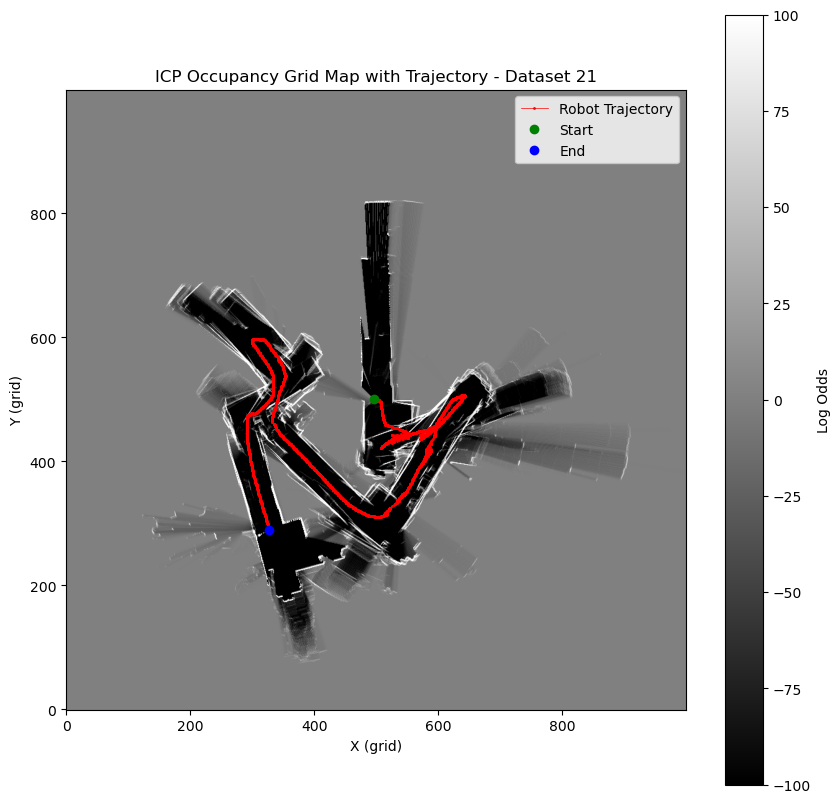

In [16]:
# Plotting with trajectory - T_icp

resolution = 0.05  # 5 cm per grid cell (meters per grid unit)
scale_factor = 1 / resolution  # Convert meters to grid units
grid_size = 1000  #Define a large fixed occupancy grid

occupancy_grid_icp = np.zeros((grid_size, grid_size), dtype=np.float32)
grid_center_x = grid_size // 2
grid_center_y = grid_size // 2

l_occupied = + 4
l_free = -0.5
l_max = 100
l_min = -100

positions_world_icp = []
robot_origin = np.array([0, 0, 1])  # Start in world coordinates (meters)

for i in range(e_time.shape[0]):
    print(f"Iteration: {i}")

    curr_origin = np.dot(T_icp[:, :, i], robot_origin)
    positions_world_icp.append(curr_origin[:2])

    robot_x_grid = np.round(curr_origin[0] * scale_factor + grid_center_x).astype(int)
    robot_y_grid = np.round(curr_origin[1] * scale_factor + grid_center_y).astype(int)

    print(f"Iteration {i}: World Position: {curr_origin[:2]} -> Grid Position: ({robot_x_grid}, {robot_y_grid})")

    ff = pc_sync[:, :, i]
    valid_mask = np.isfinite(ff).all(axis=0)  # Eliminate nan
    ff = ff[:, valid_mask]

    ff_homo = np.vstack((ff, np.ones(ff.shape[1])))
    ff_trans = T_icp[:, :, i] @ ff_homo  

    ff_trans = np.where(np.isfinite(ff_trans), ff_trans, np.nan)
    ff_trans = ff_trans[:, ~np.isnan(ff_trans).any(axis=0)]

    x_world = ff_trans[0, :]
    y_world = ff_trans[1, :]

    x_grid = np.round(x_world * scale_factor + grid_center_x).astype(int)
    y_grid = np.round(y_world * scale_factor + grid_center_y).astype(int)

    valid_mask = (x_grid >= 0) & (x_grid < grid_size) & (y_grid >= 0) & (y_grid < grid_size)
    x_valid = x_grid[valid_mask]
    y_valid = y_grid[valid_mask]

    occupancy_grid_icp[y_valid, x_valid] = np.clip(occupancy_grid_icp[y_valid, x_valid] + l_occupied, l_min, l_max)

    free_x_list = []
    free_y_list = []

    for x_end, y_end in zip(x_valid, y_valid):
        free_cells = np.array(bresenham(robot_x_grid, robot_y_grid, x_end, y_end))[:-1]  # Exclude last occupied cell
        free_x_list.append(free_cells[:, 0])
        free_y_list.append(free_cells[:, 1])

    if free_x_list:
        free_x = np.concatenate(free_x_list)
        free_y = np.concatenate(free_y_list)

        valid_free_mask = (free_x >= 0) & (free_x < grid_size) & (free_y >= 0) & (free_y < grid_size)
        free_x = free_x[valid_free_mask]
        free_y = free_y[valid_free_mask]

        occupancy_grid_icp[free_y, free_x] = np.clip(occupancy_grid_icp[free_y, free_x] + l_free, l_min, l_max)

positions_world_icp = np.array(positions_world_icp)  # Convert to NumPy array
trajectory_x = np.round(positions_world_icp[:, 0] * scale_factor + grid_center_x).astype(int)
trajectory_y = np.round(positions_world_icp[:, 1] * scale_factor + grid_center_y).astype(int)

plt.figure(figsize=(10, 10))
plt.imshow(occupancy_grid_icp, cmap="gray", origin="lower")
plt.colorbar(label="Log Odds")

plt.plot(trajectory_x, trajectory_y, 'ro-', markersize=1, linewidth=.5, label="Robot Trajectory")
plt.plot(trajectory_x[0], trajectory_y[0], 'go', markersize=6, label="Start")  # Start position (Green)
plt.plot(trajectory_x[-1], trajectory_y[-1], 'bo', markersize=6, label="End")  # End position (Blue)

plt.xlabel("X (grid)")
plt.ylabel("Y (grid)")
plt.title("ICP Occupancy Grid Map with Trajectory - Dataset " + str(dataset))
plt.legend()
plt.show()


Iteration: 0
Iteration 0: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 1
Iteration 1: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 2
Iteration 2: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 3
Iteration 3: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 4
Iteration 4: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 5
Iteration 5: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 6
Iteration 6: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 7
Iteration 7: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 8
Iteration 8: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 9
Iteration 9: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 10
Iteration 10: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 11
Iteration 11: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 12
Iteration 12: World Position: [0. 

Iteration: 104
Iteration 104: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 105
Iteration 105: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 106
Iteration 106: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 107
Iteration 107: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 108
Iteration 108: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 109
Iteration 109: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 110
Iteration 110: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 111
Iteration 111: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 112
Iteration 112: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 113
Iteration 113: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 114
Iteration 114: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 115
Iteration 115: World Position: [0. 0.] -> Grid Position: (500, 500)
Iter

Iteration: 208
Iteration 208: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 209
Iteration 209: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 210
Iteration 210: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 211
Iteration 211: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 212
Iteration 212: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 213
Iteration 213: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 214
Iteration 214: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 215
Iteration 215: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 216
Iteration 216: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 217
Iteration 217: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 218
Iteration 218: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 219
Iteration 219: World Position: [0. 0.] -> Grid Position: (500, 500)
Iter

Iteration: 312
Iteration 312: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 313
Iteration 313: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 314
Iteration 314: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 315
Iteration 315: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 316
Iteration 316: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 317
Iteration 317: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 318
Iteration 318: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 319
Iteration 319: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 320
Iteration 320: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 321
Iteration 321: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 322
Iteration 322: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 323
Iteration 323: World Position: [0. 0.] -> Grid Position: (500, 500)
Iter

Iteration: 414
Iteration 414: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 415
Iteration 415: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 416
Iteration 416: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 417
Iteration 417: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 418
Iteration 418: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 419
Iteration 419: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 420
Iteration 420: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 421
Iteration 421: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 422
Iteration 422: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 423
Iteration 423: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 424
Iteration 424: World Position: [0. 0.] -> Grid Position: (500, 500)
Iteration: 425
Iteration 425: World Position: [0. 0.] -> Grid Position: (500, 500)
Iter

Iteration: 517
Iteration 517: World Position: [ 1.00602636e-02 -6.68641847e-05] -> Grid Position: (500, 500)
Iteration: 518
Iteration 518: World Position: [ 0.01252817 -0.00015659] -> Grid Position: (500, 500)
Iteration: 519
Iteration 519: World Position: [ 0.01340414 -0.00020342] -> Grid Position: (500, 500)
Iteration: 520
Iteration 520: World Position: [ 0.01649577 -0.00041626] -> Grid Position: (500, 500)
Iteration: 521
Iteration 521: World Position: [ 0.01990484 -0.00072954] -> Grid Position: (500, 500)
Iteration: 522
Iteration 522: World Position: [ 0.02332432 -0.00109978] -> Grid Position: (500, 500)
Iteration: 523
Iteration 523: World Position: [ 0.0269316  -0.00157755] -> Grid Position: (501, 500)
Iteration: 524
Iteration 524: World Position: [ 0.03122616 -0.00222155] -> Grid Position: (501, 500)
Iteration: 525
Iteration 525: World Position: [ 0.03667026 -0.00314129] -> Grid Position: (501, 500)
Iteration: 526
Iteration 526: World Position: [ 0.04298576 -0.00438773] -> Grid Pos

Iteration: 599
Iteration 599: World Position: [ 0.40245853 -0.41075179] -> Grid Position: (508, 492)
Iteration: 600
Iteration 600: World Position: [ 0.40564163 -0.42272895] -> Grid Position: (508, 492)
Iteration: 601
Iteration 601: World Position: [ 0.40903512 -0.43551267] -> Grid Position: (508, 491)
Iteration: 602
Iteration 602: World Position: [ 0.41289865 -0.45007573] -> Grid Position: (508, 491)
Iteration: 603
Iteration 603: World Position: [ 0.41635127 -0.46310594] -> Grid Position: (508, 491)
Iteration: 604
Iteration 604: World Position: [ 0.42022603 -0.47773803] -> Grid Position: (508, 490)
Iteration: 605
Iteration 605: World Position: [ 0.42377241 -0.49112231] -> Grid Position: (508, 490)
Iteration: 606
Iteration 606: World Position: [ 0.42805748 -0.50727935] -> Grid Position: (509, 490)
Iteration: 607
Iteration 607: World Position: [ 0.43157859 -0.52053744] -> Grid Position: (509, 490)
Iteration: 608
Iteration 608: World Position: [ 0.43559062 -0.53562332] -> Grid Position: (

Iteration: 682
Iteration 682: World Position: [ 0.90629925 -1.87210892] -> Grid Position: (518, 463)
Iteration: 683
Iteration 683: World Position: [ 0.91840847 -1.88319992] -> Grid Position: (518, 462)
Iteration: 684
Iteration 684: World Position: [ 0.93170816 -1.89448733] -> Grid Position: (519, 462)
Iteration: 685
Iteration 685: World Position: [ 0.94571365 -1.90582012] -> Grid Position: (519, 462)
Iteration: 686
Iteration 686: World Position: [ 0.95934892 -1.91608725] -> Grid Position: (519, 462)
Iteration: 687
Iteration 687: World Position: [ 0.97307927 -1.92595623] -> Grid Position: (519, 461)
Iteration: 688
Iteration 688: World Position: [ 0.98781397 -1.93579718] -> Grid Position: (520, 461)
Iteration: 689
Iteration 689: World Position: [ 1.00216598 -1.94496012] -> Grid Position: (520, 461)
Iteration: 690
Iteration 690: World Position: [ 1.01716564 -1.95387503] -> Grid Position: (520, 461)
Iteration: 691
Iteration 691: World Position: [ 1.03033689 -1.96139674] -> Grid Position: (

Iteration: 769
Iteration 769: World Position: [ 2.37289073 -2.27683505] -> Grid Position: (547, 454)
Iteration: 770
Iteration 770: World Position: [ 2.39310244 -2.28081744] -> Grid Position: (548, 454)
Iteration: 771
Iteration 771: World Position: [ 2.41063284 -2.28425987] -> Grid Position: (548, 454)
Iteration: 772
Iteration 772: World Position: [ 2.43078937 -2.28822043] -> Grid Position: (549, 454)
Iteration: 773
Iteration 773: World Position: [ 2.44319072 -2.29065935] -> Grid Position: (549, 454)
Iteration: 774
Iteration 774: World Position: [ 2.46171814 -2.29430845] -> Grid Position: (549, 454)
Iteration: 775
Iteration 775: World Position: [ 2.47532282 -2.29699486] -> Grid Position: (550, 454)
Iteration: 776
Iteration 776: World Position: [ 2.49343601 -2.30057447] -> Grid Position: (550, 454)
Iteration: 777
Iteration 777: World Position: [ 2.50514415 -2.30288853] -> Grid Position: (550, 454)
Iteration: 778
Iteration 778: World Position: [ 2.52209287 -2.30624105] -> Grid Position: (

Iteration: 853
Iteration 853: World Position: [ 3.84096639 -2.56858498] -> Grid Position: (577, 449)
Iteration: 854
Iteration 854: World Position: [ 3.86780152 -2.57354165] -> Grid Position: (577, 449)
Iteration: 855
Iteration 855: World Position: [ 3.88980621 -2.57754309] -> Grid Position: (578, 448)
Iteration: 856
Iteration 856: World Position: [ 3.91186753 -2.58144298] -> Grid Position: (578, 448)
Iteration: 857
Iteration 857: World Position: [ 3.9339462  -2.58526127] -> Grid Position: (579, 448)
Iteration: 858
Iteration 858: World Position: [ 3.95598894 -2.58896084] -> Grid Position: (579, 448)
Iteration: 859
Iteration 859: World Position: [ 3.97571944 -2.59216146] -> Grid Position: (580, 448)
Iteration: 860
Iteration 860: World Position: [ 3.99618017 -2.59534006] -> Grid Position: (580, 448)
Iteration: 861
Iteration 861: World Position: [ 4.01706802 -2.59848933] -> Grid Position: (580, 448)
Iteration: 862
Iteration 862: World Position: [ 4.03861423 -2.60162371] -> Grid Position: (

Iteration: 938
Iteration 938: World Position: [ 5.2995344  -2.46943219] -> Grid Position: (606, 451)
Iteration: 939
Iteration 939: World Position: [ 5.31390314 -2.46546874] -> Grid Position: (606, 451)
Iteration: 940
Iteration 940: World Position: [ 5.33207867 -2.46059931] -> Grid Position: (607, 451)
Iteration: 941
Iteration 941: World Position: [ 5.34602993 -2.45697952] -> Grid Position: (607, 451)
Iteration: 942
Iteration 942: World Position: [ 5.36345236 -2.45255063] -> Grid Position: (607, 451)
Iteration: 943
Iteration 943: World Position: [ 5.37980064 -2.44847301] -> Grid Position: (608, 451)
Iteration: 944
Iteration 944: World Position: [ 5.39773991 -2.44405013] -> Grid Position: (608, 451)
Iteration: 945
Iteration 945: World Position: [ 5.41296172 -2.44033553] -> Grid Position: (608, 451)
Iteration: 946
Iteration 946: World Position: [ 5.4303083  -2.43617363] -> Grid Position: (609, 451)
Iteration: 947
Iteration 947: World Position: [ 5.44820493 -2.43191904] -> Grid Position: (

Iteration: 1025
Iteration 1025: World Position: [ 7.19014461 -2.33401288] -> Grid Position: (644, 453)
Iteration: 1026
Iteration 1026: World Position: [ 7.22017457 -2.33456574] -> Grid Position: (644, 453)
Iteration: 1027
Iteration 1027: World Position: [ 7.23993218 -2.33499196] -> Grid Position: (645, 453)
Iteration: 1028
Iteration 1028: World Position: [ 7.27141374 -2.33567963] -> Grid Position: (645, 453)
Iteration: 1029
Iteration 1029: World Position: [ 7.29392452 -2.3362404 ] -> Grid Position: (646, 453)
Iteration: 1030
Iteration 1030: World Position: [ 7.32271479 -2.33698383] -> Grid Position: (646, 453)
Iteration: 1031
Iteration 1031: World Position: [ 7.34208943 -2.33753753] -> Grid Position: (647, 453)
Iteration: 1032
Iteration 1032: World Position: [ 7.37362553 -2.33845401] -> Grid Position: (647, 453)
Iteration: 1033
Iteration 1033: World Position: [ 7.398041   -2.33920564] -> Grid Position: (648, 453)
Iteration: 1034
Iteration 1034: World Position: [ 7.4259906  -2.34008656]

Iteration: 1106
Iteration 1106: World Position: [ 9.33587722 -2.41710129] -> Grid Position: (687, 452)
Iteration: 1107
Iteration 1107: World Position: [ 9.35883934 -2.4180527 ] -> Grid Position: (687, 452)
Iteration: 1108
Iteration 1108: World Position: [ 9.38751826 -2.41923099] -> Grid Position: (688, 452)
Iteration: 1109
Iteration 1109: World Position: [ 9.41105647 -2.42019573] -> Grid Position: (688, 452)
Iteration: 1110
Iteration 1110: World Position: [ 9.43556342 -2.42119803] -> Grid Position: (689, 452)
Iteration: 1111
Iteration 1111: World Position: [ 9.45664995 -2.42206129] -> Grid Position: (689, 452)
Iteration: 1112
Iteration 1112: World Position: [ 9.49113004 -2.42347625] -> Grid Position: (690, 452)
Iteration: 1113
Iteration 1113: World Position: [ 9.51130889 -2.42430724] -> Grid Position: (690, 452)
Iteration: 1114
Iteration 1114: World Position: [ 9.53811546 -2.42541311] -> Grid Position: (691, 451)
Iteration: 1115
Iteration 1115: World Position: [ 9.56027579 -2.42632472]

Iteration: 1193
Iteration 1193: World Position: [10.96949766 -2.48404015] -> Grid Position: (719, 450)
Iteration: 1194
Iteration 1194: World Position: [10.99241831 -2.48505349] -> Grid Position: (720, 450)
Iteration: 1195
Iteration 1195: World Position: [11.00612896 -2.48566702] -> Grid Position: (720, 450)
Iteration: 1196
Iteration 1196: World Position: [11.02910793 -2.48670241] -> Grid Position: (721, 450)
Iteration: 1197
Iteration 1197: World Position: [11.04224465 -2.48729222] -> Grid Position: (721, 450)
Iteration: 1198
Iteration 1198: World Position: [11.06623118 -2.48835831] -> Grid Position: (721, 450)
Iteration: 1199
Iteration 1199: World Position: [11.07795924 -2.48887548] -> Grid Position: (722, 450)
Iteration: 1200
Iteration 1200: World Position: [11.09542884 -2.48963931] -> Grid Position: (722, 450)
Iteration: 1201
Iteration 1201: World Position: [11.11201519 -2.49036187] -> Grid Position: (722, 450)
Iteration: 1202
Iteration 1202: World Position: [11.12926688 -2.49110879]

Iteration: 1279
Iteration 1279: World Position: [12.52837444 -2.55433547] -> Grid Position: (751, 449)
Iteration: 1280
Iteration 1280: World Position: [12.54796213 -2.55521   ] -> Grid Position: (751, 449)
Iteration: 1281
Iteration 1281: World Position: [12.56917516 -2.55616356] -> Grid Position: (751, 449)
Iteration: 1282
Iteration 1282: World Position: [12.58847027 -2.55702865] -> Grid Position: (752, 449)
Iteration: 1283
Iteration 1283: World Position: [12.61051404 -2.55801107] -> Grid Position: (752, 449)
Iteration: 1284
Iteration 1284: World Position: [12.63048162 -2.55889958] -> Grid Position: (753, 449)
Iteration: 1285
Iteration 1285: World Position: [12.64894611 -2.5597197 ] -> Grid Position: (753, 449)
Iteration: 1286
Iteration 1286: World Position: [12.669493   -2.56063233] -> Grid Position: (753, 449)
Iteration: 1287
Iteration 1287: World Position: [12.68853248 -2.56147386] -> Grid Position: (754, 449)
Iteration: 1288
Iteration 1288: World Position: [12.70752028 -2.5623089 ]

Iteration: 1362
Iteration 1362: World Position: [14.15206621 -2.62969069] -> Grid Position: (783, 447)
Iteration: 1363
Iteration 1363: World Position: [14.17709836 -2.63085346] -> Grid Position: (784, 447)
Iteration: 1364
Iteration 1364: World Position: [14.19587447 -2.63172491] -> Grid Position: (784, 447)
Iteration: 1365
Iteration 1365: World Position: [14.22157738 -2.63291582] -> Grid Position: (784, 447)
Iteration: 1366
Iteration 1366: World Position: [14.24484479 -2.6339901 ] -> Grid Position: (785, 447)
Iteration: 1367
Iteration 1367: World Position: [14.26893968 -2.63509971] -> Grid Position: (785, 447)
Iteration: 1368
Iteration 1368: World Position: [14.28867689 -2.63600917] -> Grid Position: (786, 447)
Iteration: 1369
Iteration 1369: World Position: [14.31314272 -2.63713635] -> Grid Position: (786, 447)
Iteration: 1370
Iteration 1370: World Position: [14.33740005 -2.6382542 ] -> Grid Position: (787, 447)
Iteration: 1371
Iteration 1371: World Position: [14.36216327 -2.63939404]

Iteration: 1449
Iteration 1449: World Position: [16.34483264 -2.41278117] -> Grid Position: (827, 452)
Iteration: 1450
Iteration 1450: World Position: [16.37362799 -2.40609557] -> Grid Position: (827, 452)
Iteration: 1451
Iteration 1451: World Position: [16.40574296 -2.39862656] -> Grid Position: (828, 452)
Iteration: 1452
Iteration 1452: World Position: [16.4337038  -2.39211284] -> Grid Position: (829, 452)
Iteration: 1453
Iteration 1453: World Position: [16.46608725 -2.38455374] -> Grid Position: (829, 452)
Iteration: 1454
Iteration 1454: World Position: [16.49602223 -2.37754103] -> Grid Position: (830, 452)
Iteration: 1455
Iteration 1455: World Position: [16.52670772 -2.37034571] -> Grid Position: (831, 453)
Iteration: 1456
Iteration 1456: World Position: [16.55928827 -2.36271603] -> Grid Position: (831, 453)
Iteration: 1457
Iteration 1457: World Position: [16.59041591 -2.35543326] -> Grid Position: (832, 453)
Iteration: 1458
Iteration 1458: World Position: [16.6213111  -2.34819833]

Iteration: 1535
Iteration 1535: World Position: [19.02503282 -1.94779009] -> Grid Position: (881, 461)
Iteration: 1536
Iteration 1536: World Position: [19.04825951 -1.95175864] -> Grid Position: (881, 461)
Iteration: 1537
Iteration 1537: World Position: [19.06919249 -1.9553273 ] -> Grid Position: (881, 461)
Iteration: 1538
Iteration 1538: World Position: [19.0903424  -1.95893385] -> Grid Position: (882, 461)
Iteration: 1539
Iteration 1539: World Position: [19.11532372 -1.96319274] -> Grid Position: (882, 461)
Iteration: 1540
Iteration 1540: World Position: [19.12770634 -1.96530292] -> Grid Position: (883, 461)
Iteration: 1541
Iteration 1541: World Position: [19.15135441 -1.96933748] -> Grid Position: (883, 461)
Iteration: 1542
Iteration 1542: World Position: [19.16389832 -1.9714824 ] -> Grid Position: (883, 461)
Iteration: 1543
Iteration 1543: World Position: [19.18427928 -1.97497309] -> Grid Position: (884, 461)
Iteration: 1544
Iteration 1544: World Position: [19.19805726 -1.97734399]

Iteration: 1624
Iteration 1624: World Position: [19.94941197 -2.62380841] -> Grid Position: (899, 448)
Iteration: 1625
Iteration 1625: World Position: [19.94924196 -2.63158789] -> Grid Position: (899, 447)
Iteration: 1626
Iteration 1626: World Position: [19.94895022 -2.6375652 ] -> Grid Position: (899, 447)
Iteration: 1627
Iteration 1627: World Position: [19.948301   -2.64661909] -> Grid Position: (899, 447)
Iteration: 1628
Iteration 1628: World Position: [19.9477365  -2.65206446] -> Grid Position: (899, 447)
Iteration: 1629
Iteration 1629: World Position: [19.94661137 -2.66077791] -> Grid Position: (899, 447)
Iteration: 1630
Iteration 1630: World Position: [19.94599057 -2.66472441] -> Grid Position: (899, 447)
Iteration: 1631
Iteration 1631: World Position: [19.94476749 -2.67148104] -> Grid Position: (899, 447)
Iteration: 1632
Iteration 1632: World Position: [19.94400375 -2.67495892] -> Grid Position: (899, 447)
Iteration: 1633
Iteration 1633: World Position: [19.94249743 -2.68099808]

Iteration: 1712
Iteration 1712: World Position: [19.06094685 -2.71665948] -> Grid Position: (881, 446)
Iteration: 1713
Iteration 1713: World Position: [19.01498519 -2.71482041] -> Grid Position: (880, 446)
Iteration: 1714
Iteration 1714: World Position: [19.0007082 -2.7142507] -> Grid Position: (880, 446)
Iteration: 1715
Iteration 1715: World Position: [18.94961547 -2.71221442] -> Grid Position: (879, 446)
Iteration: 1716
Iteration 1716: World Position: [18.9175778  -2.71094723] -> Grid Position: (878, 446)
Iteration: 1717
Iteration 1717: World Position: [18.88735067 -2.70977513] -> Grid Position: (878, 446)
Iteration: 1718
Iteration 1718: World Position: [18.85468323 -2.70857874] -> Grid Position: (877, 446)
Iteration: 1719
Iteration 1719: World Position: [18.81834043 -2.70734025] -> Grid Position: (876, 446)
Iteration: 1720
Iteration 1720: World Position: [18.79717636 -2.7066668 ] -> Grid Position: (876, 446)
Iteration: 1721
Iteration 1721: World Position: [18.738887   -2.70502042] -

Iteration: 1796
Iteration 1796: World Position: [16.24088541 -2.70411064] -> Grid Position: (825, 446)
Iteration: 1797
Iteration 1797: World Position: [16.19625852 -2.70436318] -> Grid Position: (824, 446)
Iteration: 1798
Iteration 1798: World Position: [16.18324631 -2.70443231] -> Grid Position: (824, 446)
Iteration: 1799
Iteration 1799: World Position: [16.13071556 -2.70470989] -> Grid Position: (823, 446)
Iteration: 1800
Iteration 1800: World Position: [16.0937107  -2.70491072] -> Grid Position: (822, 446)
Iteration: 1801
Iteration 1801: World Position: [16.06553228 -2.70506803] -> Grid Position: (821, 446)
Iteration: 1802
Iteration 1802: World Position: [16.02809199 -2.70528053] -> Grid Position: (821, 446)
Iteration: 1803
Iteration 1803: World Position: [15.99685397 -2.70546473] -> Grid Position: (820, 446)
Iteration: 1804
Iteration 1804: World Position: [15.97226608 -2.70561698] -> Grid Position: (819, 446)
Iteration: 1805
Iteration 1805: World Position: [15.92510219 -2.70591934]

Iteration: 1882
Iteration 1882: World Position: [13.87842385 -2.97728456] -> Grid Position: (778, 440)
Iteration: 1883
Iteration 1883: World Position: [13.86386944 -2.98489592] -> Grid Position: (777, 440)
Iteration: 1884
Iteration 1884: World Position: [13.84792364 -2.9930883 ] -> Grid Position: (777, 440)
Iteration: 1885
Iteration 1885: World Position: [13.82700954 -3.00367529] -> Grid Position: (777, 440)
Iteration: 1886
Iteration 1886: World Position: [13.81164058 -3.01123024] -> Grid Position: (776, 440)
Iteration: 1887
Iteration 1887: World Position: [13.79571644 -3.01885817] -> Grid Position: (776, 440)
Iteration: 1888
Iteration 1888: World Position: [13.7739245 -3.0289412] -> Grid Position: (775, 439)
Iteration: 1889
Iteration 1889: World Position: [13.7594587  -3.03551236] -> Grid Position: (775, 439)
Iteration: 1890
Iteration 1890: World Position: [13.74325618 -3.0428314 ] -> Grid Position: (775, 439)
Iteration: 1891
Iteration 1891: World Position: [13.7167344  -3.05477823] -

Iteration: 1963
Iteration 1963: World Position: [12.77725622 -3.3994401 ] -> Grid Position: (756, 432)
Iteration: 1964
Iteration 1964: World Position: [12.77099198 -3.401564  ] -> Grid Position: (755, 432)
Iteration: 1965
Iteration 1965: World Position: [12.74893814 -3.40903317] -> Grid Position: (755, 432)
Iteration: 1966
Iteration 1966: World Position: [12.74191774 -3.41140944] -> Grid Position: (755, 432)
Iteration: 1967
Iteration 1967: World Position: [12.71963098 -3.41895469] -> Grid Position: (754, 432)
Iteration: 1968
Iteration 1968: World Position: [12.71247142 -3.42137896] -> Grid Position: (754, 432)
Iteration: 1969
Iteration 1969: World Position: [12.69687149 -3.4266618 ] -> Grid Position: (754, 431)
Iteration: 1970
Iteration 1970: World Position: [12.68340441 -3.43122066] -> Grid Position: (754, 431)
Iteration: 1971
Iteration 1971: World Position: [12.66509333 -3.43741195] -> Grid Position: (753, 431)
Iteration: 1972
Iteration 1972: World Position: [12.65573312 -3.44057153]

Iteration: 2053
Iteration 2053: World Position: [11.55798143 -3.70659831] -> Grid Position: (731, 426)
Iteration: 2054
Iteration 2054: World Position: [11.54737282 -3.70819592] -> Grid Position: (731, 426)
Iteration: 2055
Iteration 2055: World Position: [11.53486392 -3.7100986 ] -> Grid Position: (731, 426)
Iteration: 2056
Iteration 2056: World Position: [11.5236196  -3.71181297] -> Grid Position: (730, 426)
Iteration: 2057
Iteration 2057: World Position: [11.50948659 -3.71396673] -> Grid Position: (730, 426)
Iteration: 2058
Iteration 2058: World Position: [11.494683   -3.71621288] -> Grid Position: (730, 426)
Iteration: 2059
Iteration 2059: World Position: [11.48778441 -3.71725357] -> Grid Position: (730, 426)
Iteration: 2060
Iteration 2060: World Position: [11.47060423 -3.71984044] -> Grid Position: (729, 426)
Iteration: 2061
Iteration 2061: World Position: [11.45786309 -3.72175273] -> Grid Position: (729, 426)
Iteration: 2062
Iteration 2062: World Position: [11.44386923 -3.72385216]

Iteration: 2143
Iteration 2143: World Position: [10.14160084 -3.90305256] -> Grid Position: (703, 422)
Iteration: 2144
Iteration 2144: World Position: [10.12053916 -3.90545914] -> Grid Position: (702, 422)
Iteration: 2145
Iteration 2145: World Position: [10.10420043 -3.90730637] -> Grid Position: (702, 422)
Iteration: 2146
Iteration 2146: World Position: [10.09493475 -3.90834565] -> Grid Position: (702, 422)
Iteration: 2147
Iteration 2147: World Position: [10.07157034 -3.91094096] -> Grid Position: (701, 422)
Iteration: 2148
Iteration 2148: World Position: [10.05473375 -3.91279131] -> Grid Position: (701, 422)
Iteration: 2149
Iteration 2149: World Position: [10.03827336 -3.91459612] -> Grid Position: (701, 422)
Iteration: 2150
Iteration 2150: World Position: [10.02169033 -3.91641099] -> Grid Position: (700, 422)
Iteration: 2151
Iteration 2151: World Position: [ 9.99317123 -3.91950337] -> Grid Position: (700, 422)
Iteration: 2152
Iteration 2152: World Position: [ 9.97513804 -3.92144306]

Iteration: 2234
Iteration 2234: World Position: [ 7.72417901 -4.12020339] -> Grid Position: (654, 418)
Iteration: 2235
Iteration 2235: World Position: [ 7.6950629  -4.12310656] -> Grid Position: (654, 418)
Iteration: 2236
Iteration 2236: World Position: [ 7.65682246 -4.1271076 ] -> Grid Position: (653, 417)
Iteration: 2237
Iteration 2237: World Position: [ 7.63193126 -4.12990962] -> Grid Position: (653, 417)
Iteration: 2238
Iteration 2238: World Position: [ 7.59026286 -4.13488286] -> Grid Position: (652, 417)
Iteration: 2239
Iteration 2239: World Position: [ 7.56305341 -4.13839209] -> Grid Position: (651, 417)
Iteration: 2240
Iteration 2240: World Position: [ 7.51413232 -4.14509352] -> Grid Position: (650, 417)
Iteration: 2241
Iteration 2241: World Position: [ 7.49854344 -4.14735591] -> Grid Position: (650, 417)
Iteration: 2242
Iteration 2242: World Position: [ 7.4238164  -4.15896181] -> Grid Position: (648, 417)
Iteration: 2243
Iteration 2243: World Position: [ 7.41042822 -4.16113832]

Iteration: 2316
Iteration 2316: World Position: [ 4.60360958 -4.66833992] -> Grid Position: (592, 407)
Iteration: 2317
Iteration 2317: World Position: [ 4.57893496 -4.66883049] -> Grid Position: (592, 407)
Iteration: 2318
Iteration 2318: World Position: [ 4.53797285 -4.66845636] -> Grid Position: (591, 407)
Iteration: 2319
Iteration 2319: World Position: [ 4.50933812 -4.66736874] -> Grid Position: (590, 407)
Iteration: 2320
Iteration 2320: World Position: [ 4.47009921 -4.66512635] -> Grid Position: (589, 407)
Iteration: 2321
Iteration 2321: World Position: [ 4.45049591 -4.663761  ] -> Grid Position: (589, 407)
Iteration: 2322
Iteration 2322: World Position: [ 4.4078481  -4.66066782] -> Grid Position: (588, 407)
Iteration: 2323
Iteration 2323: World Position: [ 4.38581194 -4.65900872] -> Grid Position: (588, 407)
Iteration: 2324
Iteration 2324: World Position: [ 4.32644884 -4.65461223] -> Grid Position: (587, 407)
Iteration: 2325
Iteration 2325: World Position: [ 4.31833649 -4.6540201 ]

Iteration: 2398
Iteration 2398: World Position: [ 2.76920934 -4.53221953] -> Grid Position: (555, 409)
Iteration: 2399
Iteration 2399: World Position: [ 2.76140526 -4.53155043] -> Grid Position: (555, 409)
Iteration: 2400
Iteration 2400: World Position: [ 2.73444283 -4.52922773] -> Grid Position: (555, 409)
Iteration: 2401
Iteration 2401: World Position: [ 2.72124367 -4.52809047] -> Grid Position: (554, 409)
Iteration: 2402
Iteration 2402: World Position: [ 2.70475666 -4.52667081] -> Grid Position: (554, 409)
Iteration: 2403
Iteration 2403: World Position: [ 2.69034846 -4.52542939] -> Grid Position: (554, 409)
Iteration: 2404
Iteration 2404: World Position: [ 2.67940471 -4.52448513] -> Grid Position: (554, 410)
Iteration: 2405
Iteration 2405: World Position: [ 2.65623379 -4.52247833] -> Grid Position: (553, 410)
Iteration: 2406
Iteration 2406: World Position: [ 2.63659602 -4.52076692] -> Grid Position: (553, 410)
Iteration: 2407
Iteration 2407: World Position: [ 2.62514261 -4.51976398]

Iteration: 2484
Iteration 2484: World Position: [ 0.98494042 -4.37355379] -> Grid Position: (520, 413)
Iteration: 2485
Iteration 2485: World Position: [ 0.97053864 -4.37226312] -> Grid Position: (519, 413)
Iteration: 2486
Iteration 2486: World Position: [ 0.94715911 -4.37016996] -> Grid Position: (519, 413)
Iteration: 2487
Iteration 2487: World Position: [ 0.91773327 -4.36753574] -> Grid Position: (518, 413)
Iteration: 2488
Iteration 2488: World Position: [ 0.83703809 -4.36032002] -> Grid Position: (517, 413)
Iteration: 2489
Iteration 2489: World Position: [ 0.82498929 -4.35924285] -> Grid Position: (516, 413)
Iteration: 2490
Iteration 2490: World Position: [ 0.79615257 -4.35666502] -> Grid Position: (516, 413)
Iteration: 2491
Iteration 2491: World Position: [ 0.78297835 -4.35548628] -> Grid Position: (516, 413)
Iteration: 2492
Iteration 2492: World Position: [ 0.75799527 -4.35324401] -> Grid Position: (515, 413)
Iteration: 2493
Iteration 2493: World Position: [ 0.74131197 -4.35174558]

Iteration: 2570
Iteration 2570: World Position: [-0.67923525 -3.7027541 ] -> Grid Position: (486, 426)
Iteration: 2571
Iteration 2571: World Position: [-0.69146479 -3.6878747 ] -> Grid Position: (486, 426)
Iteration: 2572
Iteration 2572: World Position: [-0.71012827 -3.6647292 ] -> Grid Position: (486, 427)
Iteration: 2573
Iteration 2573: World Position: [-0.72240379 -3.64918674] -> Grid Position: (486, 427)
Iteration: 2574
Iteration 2574: World Position: [-0.74708143 -3.61733645] -> Grid Position: (485, 428)
Iteration: 2575
Iteration 2575: World Position: [-0.75686313 -3.6043426 ] -> Grid Position: (485, 428)
Iteration: 2576
Iteration 2576: World Position: [-0.77746144 -3.57633516] -> Grid Position: (484, 428)
Iteration: 2577
Iteration 2577: World Position: [-0.7920151  -3.55619481] -> Grid Position: (484, 429)
Iteration: 2578
Iteration 2578: World Position: [-0.81066402 -3.52951936] -> Grid Position: (484, 429)
Iteration: 2579
Iteration 2579: World Position: [-0.81800915 -3.51874964]

Iteration: 2657
Iteration 2657: World Position: [-1.50488206 -1.37635837] -> Grid Position: (470, 472)
Iteration: 2658
Iteration 2658: World Position: [-1.51138208 -1.34764941] -> Grid Position: (470, 473)
Iteration: 2659
Iteration 2659: World Position: [-1.51801982 -1.31822993] -> Grid Position: (470, 474)
Iteration: 2660
Iteration 2660: World Position: [-1.52845106 -1.27191911] -> Grid Position: (469, 475)
Iteration: 2661
Iteration 2661: World Position: [-1.53446428 -1.24516528] -> Grid Position: (469, 475)
Iteration: 2662
Iteration 2662: World Position: [-1.54061924 -1.21770078] -> Grid Position: (469, 476)
Iteration: 2663
Iteration 2663: World Position: [-1.5481928  -1.18377548] -> Grid Position: (469, 476)
Iteration: 2664
Iteration 2664: World Position: [-1.55574816 -1.14985681] -> Grid Position: (469, 477)
Iteration: 2665
Iteration 2665: World Position: [-1.56233906 -1.12016708] -> Grid Position: (469, 478)
Iteration: 2666
Iteration 2666: World Position: [-1.56820143 -1.09370604]

Iteration: 2746
Iteration 2746: World Position: [-1.98434495  1.51732659] -> Grid Position: (460, 530)
Iteration: 2747
Iteration 2747: World Position: [-1.98764353  1.54153564] -> Grid Position: (460, 531)
Iteration: 2748
Iteration 2748: World Position: [-1.99470543  1.59322352] -> Grid Position: (460, 532)
Iteration: 2749
Iteration 2749: World Position: [-1.99732131  1.61239071] -> Grid Position: (460, 532)
Iteration: 2750
Iteration 2750: World Position: [-2.00315657  1.65521533] -> Grid Position: (460, 533)
Iteration: 2751
Iteration 2751: World Position: [-2.00671495  1.68138177] -> Grid Position: (460, 534)
Iteration: 2752
Iteration 2752: World Position: [-2.01314396  1.72874401] -> Grid Position: (460, 535)
Iteration: 2753
Iteration 2753: World Position: [-2.01590472  1.74908031] -> Grid Position: (460, 535)
Iteration: 2754
Iteration 2754: World Position: [-2.02171882  1.79188247] -> Grid Position: (460, 536)
Iteration: 2755
Iteration 2755: World Position: [-2.02519562  1.81748138]

Iteration: 2834
Iteration 2834: World Position: [-2.39865709  4.63970695] -> Grid Position: (452, 593)
Iteration: 2835
Iteration 2835: World Position: [-2.40458293  4.68467114] -> Grid Position: (452, 594)
Iteration: 2836
Iteration 2836: World Position: [-2.40829512  4.71284427] -> Grid Position: (452, 594)
Iteration: 2837
Iteration 2837: World Position: [-2.41260895  4.74556716] -> Grid Position: (452, 595)
Iteration: 2838
Iteration 2838: World Position: [-2.41695888  4.77851718] -> Grid Position: (452, 596)
Iteration: 2839
Iteration 2839: World Position: [-2.42286484  4.82319673] -> Grid Position: (452, 596)
Iteration: 2840
Iteration 2840: World Position: [-2.42528956  4.84156818] -> Grid Position: (451, 597)
Iteration: 2841
Iteration 2841: World Position: [-2.43056496  4.88167957] -> Grid Position: (451, 598)
Iteration: 2842
Iteration 2842: World Position: [-2.43478838  4.91388589] -> Grid Position: (451, 598)
Iteration: 2843
Iteration 2843: World Position: [-2.44026793  4.95581413]

Iteration: 2916
Iteration 2916: World Position: [-2.75913204  7.42338081] -> Grid Position: (445, 648)
Iteration: 2917
Iteration 2917: World Position: [-2.7635289   7.45658772] -> Grid Position: (445, 649)
Iteration: 2918
Iteration 2918: World Position: [-2.76840831  7.49326831] -> Grid Position: (445, 650)
Iteration: 2919
Iteration 2919: World Position: [-2.77326064  7.52959011] -> Grid Position: (445, 651)
Iteration: 2920
Iteration 2920: World Position: [-2.77657553  7.5543738 ] -> Grid Position: (444, 651)
Iteration: 2921
Iteration 2921: World Position: [-2.78201747  7.59509482] -> Grid Position: (444, 652)
Iteration: 2922
Iteration 2922: World Position: [-2.78549743  7.62115401] -> Grid Position: (444, 652)
Iteration: 2923
Iteration 2923: World Position: [-2.79157962  7.66670424] -> Grid Position: (444, 653)
Iteration: 2924
Iteration 2924: World Position: [-2.79374673  7.68294408] -> Grid Position: (444, 654)
Iteration: 2925
Iteration 2925: World Position: [-2.80093475  7.73690803]

Iteration: 2997
Iteration 2997: World Position: [-3.11712752 10.19100066] -> Grid Position: (438, 704)
Iteration: 2998
Iteration 2998: World Position: [-3.12050569 10.21715369] -> Grid Position: (438, 704)
Iteration: 2999
Iteration 2999: World Position: [-3.12510734 10.25295691] -> Grid Position: (437, 705)
Iteration: 3000
Iteration 3000: World Position: [-3.12830065 10.27790625] -> Grid Position: (437, 706)
Iteration: 3001
Iteration 3001: World Position: [-3.134201   10.32410906] -> Grid Position: (437, 706)
Iteration: 3002
Iteration 3002: World Position: [-3.1375316  10.35019866] -> Grid Position: (437, 707)
Iteration: 3003
Iteration 3003: World Position: [-3.14227502 10.38740486] -> Grid Position: (437, 708)
Iteration: 3004
Iteration 3004: World Position: [-3.14537518 10.41173568] -> Grid Position: (437, 708)
Iteration: 3005
Iteration 3005: World Position: [-3.1510196  10.45597566] -> Grid Position: (437, 709)
Iteration: 3006
Iteration 3006: World Position: [-3.15471492 10.48494603]

Iteration: 3083
Iteration 3083: World Position: [-3.31899307 12.9974755 ] -> Grid Position: (434, 760)
Iteration: 3084
Iteration 3084: World Position: [-3.31539744 13.0162682 ] -> Grid Position: (434, 760)
Iteration: 3085
Iteration 3085: World Position: [-3.30849219 13.04870292] -> Grid Position: (434, 761)
Iteration: 3086
Iteration 3086: World Position: [-3.3040522  13.06791717] -> Grid Position: (434, 761)
Iteration: 3087
Iteration 3087: World Position: [-3.29363876 13.10877059] -> Grid Position: (434, 762)
Iteration: 3088
Iteration 3088: World Position: [-3.28886849 13.12589062] -> Grid Position: (434, 763)
Iteration: 3089
Iteration 3089: World Position: [-3.27951413 13.15733247] -> Grid Position: (434, 763)
Iteration: 3090
Iteration 3090: World Position: [-3.27348072 13.17616518] -> Grid Position: (435, 764)
Iteration: 3091
Iteration 3091: World Position: [-3.26175149 13.21041345] -> Grid Position: (435, 764)
Iteration: 3092
Iteration 3092: World Position: [-3.2542891  13.23059534]

Iteration: 3168
Iteration 3168: World Position: [-1.78294113 14.36796143] -> Grid Position: (464, 787)
Iteration: 3169
Iteration 3169: World Position: [-1.75088824 14.38426061] -> Grid Position: (465, 788)
Iteration: 3170
Iteration 3170: World Position: [-1.73582817 14.39196047] -> Grid Position: (465, 788)
Iteration: 3171
Iteration 3171: World Position: [-1.69362724 14.41368234] -> Grid Position: (466, 788)
Iteration: 3172
Iteration 3172: World Position: [-1.66353425 14.4293193 ] -> Grid Position: (467, 789)
Iteration: 3173
Iteration 3173: World Position: [-1.63220925 14.44568378] -> Grid Position: (467, 789)
Iteration: 3174
Iteration 3174: World Position: [-1.61851676 14.45286024] -> Grid Position: (468, 789)
Iteration: 3175
Iteration 3175: World Position: [-1.57858423 14.47381691] -> Grid Position: (468, 789)
Iteration: 3176
Iteration 3176: World Position: [-1.55214543 14.4876995 ] -> Grid Position: (469, 790)
Iteration: 3177
Iteration 3177: World Position: [-1.5257094  14.50158438]

Iteration: 3252
Iteration 3252: World Position: [ 0.65761644 15.65513236] -> Grid Position: (513, 813)
Iteration: 3253
Iteration 3253: World Position: [ 0.70018751 15.68180556] -> Grid Position: (514, 814)
Iteration: 3254
Iteration 3254: World Position: [ 0.71892431 15.69400593] -> Grid Position: (514, 814)
Iteration: 3255
Iteration 3255: World Position: [ 0.75165868 15.71612821] -> Grid Position: (515, 814)
Iteration: 3256
Iteration 3256: World Position: [ 0.77137062 15.73008561] -> Grid Position: (515, 815)
Iteration: 3257
Iteration 3257: World Position: [ 0.81153665 15.75978697] -> Grid Position: (516, 815)
Iteration: 3258
Iteration 3258: World Position: [ 0.82876292 15.7730857 ] -> Grid Position: (517, 815)
Iteration: 3259
Iteration 3259: World Position: [ 0.85874223 15.79721544] -> Grid Position: (517, 816)
Iteration: 3260
Iteration 3260: World Position: [ 0.87643312 15.8121996 ] -> Grid Position: (518, 816)
Iteration: 3261
Iteration 3261: World Position: [ 0.91165421 15.84350423]

Iteration: 3334
Iteration 3334: World Position: [ 1.55261062 17.51131105] -> Grid Position: (531, 850)
Iteration: 3335
Iteration 3335: World Position: [ 1.55379981 17.53867384] -> Grid Position: (531, 851)
Iteration: 3336
Iteration 3336: World Position: [ 1.55449768 17.55602243] -> Grid Position: (531, 851)
Iteration: 3337
Iteration 3337: World Position: [ 1.55558716 17.58442902] -> Grid Position: (531, 852)
Iteration: 3338
Iteration 3338: World Position: [ 1.55642187 17.60714356] -> Grid Position: (531, 852)
Iteration: 3339
Iteration 3339: World Position: [ 1.55728    17.63105779] -> Grid Position: (531, 853)
Iteration: 3340
Iteration 3340: World Position: [ 1.55787108 17.64803973] -> Grid Position: (531, 853)
Iteration: 3341
Iteration 3341: World Position: [ 1.55891414 17.67841957] -> Grid Position: (531, 854)
Iteration: 3342
Iteration 3342: World Position: [ 1.55961428 17.69860116] -> Grid Position: (531, 854)
Iteration: 3343
Iteration 3343: World Position: [ 1.56054775 17.7251359 ]

Iteration: 3414
Iteration 3414: World Position: [ 1.65251395 20.16379785] -> Grid Position: (533, 903)
Iteration: 3415
Iteration 3415: World Position: [ 1.65131545 20.20124252] -> Grid Position: (533, 904)
Iteration: 3416
Iteration 3416: World Position: [ 1.64966409 20.23127782] -> Grid Position: (533, 905)
Iteration: 3417
Iteration 3417: World Position: [ 1.64856858 20.24646487] -> Grid Position: (533, 905)
Iteration: 3418
Iteration 3418: World Position: [ 1.64793359 20.25399103] -> Grid Position: (533, 905)
Iteration: 3419
Iteration 3419: World Position: [ 1.64453345 20.29409457] -> Grid Position: (533, 906)
Iteration: 3420
Iteration 3420: World Position: [ 1.63424499 20.41006708] -> Grid Position: (533, 908)
Iteration: 3421
Iteration 3421: World Position: [ 1.63341529 20.41852906] -> Grid Position: (533, 908)
Iteration: 3422
Iteration 3422: World Position: [ 1.61603939 20.58369214] -> Grid Position: (532, 912)
Iteration: 3423
Iteration 3423: World Position: [ 1.60358849 20.67137958]

Iteration: 3498
Iteration 3498: World Position: [ 0.08242048 21.81742787] -> Grid Position: (502, 936)
Iteration: 3499
Iteration 3499: World Position: [ 0.06779151 21.81158043] -> Grid Position: (501, 936)
Iteration: 3500
Iteration 3500: World Position: [ 0.05592018 21.80655743] -> Grid Position: (501, 936)
Iteration: 3501
Iteration 3501: World Position: [ 0.04337993 21.80124118] -> Grid Position: (501, 936)
Iteration: 3502
Iteration 3502: World Position: [-2.13194045e-02  2.17727265e+01] -> Grid Position: (500, 935)
Iteration: 3503
Iteration 3503: World Position: [-0.04134389 21.7620751 ] -> Grid Position: (499, 935)
Iteration: 3504
Iteration 3504: World Position: [-0.04815503 21.75804969] -> Grid Position: (499, 935)
Iteration: 3505
Iteration 3505: World Position: [-0.05707815 21.752108  ] -> Grid Position: (499, 935)
Iteration: 3506
Iteration 3506: World Position: [-0.06299317 21.74770227] -> Grid Position: (499, 935)
Iteration: 3507
Iteration 3507: World Position: [-0.07043588 21.7

Iteration: 3581
Iteration 3581: World Position: [-0.17480867 20.27887628] -> Grid Position: (497, 906)
Iteration: 3582
Iteration 3582: World Position: [-0.17572209 20.25092944] -> Grid Position: (496, 905)
Iteration: 3583
Iteration 3583: World Position: [-0.17738862 20.20119086] -> Grid Position: (496, 904)
Iteration: 3584
Iteration 3584: World Position: [-0.17777333 20.18994783] -> Grid Position: (496, 904)
Iteration: 3585
Iteration 3585: World Position: [-0.18022824 20.11898371] -> Grid Position: (496, 902)
Iteration: 3586
Iteration 3586: World Position: [-0.18127147 20.08946473] -> Grid Position: (496, 902)
Iteration: 3587
Iteration 3587: World Position: [-0.1821266  20.06565108] -> Grid Position: (496, 901)
Iteration: 3588
Iteration 3588: World Position: [-0.18371546 20.0221458 ] -> Grid Position: (496, 900)
Iteration: 3589
Iteration 3589: World Position: [-0.18475823 19.99398216] -> Grid Position: (496, 900)
Iteration: 3590
Iteration 3590: World Position: [-0.1863581 19.9511325] -

Iteration: 3662
Iteration 3662: World Position: [-0.87729912 17.10948739] -> Grid Position: (482, 842)
Iteration: 3663
Iteration 3663: World Position: [-0.87882999 17.10706358] -> Grid Position: (482, 842)
Iteration: 3664
Iteration 3664: World Position: [-0.89448846 17.08227276] -> Grid Position: (482, 842)
Iteration: 3665
Iteration 3665: World Position: [-0.90129976 17.07148836] -> Grid Position: (482, 841)
Iteration: 3666
Iteration 3666: World Position: [-0.91681075 17.04692958] -> Grid Position: (482, 841)
Iteration: 3667
Iteration 3667: World Position: [-0.92584609 17.03262384] -> Grid Position: (481, 841)
Iteration: 3668
Iteration 3668: World Position: [-0.94227456 17.00661128] -> Grid Position: (481, 840)
Iteration: 3669
Iteration 3669: World Position: [-0.95151857 16.99197445] -> Grid Position: (481, 840)
Iteration: 3670
Iteration 3670: World Position: [-0.96831143 16.96538493] -> Grid Position: (481, 839)
Iteration: 3671
Iteration 3671: World Position: [-0.97738914 16.9510118 ]

Iteration: 3751
Iteration 3751: World Position: [-2.76230263 15.28669384] -> Grid Position: (445, 806)
Iteration: 3752
Iteration 3752: World Position: [-2.78129238 15.27888684] -> Grid Position: (444, 806)
Iteration: 3753
Iteration 3753: World Position: [-2.80006782 15.27116763] -> Grid Position: (444, 805)
Iteration: 3754
Iteration 3754: World Position: [-2.81478066 15.26512488] -> Grid Position: (444, 805)
Iteration: 3755
Iteration 3755: World Position: [-2.82739773 15.25994747] -> Grid Position: (443, 805)
Iteration: 3756
Iteration 3756: World Position: [-2.84986187 15.25074066] -> Grid Position: (443, 805)
Iteration: 3757
Iteration 3757: World Position: [-2.86253348 15.24554982] -> Grid Position: (443, 805)
Iteration: 3758
Iteration 3758: World Position: [-2.88202018 15.23756205] -> Grid Position: (442, 805)
Iteration: 3759
Iteration 3759: World Position: [-2.90025847 15.23008472] -> Grid Position: (442, 805)
Iteration: 3760
Iteration 3760: World Position: [-2.91776528 15.22291247]

Iteration: 3842
Iteration 3842: World Position: [-5.19351909 14.17534572] -> Grid Position: (396, 784)
Iteration: 3843
Iteration 3843: World Position: [-5.20653902 14.15353518] -> Grid Position: (396, 783)
Iteration: 3844
Iteration 3844: World Position: [-5.21574968 14.13599778] -> Grid Position: (396, 783)
Iteration: 3845
Iteration 3845: World Position: [-5.22454897 14.1176015 ] -> Grid Position: (396, 782)
Iteration: 3846
Iteration 3846: World Position: [-5.23132802 14.10135341] -> Grid Position: (395, 782)
Iteration: 3847
Iteration 3847: World Position: [-5.23697468 14.08645063] -> Grid Position: (395, 782)
Iteration: 3848
Iteration 3848: World Position: [-5.24122563 14.07367232] -> Grid Position: (395, 781)
Iteration: 3849
Iteration 3849: World Position: [-5.24573256 14.05888696] -> Grid Position: (395, 781)
Iteration: 3850
Iteration 3850: World Position: [-5.24956586 14.04518624] -> Grid Position: (395, 781)
Iteration: 3851
Iteration 3851: World Position: [-5.25302613 14.03142925]

Iteration: 3930
Iteration 3930: World Position: [-5.54917133 11.95662528] -> Grid Position: (389, 739)
Iteration: 3931
Iteration 3931: World Position: [-5.550604   11.92089977] -> Grid Position: (389, 738)
Iteration: 3932
Iteration 3932: World Position: [-5.55212903 11.8830331 ] -> Grid Position: (389, 738)
Iteration: 3933
Iteration 3933: World Position: [-5.55240726 11.87612217] -> Grid Position: (389, 738)
Iteration: 3934
Iteration 3934: World Position: [-5.5536786  11.84449193] -> Grid Position: (389, 737)
Iteration: 3935
Iteration 3935: World Position: [-5.55393834 11.83802204] -> Grid Position: (389, 737)
Iteration: 3936
Iteration 3936: World Position: [-5.56119628 11.65752251] -> Grid Position: (389, 733)
Iteration: 3937
Iteration 3937: World Position: [-5.5623656  11.62862396] -> Grid Position: (389, 733)
Iteration: 3938
Iteration 3938: World Position: [-5.56334363 11.60484868] -> Grid Position: (389, 732)
Iteration: 3939
Iteration 3939: World Position: [-5.56446876 11.57772236]

Iteration: 4012
Iteration 4012: World Position: [-5.63279472  9.2426438 ] -> Grid Position: (387, 685)
Iteration: 4013
Iteration 4013: World Position: [-5.63339283  9.21228716] -> Grid Position: (387, 684)
Iteration: 4014
Iteration 4014: World Position: [-5.63418186  9.17135859] -> Grid Position: (387, 683)
Iteration: 4015
Iteration 4015: World Position: [-5.63462262  9.14787758] -> Grid Position: (387, 683)
Iteration: 4016
Iteration 4016: World Position: [-5.63536066  9.10781163] -> Grid Position: (387, 682)
Iteration: 4017
Iteration 4017: World Position: [-5.63588562  9.0782489 ] -> Grid Position: (387, 682)
Iteration: 4018
Iteration 4018: World Position: [-5.63657245  9.03818053] -> Grid Position: (387, 681)
Iteration: 4019
Iteration 4019: World Position: [-5.63694502  9.01597216] -> Grid Position: (387, 680)
Iteration: 4020
Iteration 4020: World Position: [-5.63765882  8.973494  ] -> Grid Position: (387, 679)
Iteration: 4021
Iteration 4021: World Position: [-5.63818211  8.94286762]

Iteration: 4093
Iteration 4093: World Position: [-5.67552366  6.58778334] -> Grid Position: (386, 632)
Iteration: 4094
Iteration 4094: World Position: [-5.67590892  6.55865078] -> Grid Position: (386, 631)
Iteration: 4095
Iteration 4095: World Position: [-5.67634984  6.52435772] -> Grid Position: (386, 630)
Iteration: 4096
Iteration 4096: World Position: [-5.67677428  6.4902575 ] -> Grid Position: (386, 630)
Iteration: 4097
Iteration 4097: World Position: [-5.67719384  6.45585565] -> Grid Position: (386, 629)
Iteration: 4098
Iteration 4098: World Position: [-5.67753496  6.42656008] -> Grid Position: (386, 629)
Iteration: 4099
Iteration 4099: World Position: [-5.67790103  6.39342142] -> Grid Position: (386, 628)
Iteration: 4100
Iteration 4100: World Position: [-5.6782327   6.36013526] -> Grid Position: (386, 627)
Iteration: 4101
Iteration 4101: World Position: [-5.67854887  6.32658953] -> Grid Position: (386, 627)
Iteration: 4102
Iteration 4102: World Position: [-5.67880757  6.2976429 ]

Iteration: 4177
Iteration 4177: World Position: [-5.64448213  3.8843788 ] -> Grid Position: (387, 578)
Iteration: 4178
Iteration 4178: World Position: [-5.643241    3.84615888] -> Grid Position: (387, 577)
Iteration: 4179
Iteration 4179: World Position: [-5.64246137  3.82201399] -> Grid Position: (387, 576)
Iteration: 4180
Iteration 4180: World Position: [-5.64120421  3.78277925] -> Grid Position: (387, 576)
Iteration: 4181
Iteration 4181: World Position: [-5.64030249  3.75435379] -> Grid Position: (387, 575)
Iteration: 4182
Iteration 4182: World Position: [-5.63897232  3.71191599] -> Grid Position: (387, 574)
Iteration: 4183
Iteration 4183: World Position: [-5.63840583  3.69366244] -> Grid Position: (387, 574)
Iteration: 4184
Iteration 4184: World Position: [-5.63688779  3.6446089 ] -> Grid Position: (387, 573)
Iteration: 4185
Iteration 4185: World Position: [-5.63596154  3.61482764] -> Grid Position: (387, 572)
Iteration: 4186
Iteration 4186: World Position: [-5.63476683  3.57645775]

Iteration: 4259
Iteration 4259: World Position: [-5.55073057  0.96642875] -> Grid Position: (389, 519)
Iteration: 4260
Iteration 4260: World Position: [-5.54942772  0.92752134] -> Grid Position: (389, 519)
Iteration: 4261
Iteration 4261: World Position: [-5.54859167  0.90292135] -> Grid Position: (389, 518)
Iteration: 4262
Iteration 4262: World Position: [-5.54721369  0.86252535] -> Grid Position: (389, 517)
Iteration: 4263
Iteration 4263: World Position: [-5.5462837   0.83538737] -> Grid Position: (389, 517)
Iteration: 4264
Iteration 4264: World Position: [-5.54476962  0.79155584] -> Grid Position: (389, 516)
Iteration: 4265
Iteration 4265: World Position: [-5.54396637  0.76864601] -> Grid Position: (389, 515)
Iteration: 4266
Iteration 4266: World Position: [-5.54251351  0.72813066] -> Grid Position: (389, 515)
Iteration: 4267
Iteration 4267: World Position: [-5.54143642  0.69871148] -> Grid Position: (389, 514)
Iteration: 4268
Iteration 4268: World Position: [-5.53992654  0.65785991]

Iteration: 4342
Iteration 4342: World Position: [-5.30112918 -1.66568556] -> Grid Position: (394, 467)
Iteration: 4343
Iteration 4343: World Position: [-5.29614013 -1.67726816] -> Grid Position: (394, 466)
Iteration: 4344
Iteration 4344: World Position: [-5.28846301 -1.69477036] -> Grid Position: (394, 466)
Iteration: 4345
Iteration 4345: World Position: [-5.28378024 -1.70530032] -> Grid Position: (394, 466)
Iteration: 4346
Iteration 4346: World Position: [-5.27685549 -1.72047159] -> Grid Position: (394, 466)
Iteration: 4347
Iteration 4347: World Position: [-5.27268555 -1.72939249] -> Grid Position: (395, 465)
Iteration: 4348
Iteration 4348: World Position: [-5.2683803  -1.73840222] -> Grid Position: (395, 465)
Iteration: 4349
Iteration 4349: World Position: [-5.26522192 -1.74487599] -> Grid Position: (395, 465)
Iteration: 4350
Iteration 4350: World Position: [-5.26091211 -1.75333325] -> Grid Position: (395, 465)
Iteration: 4351
Iteration 4351: World Position: [-5.25819588 -1.75844826]

Iteration: 4429
Iteration 4429: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4430
Iteration 4430: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4431
Iteration 4431: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4432
Iteration 4432: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4433
Iteration 4433: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4434
Iteration 4434: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4435
Iteration 4435: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4436
Iteration 4436: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4437
Iteration 4437: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4438
Iteration 4438: World Position: [-5.23779297 -1.78978741]

Iteration: 4509
Iteration 4509: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4510
Iteration 4510: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4511
Iteration 4511: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4512
Iteration 4512: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4513
Iteration 4513: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4514
Iteration 4514: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4515
Iteration 4515: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4516
Iteration 4516: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4517
Iteration 4517: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4518
Iteration 4518: World Position: [-5.23779297 -1.78978741]

Iteration: 4590
Iteration 4590: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4591
Iteration 4591: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4592
Iteration 4592: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4593
Iteration 4593: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4594
Iteration 4594: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4595
Iteration 4595: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4596
Iteration 4596: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4597
Iteration 4597: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4598
Iteration 4598: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4599
Iteration 4599: World Position: [-5.23779297 -1.78978741]

Iteration: 4674
Iteration 4674: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4675
Iteration 4675: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4676
Iteration 4676: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4677
Iteration 4677: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4678
Iteration 4678: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4679
Iteration 4679: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4680
Iteration 4680: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4681
Iteration 4681: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4682
Iteration 4682: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4683
Iteration 4683: World Position: [-5.23779297 -1.78978741]

Iteration: 4755
Iteration 4755: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4756
Iteration 4756: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4757
Iteration 4757: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4758
Iteration 4758: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4759
Iteration 4759: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4760
Iteration 4760: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4761
Iteration 4761: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4762
Iteration 4762: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4763
Iteration 4763: World Position: [-5.23779297 -1.78978741] -> Grid Position: (395, 464)
Iteration: 4764
Iteration 4764: World Position: [-5.23779297 -1.78978741]

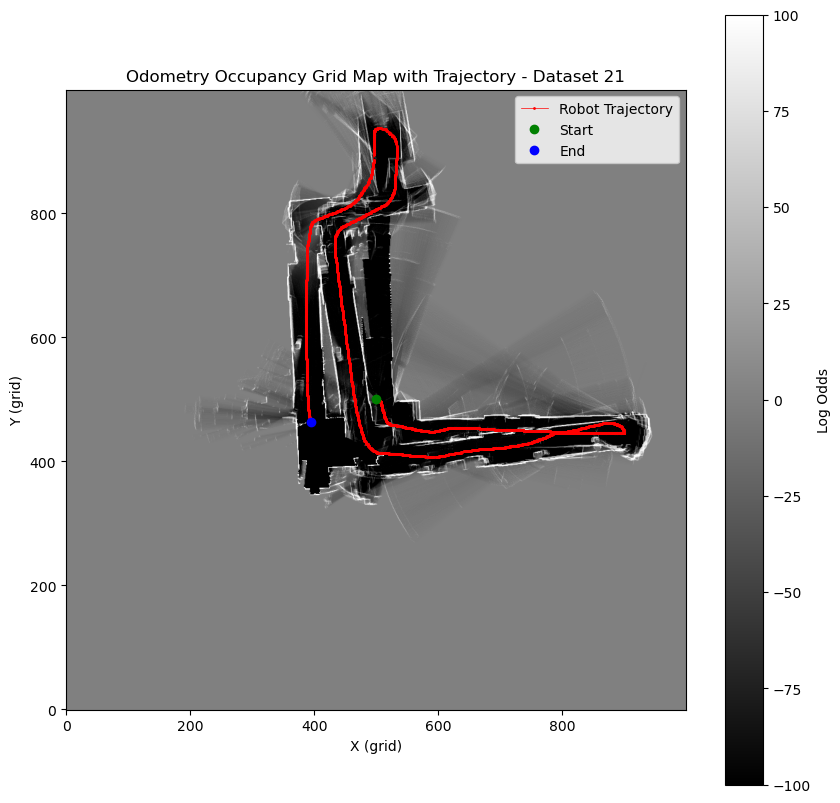

In [17]:
# Plotting with trajectory - T_odo

resolution = 0.05  # 5 cm per grid cell (meters per grid unit)
scale_factor = 1 / resolution  # Convert meters to grid units
grid_size = 1000  #Define a large fixed occupancy grid

occupancy_grid_odo = np.zeros((grid_size, grid_size), dtype=np.float32)
grid_center_x = grid_size // 2
grid_center_y = grid_size // 2

l_occupied = + 4
l_free = -0.5
l_max = 100
l_min = -100

positions_world_odo = []
robot_origin = np.array([0, 0, 1])  # Start in world coordinates (meters)

for i in range(e_time.shape[0]):
    print(f"Iteration: {i}")

    curr_origin = np.dot(T_odo[:, :, i], robot_origin)
    positions_world_odo.append(curr_origin[:2])

    robot_x_grid = np.round(curr_origin[0] * scale_factor + grid_center_x).astype(int)
    robot_y_grid = np.round(curr_origin[1] * scale_factor + grid_center_y).astype(int)

    print(f"Iteration {i}: World Position: {curr_origin[:2]} -> Grid Position: ({robot_x_grid}, {robot_y_grid})")

    ff = pc_sync[:, :, i]
    valid_mask = np.isfinite(ff).all(axis=0)  # Eliminate nan
    ff = ff[:, valid_mask]

    ff_homo = np.vstack((ff, np.ones(ff.shape[1])))
    ff_trans = T_odo[:, :, i] @ ff_homo  

    ff_trans = np.where(np.isfinite(ff_trans), ff_trans, np.nan)
    ff_trans = ff_trans[:, ~np.isnan(ff_trans).any(axis=0)]

    x_world = ff_trans[0, :]
    y_world = ff_trans[1, :]

    x_grid = np.round(x_world * scale_factor + grid_center_x).astype(int)
    y_grid = np.round(y_world * scale_factor + grid_center_y).astype(int)

    valid_mask = (x_grid >= 0) & (x_grid < grid_size) & (y_grid >= 0) & (y_grid < grid_size)
    x_valid = x_grid[valid_mask]
    y_valid = y_grid[valid_mask]

    occupancy_grid_odo[y_valid, x_valid] = np.clip(occupancy_grid_odo[y_valid, x_valid] + l_occupied, l_min, l_max)

    free_x_list = []
    free_y_list = []

    for x_end, y_end in zip(x_valid, y_valid):
        free_cells = np.array(bresenham(robot_x_grid, robot_y_grid, x_end, y_end))[:-1]  # Exclude last occupied cell
        free_x_list.append(free_cells[:, 0])
        free_y_list.append(free_cells[:, 1])

    if free_x_list:
        free_x = np.concatenate(free_x_list)
        free_y = np.concatenate(free_y_list)

        valid_free_mask = (free_x >= 0) & (free_x < grid_size) & (free_y >= 0) & (free_y < grid_size)
        free_x = free_x[valid_free_mask]
        free_y = free_y[valid_free_mask]

        occupancy_grid_odo[free_y, free_x] = np.clip(occupancy_grid_odo[free_y, free_x] + l_free, l_min, l_max)

positions_world_odo = np.array(positions_world_odo)  # Convert to NumPy array
trajectory_x = np.round(positions_world_odo[:, 0] * scale_factor + grid_center_x).astype(int)
trajectory_y = np.round(positions_world_odo[:, 1] * scale_factor + grid_center_y).astype(int)

plt.figure(figsize=(10, 10))
plt.imshow(occupancy_grid_odo, cmap="gray", origin="lower")
plt.colorbar(label="Log Odds")

plt.plot(trajectory_x, trajectory_y, 'ro-', markersize=1, linewidth=.5, label="Robot Trajectory")
plt.plot(trajectory_x[0], trajectory_y[0], 'go', markersize=6, label="Start")  # Start position (Green)
plt.plot(trajectory_x[-1], trajectory_y[-1], 'bo', markersize=6, label="End")  # End position (Blue)

plt.xlabel("X (grid)")
plt.ylabel("Y (grid)")
plt.title("Odometry Occupancy Grid Map with Trajectory - Dataset " + str(dataset))
plt.legend()
plt.show()


In [18]:
# generate sample pc from disparity images

# IMREAD_UNCHANGED ensures we preserve the precision on depth
disp_img = cv.imread("../data/dataRGBD/Disparity20/disparity20_1.png", cv.IMREAD_UNCHANGED)

# note that cv imports as bgr, so colors may be wrong.
bgr_img = cv.imread("../data/dataRGBD/RGB20/rgb20_1.png")
rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)

# from writeup, compute correspondence
height, width = disp_img.shape

dd = np.array(-0.00304 * disp_img + 3.31)
depth = 1.03 / dd

mesh = np.meshgrid(np.arange(0, height), np.arange(0, width), indexing='ij')  
i_idxs = mesh[0].flatten()
j_idxs = mesh[1].flatten()

rgb_i = np.array((526.37 * i_idxs + 19276 - 7877.07 * dd.flatten()) / 585.051, dtype=np.int32)  # force int for indexing
rgb_j = np.array((526.37 * j_idxs + 16662) / 585.051, dtype=np.int32)

# some may be out of bounds, just clip them
rgb_i = np.clip(rgb_i, 0, height - 1)
rgb_j = np.clip(rgb_j, 0, width - 1)

colors = rgb_img[rgb_i, rgb_j]

# lets visualize the image using our transformation to make sure things look correct (using bgr for opencv)
bgr_colors = bgr_img[rgb_i, rgb_j]
# cv.imshow("color", bgr_colors.reshape((height, width, 3)))

uv1 = np.vstack([j_idxs, i_idxs, np.ones_like(i_idxs)])
K = np.array([[585.05, 0, 242.94],
              [0, 585.05, 315.84],
              [0, 0, 1]])

# project images to 3d points
points = depth.flatten() * (np.linalg.inv(K) @ uv1)

oRr = np.array([[0, -1, 0],
                [0, 0, -1],
                [1, 0, 0]])

roll, pitch, yaw = 0, 0.48, 0.021

# Rotation Matrices
R_x = np.array([
    [1, 0, 0],
    [0, np.cos(roll), -np.sin(roll)],
    [0, np.sin(roll), np.cos(roll)]
])

R_y = np.array([
    [np.cos(pitch), 0, np.sin(pitch)],
    [0, 1, 0],
    [-np.sin(pitch), 0, np.cos(pitch)]
])

R_z = np.array([
    [np.cos(yaw), -np.sin(yaw), 0],
    [np.sin(yaw), np.cos(yaw), 0],
    [0, 0, 1]
])

bRk = R_z @ R_y @ R_x

# we want rRo because we have points in optical frame and want to move them to the regular frame.
points = oRr.T @ points
points = bRk @ points

ground_points = points[2, :] < -.5 # Only keep points below threshold
filtered_points = points[:, ground_points].T +  [.18,.005,.36] # shape (N, 3)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(filtered_points)

# Also filter colors to match the valid points
filtered_colors = colors[ground_points]
pcd.colors = o3d.utility.Vector3dVector(filtered_colors / 255.0)  # Normalize colors

# Visualize
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
o3d.visualization.draw_geometries([pcd, origin])


In [19]:
def find_nearest_time(target_time, source_times):
    """
    Find the closest timestamp in source_times to the given target_time.
    
    :param target_time: The RGB timestamp to match
    :param source_times: Sorted array of timestamps (e.g., pose or disparity times)
    :return: Index of the closest timestamp in source_times
    """
    idx = np.searchsorted(source_times, target_time)
    idx = np.clip(idx, 1, len(source_times) - 1)  # Ensure valid index

    # Compare neighbors to find the closest timestamp
    left_idx = idx - 1
    right_idx = idx
    if abs(source_times[left_idx] - target_time) < abs(source_times[right_idx] - target_time):
        return left_idx
    return right_idx

In [20]:
def convert_pose_3x3_to_4x4(wTb):
    """
    Convert a 3x3 SE(2) transformation (XY position + yaw rotation) 
    to a 4x4 SE(3) homogeneous transformation for 3D space.
    
    :param wTb: (3x3) 2D transformation matrix (x, y, yaw)
    :return: (4x4) homogeneous transformation matrix
    """
    T = np.eye(4)  # Initialize as identity matrix
    T[:2, :2] = wTb[:2, :2]  # Copy rotation (yaw)
    T[:2, 3] = wTb[:2, 2]    # Copy translation (x, y)
    return T


In [21]:
def convert_pose_3x3_to_4x4(wTb):
    T = np.eye(4)  
    T[:2, :2] = wTb[:2, :2]  
    T[:2, 3] = wTb[:2, 2]    
    return T

Processing RGB frame 0 at time 0.0
Processing RGB frame 1 at time 0.03302001953125
Processing RGB frame 2 at time 0.06698822975158691
Processing RGB frame 3 at time 0.09997105598449707
Processing RGB frame 4 at time 0.13301610946655273
Processing RGB frame 5 at time 0.16703319549560547
Processing RGB frame 6 at time 0.20002317428588867
Processing RGB frame 7 at time 0.23376822471618652
Processing RGB frame 8 at time 0.2670011520385742
Processing RGB frame 9 at time 0.4670600891113281
Processing RGB frame 10 at time 0.6330142021179199
Processing RGB frame 11 at time 0.66703200340271
Processing RGB frame 12 at time 0.7000100612640381
Processing RGB frame 13 at time 0.7329962253570557
Processing RGB frame 14 at time 0.7670462131500244
Processing RGB frame 15 at time 0.8000130653381348
Processing RGB frame 16 at time 0.8330550193786621
Processing RGB frame 17 at time 0.8670351505279541
Processing RGB frame 18 at time 0.9000182151794434
Processing RGB frame 19 at time 0.9330201148986816
Pro

Processing RGB frame 163 at time 8.201004028320312
Processing RGB frame 164 at time 8.235050201416016
Processing RGB frame 165 at time 8.268049001693726
Processing RGB frame 166 at time 8.302017211914062
Processing RGB frame 167 at time 8.501965999603271
Processing RGB frame 168 at time 8.535011053085327
Processing RGB frame 169 at time 8.567986011505127
Processing RGB frame 170 at time 8.601973056793213
Processing RGB frame 171 at time 8.635048151016235
Processing RGB frame 172 at time 8.668002128601074
Processing RGB frame 173 at time 8.702027082443237
Processing RGB frame 174 at time 8.735068082809448
Processing RGB frame 175 at time 8.768005132675171
Processing RGB frame 176 at time 8.96795105934143
Processing RGB frame 177 at time 9.00199818611145
Processing RGB frame 178 at time 9.035047054290771
Processing RGB frame 179 at time 9.068004131317139
Processing RGB frame 180 at time 9.103072166442871
Processing RGB frame 181 at time 9.135095119476318
Processing RGB frame 182 at time 

Processing RGB frame 323 at time 16.5369930267334
Processing RGB frame 324 at time 16.570046186447144
Processing RGB frame 325 at time 16.603065013885498
Processing RGB frame 326 at time 16.636994123458862
Processing RGB frame 327 at time 16.670040130615234
Processing RGB frame 328 at time 16.70305609703064
Processing RGB frame 329 at time 16.73699402809143
Processing RGB frame 330 at time 16.770312070846558
Processing RGB frame 331 at time 16.80329203605652
Processing RGB frame 332 at time 17.003071069717407
Processing RGB frame 333 at time 17.037042140960693
Processing RGB frame 334 at time 17.070005178451538
Processing RGB frame 335 at time 17.102989196777344
Processing RGB frame 336 at time 17.137092113494873
Processing RGB frame 337 at time 17.169990062713623
Processing RGB frame 338 at time 17.203045129776
Processing RGB frame 339 at time 17.237048149108887
Processing RGB frame 340 at time 17.269992113113403
Processing RGB frame 341 at time 17.469983100891113
Processing RGB frame

Processing RGB frame 483 at time 25.006010055541992
Processing RGB frame 484 at time 25.03901720046997
Processing RGB frame 485 at time 25.0742290019989
Processing RGB frame 486 at time 25.10600709915161
Processing RGB frame 487 at time 25.138496160507202
Processing RGB frame 488 at time 25.172003030776978
Processing RGB frame 489 at time 25.205016136169434
Processing RGB frame 490 at time 25.404973030090332
Processing RGB frame 491 at time 25.438045024871826
Processing RGB frame 492 at time 25.47404718399048
Processing RGB frame 493 at time 25.504991054534912
Processing RGB frame 494 at time 25.538039207458496
Processing RGB frame 495 at time 25.57216715812683
Processing RGB frame 496 at time 25.60495114326477
Processing RGB frame 497 at time 25.638060092926025
Processing RGB frame 498 at time 25.672012090682983
Processing RGB frame 499 at time 25.872010231018066
Processing RGB frame 500 at time 25.905027151107788
Processing RGB frame 501 at time 25.938006162643433
Processing RGB fram

Processing RGB frame 642 at time 33.273030042648315
Processing RGB frame 643 at time 33.30698800086975
Processing RGB frame 644 at time 33.33996319770813
Processing RGB frame 645 at time 33.37305212020874
Processing RGB frame 646 at time 33.40699815750122
Processing RGB frame 647 at time 33.607030153274536
Processing RGB frame 648 at time 33.64001703262329
Processing RGB frame 649 at time 33.67413401603699
Processing RGB frame 650 at time 33.706969022750854
Processing RGB frame 651 at time 33.73999905586243
Processing RGB frame 652 at time 33.773488998413086
Processing RGB frame 653 at time 33.807011127471924
Processing RGB frame 654 at time 33.8400821685791
Processing RGB frame 655 at time 33.873064041137695
Processing RGB frame 656 at time 34.07307410240173
Processing RGB frame 657 at time 34.10704517364502
Processing RGB frame 658 at time 34.14006304740906
Processing RGB frame 659 at time 34.17302107810974
Processing RGB frame 660 at time 34.206974029541016
Processing RGB frame 661 

Processing RGB frame 803 at time 42.00812005996704
Processing RGB frame 804 at time 42.04381012916565
Processing RGB frame 805 at time 42.07583713531494
Processing RGB frame 806 at time 42.10796022415161
Processing RGB frame 807 at time 42.160258054733276
Processing RGB frame 808 at time 42.20828914642334
Processing RGB frame 809 at time 42.24289011955261
Processing RGB frame 810 at time 42.275116205215454
Processing RGB frame 811 at time 42.31963920593262
Processing RGB frame 812 at time 42.41142702102661
Processing RGB frame 813 at time 42.44378304481506
Processing RGB frame 814 at time 42.47575902938843
Processing RGB frame 815 at time 42.50817322731018
Processing RGB frame 816 at time 42.54389500617981
Processing RGB frame 817 at time 42.77585816383362
Processing RGB frame 818 at time 42.81178021430969
Processing RGB frame 819 at time 42.84198212623596
Processing RGB frame 820 at time 42.8757700920105
Processing RGB frame 821 at time 42.910075187683105
Processing RGB frame 822 at t

Processing RGB frame 963 at time 50.14366912841797
Processing RGB frame 964 at time 50.34311509132385
Processing RGB frame 965 at time 50.37703013420105
Processing RGB frame 966 at time 50.4162220954895
Processing RGB frame 967 at time 50.480334997177124
Processing RGB frame 968 at time 50.51176619529724
Processing RGB frame 969 at time 50.54406499862671
Processing RGB frame 970 at time 50.576993227005005
Processing RGB frame 971 at time 50.61003613471985
Processing RGB frame 972 at time 50.81001901626587
Processing RGB frame 973 at time 50.84308218955994
Processing RGB frame 974 at time 50.878310203552246
Processing RGB frame 975 at time 50.91184115409851
Processing RGB frame 976 at time 50.94749307632446
Processing RGB frame 977 at time 50.979769229888916
Processing RGB frame 978 at time 51.01125621795654
Processing RGB frame 979 at time 51.0442590713501
Processing RGB frame 980 at time 51.07751512527466
Processing RGB frame 981 at time 51.2797110080719
Processing RGB frame 982 at ti

Processing RGB frame 1121 at time 58.84560203552246
Processing RGB frame 1122 at time 58.88148903846741
Processing RGB frame 1123 at time 59.08131003379822
Processing RGB frame 1124 at time 59.11288619041443
Processing RGB frame 1125 at time 59.145724058151245
Processing RGB frame 1126 at time 59.18140912055969
Processing RGB frame 1127 at time 59.21281909942627
Processing RGB frame 1128 at time 59.24945306777954
Processing RGB frame 1129 at time 59.31285619735718
Processing RGB frame 1130 at time 59.349332094192505
Processing RGB frame 1131 at time 59.41280508041382
Processing RGB frame 1132 at time 59.44543123245239
Processing RGB frame 1133 at time 59.47926712036133
Processing RGB frame 1134 at time 59.6812961101532
Processing RGB frame 1135 at time 59.71280002593994
Processing RGB frame 1136 at time 59.74758005142212
Processing RGB frame 1137 at time 59.781347036361694
Processing RGB frame 1138 at time 59.81280708312988
Processing RGB frame 1139 at time 59.84751009941101
Processing

Processing RGB frame 1280 at time 67.71605110168457
Processing RGB frame 1281 at time 67.74798822402954
Processing RGB frame 1282 at time 67.78003120422363
Processing RGB frame 1283 at time 67.81619215011597
Processing RGB frame 1284 at time 67.84782218933105
Processing RGB frame 1285 at time 67.87999701499939
Processing RGB frame 1286 at time 68.08194613456726
Processing RGB frame 1287 at time 68.11607623100281
Processing RGB frame 1288 at time 68.147794008255
Processing RGB frame 1289 at time 68.18003821372986
Processing RGB frame 1290 at time 68.21611309051514
Processing RGB frame 1291 at time 68.2478621006012
Processing RGB frame 1292 at time 68.28009414672852
Processing RGB frame 1293 at time 68.31607508659363
Processing RGB frame 1294 at time 68.51603317260742
Processing RGB frame 1295 at time 68.54785704612732
Processing RGB frame 1296 at time 68.57998704910278
Processing RGB frame 1297 at time 68.61616110801697
Processing RGB frame 1298 at time 68.64791822433472
Processing RGB 

Processing RGB frame 1439 at time 76.31579613685608
Processing RGB frame 1440 at time 76.5157961845398
Processing RGB frame 1441 at time 76.55173301696777
Processing RGB frame 1442 at time 76.5837140083313
Processing RGB frame 1443 at time 76.61572408676147
Processing RGB frame 1444 at time 76.65173316001892
Processing RGB frame 1445 at time 76.68372201919556
Processing RGB frame 1446 at time 76.71585011482239
Processing RGB frame 1447 at time 76.91603922843933
Processing RGB frame 1448 at time 76.95176100730896
Processing RGB frame 1449 at time 76.98369407653809
Processing RGB frame 1450 at time 77.01579999923706
Processing RGB frame 1451 at time 77.05173015594482
Processing RGB frame 1452 at time 77.08376121520996
Processing RGB frame 1453 at time 77.1158390045166
Processing RGB frame 1454 at time 77.31720519065857
Processing RGB frame 1455 at time 77.35192608833313
Processing RGB frame 1456 at time 77.38396215438843
Processing RGB frame 1457 at time 77.41716504096985
Processing RGB 

Processing RGB frame 1599 at time 85.2839720249176
Processing RGB frame 1600 at time 85.31992316246033
Processing RGB frame 1601 at time 85.35196900367737
Processing RGB frame 1602 at time 85.38547611236572
Processing RGB frame 1603 at time 85.58771514892578
Processing RGB frame 1604 at time 85.61996102333069
Processing RGB frame 1605 at time 85.65198707580566
Processing RGB frame 1606 at time 85.68772006034851
Processing RGB frame 1607 at time 85.71971917152405
Processing RGB frame 1608 at time 85.75198602676392
Processing RGB frame 1609 at time 85.7852840423584
Processing RGB frame 1610 at time 85.98771119117737
Processing RGB frame 1611 at time 86.01976418495178
Processing RGB frame 1612 at time 86.05195903778076
Processing RGB frame 1613 at time 86.0877251625061
Processing RGB frame 1614 at time 86.11976218223572
Processing RGB frame 1615 at time 86.15193819999695
Processing RGB frame 1616 at time 86.18775415420532
Processing RGB frame 1617 at time 86.35201621055603
Processing RGB 

Processing RGB frame 1757 at time 93.95202803611755
Processing RGB frame 1758 at time 93.98600101470947
Processing RGB frame 1759 at time 94.18596005439758
Processing RGB frame 1760 at time 94.21904611587524
Processing RGB frame 1761 at time 94.25198101997375
Processing RGB frame 1762 at time 94.28594708442688
Processing RGB frame 1763 at time 94.31905102729797
Processing RGB frame 1764 at time 94.3519880771637
Processing RGB frame 1765 at time 94.38621306419373
Processing RGB frame 1766 at time 94.4190571308136
Processing RGB frame 1767 at time 94.45202922821045
Processing RGB frame 1768 at time 94.65208601951599
Processing RGB frame 1769 at time 94.68602418899536
Processing RGB frame 1770 at time 94.71902203559875
Processing RGB frame 1771 at time 94.751962184906
Processing RGB frame 1772 at time 94.78614020347595
Processing RGB frame 1773 at time 94.8190381526947
Processing RGB frame 1774 at time 94.8519880771637
Processing RGB frame 1775 at time 94.8860502243042
Processing RGB fram

Processing RGB frame 1915 at time 102.35404014587402
Processing RGB frame 1916 at time 102.38698601722717
Processing RGB frame 1917 at time 102.42102408409119
Processing RGB frame 1918 at time 102.45401310920715
Processing RGB frame 1919 at time 102.48698711395264
Processing RGB frame 1920 at time 102.52104902267456
Processing RGB frame 1921 at time 102.5540201663971
Processing RGB frame 1922 at time 102.75404000282288
Processing RGB frame 1923 at time 102.78704905509949
Processing RGB frame 1924 at time 102.82098722457886
Processing RGB frame 1925 at time 102.85401821136475
Processing RGB frame 1926 at time 102.88705515861511
Processing RGB frame 1927 at time 102.92103600502014
Processing RGB frame 1928 at time 102.95395517349243
Processing RGB frame 1929 at time 102.98705220222473
Processing RGB frame 1930 at time 103.02099013328552
Processing RGB frame 1931 at time 103.22107315063477
Processing RGB frame 1932 at time 103.25404620170593
Processing RGB frame 1933 at time 103.287001132

Processing RGB frame 2070 at time 110.48898005485535
Processing RGB frame 2071 at time 110.5230941772461
Processing RGB frame 2072 at time 110.55603218078613
Processing RGB frame 2073 at time 110.58902716636658
Processing RGB frame 2074 at time 110.62223720550537
Processing RGB frame 2075 at time 110.6560161113739
Processing RGB frame 2076 at time 110.85605120658875
Processing RGB frame 2077 at time 110.88940811157227
Processing RGB frame 2078 at time 110.92197823524475
Processing RGB frame 2079 at time 110.95595216751099
Processing RGB frame 2080 at time 110.98913812637329
Processing RGB frame 2081 at time 111.02200317382812
Processing RGB frame 2082 at time 111.05597805976868
Processing RGB frame 2083 at time 111.08906507492065
Processing RGB frame 2084 at time 111.12204813957214
Processing RGB frame 2085 at time 111.32211017608643
Processing RGB frame 2086 at time 111.35617804527283
Processing RGB frame 2087 at time 111.38902711868286
Processing RGB frame 2088 at time 111.4220201969

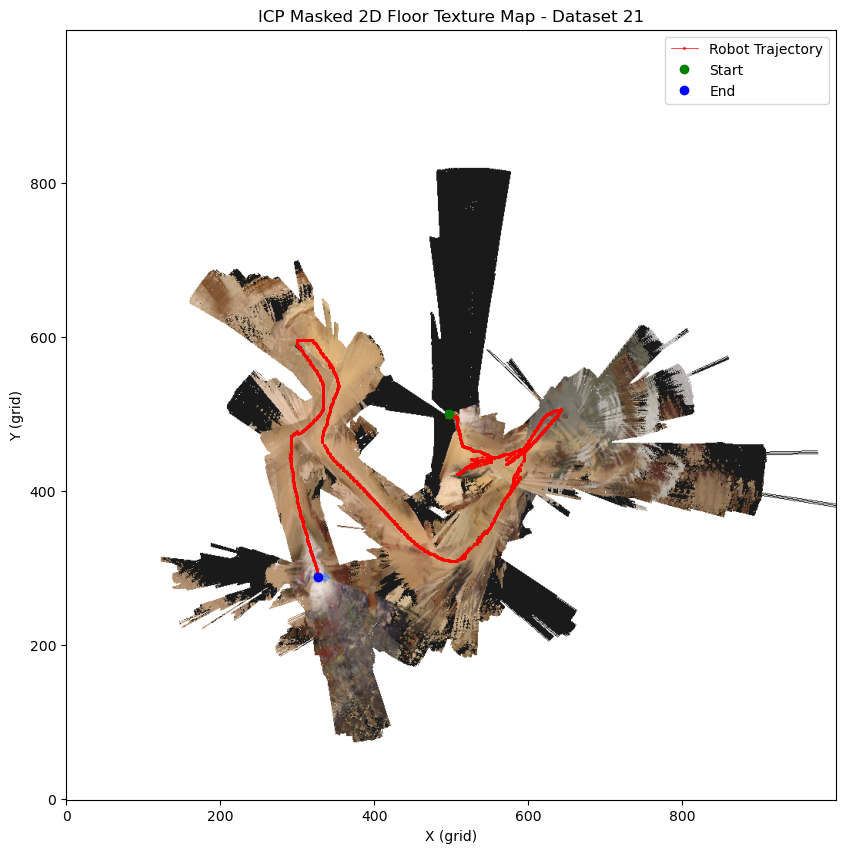

In [22]:
# ICP Texture Map
rgb_time = rgb_stamps-rgb_stamps[0]
disp_time = disp_stamps-disp_stamps[0]

grid_size = 1000  
resolution = 0.05  
scale_factor = 1 / resolution  
grid_center_x = grid_size // 2
grid_center_y = grid_size // 2

texture_grid = np.zeros((grid_size, grid_size, 3), dtype=np.float32)  
texture_count = np.zeros((grid_size, grid_size), dtype=np.int32)  

K = np.array([[585.05, 0, 242.94],
              [0, 585.05, 315.84],
              [0, 0, 1]])

roll, pitch, yaw = 0, .48, 0.021  

R_x = np.array([[1, 0, 0],
                [0, np.cos(roll), -np.sin(roll)],
                [0, np.sin(roll), np.cos(roll)]])

R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                [0, 1, 0],
                [-np.sin(pitch), 0, np.cos(pitch)]])

R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                [np.sin(yaw), np.cos(yaw), 0],
                [0, 0, 1]])

bRk = R_z @ R_y @ R_x  
oRr = np.array([[0, -1, 0], [0, 0, -1], [1, 0, 0]])  

kinect_position = np.array([[.18], [.005], [.36]])  

for rgb_idx, rgb_t in enumerate(rgb_time):
    print(f"Processing RGB frame {rgb_idx} at time {rgb_t}")

    disp_idx = find_nearest_time(rgb_t, disp_time)
    pose_idx = find_nearest_time(rgb_t, e_time)

    disp_path = f"../data/dataRGBD/Disparity20/disparity20_{disp_idx+1}.png"
    disp_img = cv.imread(disp_path, cv.IMREAD_UNCHANGED)
    if disp_img is None:
        print(f"Warning: Disparity image at index {disp_idx} not found!")
        continue

    wTb_3x3 = T_icp[:, :, pose_idx]  
    wTb_4x4 = convert_pose_3x3_to_4x4(wTb_3x3)

    rgb_path = f"../data/dataRGBD/RGB20/rgb20_{rgb_idx+1}.png"
    rgb_img = cv.imread(rgb_path)
    if rgb_img is None:
        print(f"Warning: RGB image at index {rgb_idx} not found!")
        continue
    rgb_img = cv.cvtColor(rgb_img, cv.COLOR_BGR2RGB)

    height, width = disp_img.shape
    dd = -0.00304 * disp_img + 3.31
    depth = 1.03 / dd

    j_idxs, i_idxs = np.meshgrid(np.arange(width), np.arange(height), indexing='xy')
    i_flat, j_flat = i_idxs.flatten(), j_idxs.flatten()
    
    rgb_i = np.clip(((526.37 * i_flat + 19276 - 7877.07 * dd.flatten()) / 585.051).astype(np.int32), 0, height - 1)
    rgb_j = np.clip(((526.37 * j_flat + 16662) / 585.051).astype(np.int32), 0, width - 1)

    colors = rgb_img[rgb_i, rgb_j]  

    uv1 = np.vstack([j_flat, i_flat, np.ones_like(i_flat)])
    points_camera = depth.flatten() * (np.linalg.inv(K) @ uv1)

    points_robot = (bRk @ oRr.T @ points_camera) + kinect_position
    points_homogeneous = np.vstack((points_robot, np.ones((1, points_robot.shape[1]))))
    points_world_homogeneous = wTb_4x4 @ points_homogeneous
    points_world = points_world_homogeneous[:3, :]

    x_grid = np.round(points_world[0, :] * scale_factor + grid_center_x).astype(np.int32)
    y_grid = np.round(points_world[1, :] * scale_factor + grid_center_y).astype(np.int32)

    valid_mask = (x_grid >= 0) & (x_grid < grid_size) & (y_grid >= 0) & (y_grid < grid_size)
    x_valid, y_valid = x_grid[valid_mask], y_grid[valid_mask]
    colors_valid = colors[valid_mask]

    np.add.at(texture_grid, (y_valid, x_valid), colors_valid)
    np.add.at(texture_count, (y_valid, x_valid), 1)

valid_mask = texture_count > 0  
texture_grid[valid_mask] /= texture_count[valid_mask][:, np.newaxis]  
texture_grid_display = np.clip(texture_grid, 0, 255).astype(np.uint8)  

masked_texture_grid = texture_grid_display.copy()
masked_texture_grid[occupancy_grid_icp == 0] = [255, 255, 255]  # Set masked areas to black

trajectory_x = np.round(positions_world_icp[:, 0] * scale_factor + grid_center_x).astype(int)
trajectory_y = np.round(positions_world_icp[:, 1] * scale_factor + grid_center_y).astype(int)

plt.figure(figsize=(10, 10))
plt.imshow(masked_texture_grid, origin="lower", alpha=0.9)  

plt.plot(trajectory_x, trajectory_y, 'ro-', markersize=1, linewidth=.5, label="Robot Trajectory")
plt.plot(trajectory_x[0], trajectory_y[0], 'go', markersize=6, label="Start")  # Start position (Green)
plt.plot(trajectory_x[-1], trajectory_y[-1], 'bo', markersize=6, label="End")  # End position (Blue)

plt.xlabel("X (grid)")
plt.ylabel("Y (grid)")
plt.legend()
plt.title("ICP Masked 2D Floor Texture Map - Dataset " + str(dataset))
plt.show()


Processing RGB frame 0 at time 0.0
Processing RGB frame 1 at time 0.03302001953125
Processing RGB frame 2 at time 0.06698822975158691
Processing RGB frame 3 at time 0.09997105598449707
Processing RGB frame 4 at time 0.13301610946655273
Processing RGB frame 5 at time 0.16703319549560547
Processing RGB frame 6 at time 0.20002317428588867
Processing RGB frame 7 at time 0.23376822471618652
Processing RGB frame 8 at time 0.2670011520385742
Processing RGB frame 9 at time 0.4670600891113281
Processing RGB frame 10 at time 0.6330142021179199
Processing RGB frame 11 at time 0.66703200340271
Processing RGB frame 12 at time 0.7000100612640381
Processing RGB frame 13 at time 0.7329962253570557
Processing RGB frame 14 at time 0.7670462131500244
Processing RGB frame 15 at time 0.8000130653381348
Processing RGB frame 16 at time 0.8330550193786621
Processing RGB frame 17 at time 0.8670351505279541
Processing RGB frame 18 at time 0.9000182151794434
Processing RGB frame 19 at time 0.9330201148986816
Pro

Processing RGB frame 162 at time 8.168039083480835
Processing RGB frame 163 at time 8.201004028320312
Processing RGB frame 164 at time 8.235050201416016
Processing RGB frame 165 at time 8.268049001693726
Processing RGB frame 166 at time 8.302017211914062
Processing RGB frame 167 at time 8.501965999603271
Processing RGB frame 168 at time 8.535011053085327
Processing RGB frame 169 at time 8.567986011505127
Processing RGB frame 170 at time 8.601973056793213
Processing RGB frame 171 at time 8.635048151016235
Processing RGB frame 172 at time 8.668002128601074
Processing RGB frame 173 at time 8.702027082443237
Processing RGB frame 174 at time 8.735068082809448
Processing RGB frame 175 at time 8.768005132675171
Processing RGB frame 176 at time 8.96795105934143
Processing RGB frame 177 at time 9.00199818611145
Processing RGB frame 178 at time 9.035047054290771
Processing RGB frame 179 at time 9.068004131317139
Processing RGB frame 180 at time 9.103072166442871
Processing RGB frame 181 at time 

Processing RGB frame 321 at time 16.303766012191772
Processing RGB frame 322 at time 16.336002111434937
Processing RGB frame 323 at time 16.5369930267334
Processing RGB frame 324 at time 16.570046186447144
Processing RGB frame 325 at time 16.603065013885498
Processing RGB frame 326 at time 16.636994123458862
Processing RGB frame 327 at time 16.670040130615234
Processing RGB frame 328 at time 16.70305609703064
Processing RGB frame 329 at time 16.73699402809143
Processing RGB frame 330 at time 16.770312070846558
Processing RGB frame 331 at time 16.80329203605652
Processing RGB frame 332 at time 17.003071069717407
Processing RGB frame 333 at time 17.037042140960693
Processing RGB frame 334 at time 17.070005178451538
Processing RGB frame 335 at time 17.102989196777344
Processing RGB frame 336 at time 17.137092113494873
Processing RGB frame 337 at time 17.169990062713623
Processing RGB frame 338 at time 17.203045129776
Processing RGB frame 339 at time 17.237048149108887
Processing RGB frame

Processing RGB frame 481 at time 24.772244215011597
Processing RGB frame 482 at time 24.972973108291626
Processing RGB frame 483 at time 25.006010055541992
Processing RGB frame 484 at time 25.03901720046997
Processing RGB frame 485 at time 25.0742290019989
Processing RGB frame 486 at time 25.10600709915161
Processing RGB frame 487 at time 25.138496160507202
Processing RGB frame 488 at time 25.172003030776978
Processing RGB frame 489 at time 25.205016136169434
Processing RGB frame 490 at time 25.404973030090332
Processing RGB frame 491 at time 25.438045024871826
Processing RGB frame 492 at time 25.47404718399048
Processing RGB frame 493 at time 25.504991054534912
Processing RGB frame 494 at time 25.538039207458496
Processing RGB frame 495 at time 25.57216715812683
Processing RGB frame 496 at time 25.60495114326477
Processing RGB frame 497 at time 25.638060092926025
Processing RGB frame 498 at time 25.672012090682983
Processing RGB frame 499 at time 25.872010231018066
Processing RGB fram

Processing RGB frame 641 at time 33.23999309539795
Processing RGB frame 642 at time 33.273030042648315
Processing RGB frame 643 at time 33.30698800086975
Processing RGB frame 644 at time 33.33996319770813
Processing RGB frame 645 at time 33.37305212020874
Processing RGB frame 646 at time 33.40699815750122
Processing RGB frame 647 at time 33.607030153274536
Processing RGB frame 648 at time 33.64001703262329
Processing RGB frame 649 at time 33.67413401603699
Processing RGB frame 650 at time 33.706969022750854
Processing RGB frame 651 at time 33.73999905586243
Processing RGB frame 652 at time 33.773488998413086
Processing RGB frame 653 at time 33.807011127471924
Processing RGB frame 654 at time 33.8400821685791
Processing RGB frame 655 at time 33.873064041137695
Processing RGB frame 656 at time 34.07307410240173
Processing RGB frame 657 at time 34.10704517364502
Processing RGB frame 658 at time 34.14006304740906
Processing RGB frame 659 at time 34.17302107810974
Processing RGB frame 660 a

Processing RGB frame 802 at time 41.976065158843994
Processing RGB frame 803 at time 42.00812005996704
Processing RGB frame 804 at time 42.04381012916565
Processing RGB frame 805 at time 42.07583713531494
Processing RGB frame 806 at time 42.10796022415161
Processing RGB frame 807 at time 42.160258054733276
Processing RGB frame 808 at time 42.20828914642334
Processing RGB frame 809 at time 42.24289011955261
Processing RGB frame 810 at time 42.275116205215454
Processing RGB frame 811 at time 42.31963920593262
Processing RGB frame 812 at time 42.41142702102661
Processing RGB frame 813 at time 42.44378304481506
Processing RGB frame 814 at time 42.47575902938843
Processing RGB frame 815 at time 42.50817322731018
Processing RGB frame 816 at time 42.54389500617981
Processing RGB frame 817 at time 42.77585816383362
Processing RGB frame 818 at time 42.81178021430969
Processing RGB frame 819 at time 42.84198212623596
Processing RGB frame 820 at time 42.8757700920105
Processing RGB frame 821 at t

Processing RGB frame 963 at time 50.14366912841797
Processing RGB frame 964 at time 50.34311509132385
Processing RGB frame 965 at time 50.37703013420105
Processing RGB frame 966 at time 50.4162220954895
Processing RGB frame 967 at time 50.480334997177124
Processing RGB frame 968 at time 50.51176619529724
Processing RGB frame 969 at time 50.54406499862671
Processing RGB frame 970 at time 50.576993227005005
Processing RGB frame 971 at time 50.61003613471985
Processing RGB frame 972 at time 50.81001901626587
Processing RGB frame 973 at time 50.84308218955994
Processing RGB frame 974 at time 50.878310203552246
Processing RGB frame 975 at time 50.91184115409851
Processing RGB frame 976 at time 50.94749307632446
Processing RGB frame 977 at time 50.979769229888916
Processing RGB frame 978 at time 51.01125621795654
Processing RGB frame 979 at time 51.0442590713501
Processing RGB frame 980 at time 51.07751512527466
Processing RGB frame 981 at time 51.2797110080719
Processing RGB frame 982 at ti

Processing RGB frame 1121 at time 58.84560203552246
Processing RGB frame 1122 at time 58.88148903846741
Processing RGB frame 1123 at time 59.08131003379822
Processing RGB frame 1124 at time 59.11288619041443
Processing RGB frame 1125 at time 59.145724058151245
Processing RGB frame 1126 at time 59.18140912055969
Processing RGB frame 1127 at time 59.21281909942627
Processing RGB frame 1128 at time 59.24945306777954
Processing RGB frame 1129 at time 59.31285619735718
Processing RGB frame 1130 at time 59.349332094192505
Processing RGB frame 1131 at time 59.41280508041382
Processing RGB frame 1132 at time 59.44543123245239
Processing RGB frame 1133 at time 59.47926712036133
Processing RGB frame 1134 at time 59.6812961101532
Processing RGB frame 1135 at time 59.71280002593994
Processing RGB frame 1136 at time 59.74758005142212
Processing RGB frame 1137 at time 59.781347036361694
Processing RGB frame 1138 at time 59.81280708312988
Processing RGB frame 1139 at time 59.84751009941101
Processing

Processing RGB frame 1279 at time 67.68009805679321
Processing RGB frame 1280 at time 67.71605110168457
Processing RGB frame 1281 at time 67.74798822402954
Processing RGB frame 1282 at time 67.78003120422363
Processing RGB frame 1283 at time 67.81619215011597
Processing RGB frame 1284 at time 67.84782218933105
Processing RGB frame 1285 at time 67.87999701499939
Processing RGB frame 1286 at time 68.08194613456726
Processing RGB frame 1287 at time 68.11607623100281
Processing RGB frame 1288 at time 68.147794008255
Processing RGB frame 1289 at time 68.18003821372986
Processing RGB frame 1290 at time 68.21611309051514
Processing RGB frame 1291 at time 68.2478621006012
Processing RGB frame 1292 at time 68.28009414672852
Processing RGB frame 1293 at time 68.31607508659363
Processing RGB frame 1294 at time 68.51603317260742
Processing RGB frame 1295 at time 68.54785704612732
Processing RGB frame 1296 at time 68.57998704910278
Processing RGB frame 1297 at time 68.61616110801697
Processing RGB 

Processing RGB frame 1438 at time 76.28373122215271
Processing RGB frame 1439 at time 76.31579613685608
Processing RGB frame 1440 at time 76.5157961845398
Processing RGB frame 1441 at time 76.55173301696777
Processing RGB frame 1442 at time 76.5837140083313
Processing RGB frame 1443 at time 76.61572408676147
Processing RGB frame 1444 at time 76.65173316001892
Processing RGB frame 1445 at time 76.68372201919556
Processing RGB frame 1446 at time 76.71585011482239
Processing RGB frame 1447 at time 76.91603922843933
Processing RGB frame 1448 at time 76.95176100730896
Processing RGB frame 1449 at time 76.98369407653809
Processing RGB frame 1450 at time 77.01579999923706
Processing RGB frame 1451 at time 77.05173015594482
Processing RGB frame 1452 at time 77.08376121520996
Processing RGB frame 1453 at time 77.1158390045166
Processing RGB frame 1454 at time 77.31720519065857
Processing RGB frame 1455 at time 77.35192608833313
Processing RGB frame 1456 at time 77.38396215438843
Processing RGB 

Processing RGB frame 1597 at time 85.21997308731079
Processing RGB frame 1598 at time 85.25178813934326
Processing RGB frame 1599 at time 85.2839720249176
Processing RGB frame 1600 at time 85.31992316246033
Processing RGB frame 1601 at time 85.35196900367737
Processing RGB frame 1602 at time 85.38547611236572
Processing RGB frame 1603 at time 85.58771514892578
Processing RGB frame 1604 at time 85.61996102333069
Processing RGB frame 1605 at time 85.65198707580566
Processing RGB frame 1606 at time 85.68772006034851
Processing RGB frame 1607 at time 85.71971917152405
Processing RGB frame 1608 at time 85.75198602676392
Processing RGB frame 1609 at time 85.7852840423584
Processing RGB frame 1610 at time 85.98771119117737
Processing RGB frame 1611 at time 86.01976418495178
Processing RGB frame 1612 at time 86.05195903778076
Processing RGB frame 1613 at time 86.0877251625061
Processing RGB frame 1614 at time 86.11976218223572
Processing RGB frame 1615 at time 86.15193819999695
Processing RGB 

Processing RGB frame 1755 at time 93.88598322868347
Processing RGB frame 1756 at time 93.91901302337646
Processing RGB frame 1757 at time 93.95202803611755
Processing RGB frame 1758 at time 93.98600101470947
Processing RGB frame 1759 at time 94.18596005439758
Processing RGB frame 1760 at time 94.21904611587524
Processing RGB frame 1761 at time 94.25198101997375
Processing RGB frame 1762 at time 94.28594708442688
Processing RGB frame 1763 at time 94.31905102729797
Processing RGB frame 1764 at time 94.3519880771637
Processing RGB frame 1765 at time 94.38621306419373
Processing RGB frame 1766 at time 94.4190571308136
Processing RGB frame 1767 at time 94.45202922821045
Processing RGB frame 1768 at time 94.65208601951599
Processing RGB frame 1769 at time 94.68602418899536
Processing RGB frame 1770 at time 94.71902203559875
Processing RGB frame 1771 at time 94.751962184906
Processing RGB frame 1772 at time 94.78614020347595
Processing RGB frame 1773 at time 94.8190381526947
Processing RGB fr

Processing RGB frame 1913 at time 102.15403413772583
Processing RGB frame 1914 at time 102.32213521003723
Processing RGB frame 1915 at time 102.35404014587402
Processing RGB frame 1916 at time 102.38698601722717
Processing RGB frame 1917 at time 102.42102408409119
Processing RGB frame 1918 at time 102.45401310920715
Processing RGB frame 1919 at time 102.48698711395264
Processing RGB frame 1920 at time 102.52104902267456
Processing RGB frame 1921 at time 102.5540201663971
Processing RGB frame 1922 at time 102.75404000282288
Processing RGB frame 1923 at time 102.78704905509949
Processing RGB frame 1924 at time 102.82098722457886
Processing RGB frame 1925 at time 102.85401821136475
Processing RGB frame 1926 at time 102.88705515861511
Processing RGB frame 1927 at time 102.92103600502014
Processing RGB frame 1928 at time 102.95395517349243
Processing RGB frame 1929 at time 102.98705220222473
Processing RGB frame 1930 at time 103.02099013328552
Processing RGB frame 1931 at time 103.221073150

Processing RGB frame 2069 at time 110.45599603652954
Processing RGB frame 2070 at time 110.48898005485535
Processing RGB frame 2071 at time 110.5230941772461
Processing RGB frame 2072 at time 110.55603218078613
Processing RGB frame 2073 at time 110.58902716636658
Processing RGB frame 2074 at time 110.62223720550537
Processing RGB frame 2075 at time 110.6560161113739
Processing RGB frame 2076 at time 110.85605120658875
Processing RGB frame 2077 at time 110.88940811157227
Processing RGB frame 2078 at time 110.92197823524475
Processing RGB frame 2079 at time 110.95595216751099
Processing RGB frame 2080 at time 110.98913812637329
Processing RGB frame 2081 at time 111.02200317382812
Processing RGB frame 2082 at time 111.05597805976868
Processing RGB frame 2083 at time 111.08906507492065
Processing RGB frame 2084 at time 111.12204813957214
Processing RGB frame 2085 at time 111.32211017608643
Processing RGB frame 2086 at time 111.35617804527283
Processing RGB frame 2087 at time 111.3890271186

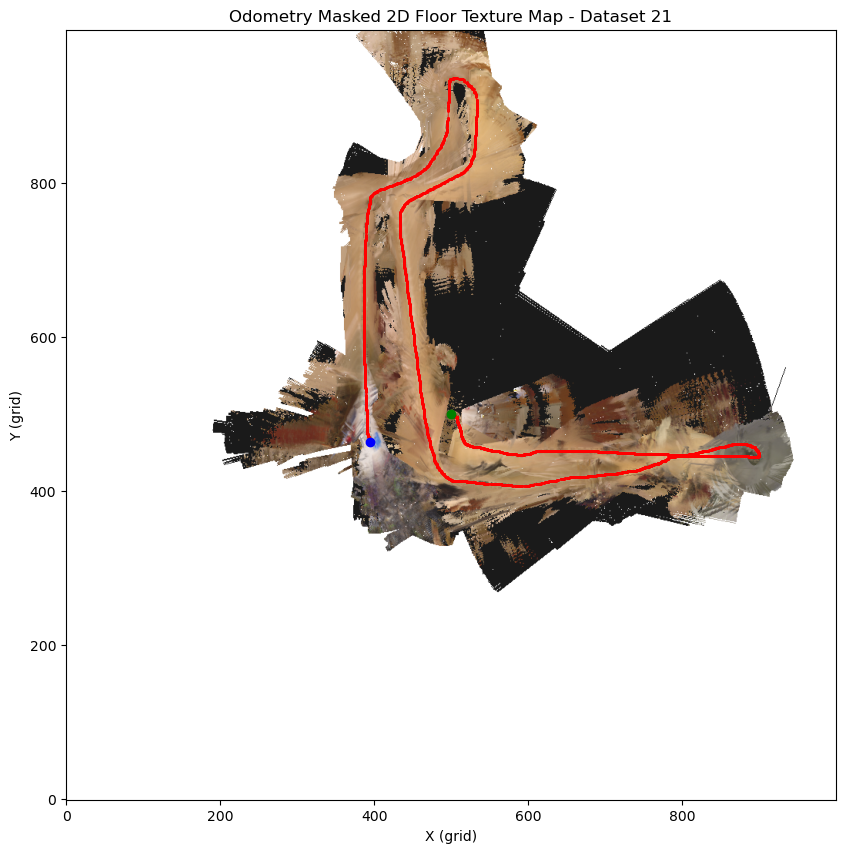

In [39]:
# Odometry Texture Map
rgb_time = rgb_stamps-rgb_stamps[0]
disp_time = disp_stamps-disp_stamps[0]

grid_size = 1000  
resolution = 0.05  
scale_factor = 1 / resolution  
grid_center_x = grid_size // 2
grid_center_y = grid_size // 2

texture_grid = np.zeros((grid_size, grid_size, 3), dtype=np.float32)  
texture_count = np.zeros((grid_size, grid_size), dtype=np.int32)  

K = np.array([[585.05, 0, 242.94],
              [0, 585.05, 315.84],
              [0, 0, 1]])

roll, pitch, yaw = 0, .48, 0.021  

R_x = np.array([[1, 0, 0],
                [0, np.cos(roll), -np.sin(roll)],
                [0, np.sin(roll), np.cos(roll)]])

R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                [0, 1, 0],
                [-np.sin(pitch), 0, np.cos(pitch)]])

R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                [np.sin(yaw), np.cos(yaw), 0],
                [0, 0, 1]])

bRk = R_z @ R_y @ R_x  
oRr = np.array([[0, -1, 0], [0, 0, -1], [1, 0, 0]])  

kinect_position = np.array([[.18], [.005], [.36]])  

for rgb_idx, rgb_t in enumerate(rgb_time):
    print(f"Processing RGB frame {rgb_idx} at time {rgb_t}")

    disp_idx = find_nearest_time(rgb_t, disp_time)
    pose_idx = find_nearest_time(rgb_t, e_time)

    disp_path = f"../data/dataRGBD/Disparity20/disparity20_{disp_idx+1}.png"
    disp_img = cv.imread(disp_path, cv.IMREAD_UNCHANGED)
    if disp_img is None:
        print(f"Warning: Disparity image at index {disp_idx} not found!")
        continue

    wTb_3x3 = T_odo[:, :, pose_idx]  
    wTb_4x4 = convert_pose_3x3_to_4x4(wTb_3x3)

    rgb_path = f"../data/dataRGBD/RGB20/rgb20_{rgb_idx+1}.png"
    rgb_img = cv.imread(rgb_path)
    if rgb_img is None:
        print(f"Warning: RGB image at index {rgb_idx} not found!")
        continue
    rgb_img = cv.cvtColor(rgb_img, cv.COLOR_BGR2RGB)

    height, width = disp_img.shape
    dd = -0.00304 * disp_img + 3.31
    depth = 1.03 / dd

    j_idxs, i_idxs = np.meshgrid(np.arange(width), np.arange(height), indexing='xy')
    i_flat, j_flat = i_idxs.flatten(), j_idxs.flatten()
    
    rgb_i = np.clip(((526.37 * i_flat + 19276 - 7877.07 * dd.flatten()) / 585.051).astype(np.int32), 0, height - 1)
    rgb_j = np.clip(((526.37 * j_flat + 16662) / 585.051).astype(np.int32), 0, width - 1)

    colors = rgb_img[rgb_i, rgb_j]  

    uv1 = np.vstack([j_flat, i_flat, np.ones_like(i_flat)])
    points_camera = depth.flatten() * (np.linalg.inv(K) @ uv1)

    points_robot = (bRk @ oRr.T @ points_camera) + kinect_position
    points_homogeneous = np.vstack((points_robot, np.ones((1, points_robot.shape[1]))))
    points_world_homogeneous = wTb_4x4 @ points_homogeneous
    points_world = points_world_homogeneous[:3, :]

    x_grid = np.round(points_world[0, :] * scale_factor + grid_center_x).astype(np.int32)
    y_grid = np.round(points_world[1, :] * scale_factor + grid_center_y).astype(np.int32)

    valid_mask = (x_grid >= 0) & (x_grid < grid_size) & (y_grid >= 0) & (y_grid < grid_size)
    x_valid, y_valid = x_grid[valid_mask], y_grid[valid_mask]
    colors_valid = colors[valid_mask]

    np.add.at(texture_grid, (y_valid, x_valid), colors_valid)
    np.add.at(texture_count, (y_valid, x_valid), 1)

valid_mask = texture_count > 0  
texture_grid[valid_mask] /= texture_count[valid_mask][:, np.newaxis]  
texture_grid_display = np.clip(texture_grid, 0, 255).astype(np.uint8)  

masked_texture_grid = texture_grid_display.copy()
masked_texture_grid[occupancy_grid_odo == 0] = [255, 255, 255]  # Set masked areas to white

trajectory_x = np.round(positions_world_odo[:, 0] * scale_factor + grid_center_x).astype(int)
trajectory_y = np.round(positions_world_odo[:, 1] * scale_factor + grid_center_y).astype(int)

plt.figure(figsize=(10, 10))
plt.imshow(masked_texture_grid, origin="lower", alpha=0.9)  

plt.plot(trajectory_x, trajectory_y, 'ro-', markersize=1, linewidth=.5, label="Robot Trajectory")
plt.plot(trajectory_x[0], trajectory_y[0], 'go', markersize=6, label="Start")  # Start position (Green)
plt.plot(trajectory_x[-1], trajectory_y[-1], 'bo', markersize=6, label="End")  # End position (Blue)

plt.xlabel("X (grid)")
plt.ylabel("Y (grid)")
plt.title("Odometry Masked 2D Floor Texture Map - Dataset " + str(dataset))
plt.show()


In [25]:
#Part 4
import gtsam
from gtsam import NonlinearFactorGraph, Values, Pose2
from gtsam import PriorFactorPose2, BetweenFactorPose2
from gtsam import noiseModel

In [26]:
# Step 1

graph = NonlinearFactorGraph() #creating empty factor graph
initial_estimates = Values()
prior_noise = noiseModel.Diagonal.Sigmas([0.01, 0.01, 0.01])  # adding noise
graph.add(PriorFactorPose2(0, Pose2(0.0, 0.0, 0.0), prior_noise))

initial_estimates.insert(0, Pose2(0.0, 0.0, 0.0)) #initial pose estimate


In [27]:
def matrix3x3_to_pose2(T_3x3):
    """
    Convert a 3x3 SE(2) transform to gtsam.Pose2(x, y, theta).
    """
    x = T_3x3[0, 2]
    y = T_3x3[1, 2]
    theta = np.arctan2(T_3x3[1, 0], T_3x3[0, 0])  # from rotation matrix
    return Pose2(x, y, theta)

In [28]:
n = e_time.shape[0]
odometry_noise = noiseModel.Diagonal.Sigmas([0.05, 0.05, 0.05])

for i in range(n - 1):
    T_i   = T_icp[:, :, i]
    T_ip1 = T_icp[:, :, i+1]

    T_rel = np.linalg.inv(T_i) @ T_ip1
    rel_pose = matrix3x3_to_pose2(T_rel)
    
    graph.add(BetweenFactorPose2(i, i+1, rel_pose, odometry_noise))
    
    if not initial_estimates.exists(i+1):
        guess_pose = matrix3x3_to_pose2(T_ip1) # Guess with T_icp
        initial_estimates.insert(i+1, guess_pose)


In [29]:
def compute_icp_error(source, target, T):
    """
    Compute mean nearest-neighbor distance after applying transform T to 'source'.
    source, target: (N,2) arrays
    T: 3x3 transform
    """
    # Transform source
    source_h = np.hstack((source, np.ones((source.shape[0], 1)))).T  # shape (3, N)
    source_tf = (T @ source_h).T  # shape (N, 3)
    source_tf_2d = source_tf[:, :2]
    
    tree = scipy.spatial.KDTree(target)
    dist, _ = tree.query(source_tf_2d)
    error = np.mean(dist)
    return error

In [30]:
# Step 2a

loop_closure_noise = noiseModel.Diagonal.Sigmas([0.05, 0.05, 0.05])
K = 10  # fixed interval
thresh = 0.3
for i in range(n):
    print(i)
    j = i - K
    if j < 0:
        continue
    
    # run ICP between scans i and j:
    source_scan = pc_sync[:, :, i].T  
    valid_source = ~np.isnan(source_scan).any(axis=1)
    source_scan = source_scan[valid_source]

    target_scan = pc_sync[:, :, j].T
    valid_target = ~np.isnan(target_scan).any(axis=1)
    target_scan = target_scan[valid_target]

    
    T_guess = np.linalg.inv(T_icp[:, :, j]) @ T_icp[:, :, i]
    T_loop = icp(source_scan, target_scan, T_odo=T_guess, max_iter=50)
    error = compute_icp_error(source_scan, target_scan, T_loop)
    
    if error < thresh: # checking if loop closure is plausible
        loop_pose = matrix3x3_to_pose2(T_loop)
        graph.add(BetweenFactorPose2(j, i, loop_pose, loop_closure_noise))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703


In [31]:
# Step 2b

num_poses = T_icp.shape[2]
p_thresh = 2.0             
window = 50              
o_thresh = np.deg2rad(45)  
max_ssize = 300             

positions    = np.zeros((num_poses, 2))
orientations = np.zeros(num_poses)
for i in range(num_poses):
    Ti = T_icp[:, :, i]
    positions[i, 0] = Ti[0, 2]  # x
    positions[i, 1] = Ti[1, 2]  # y
    orientations[i] = np.arctan2(Ti[1, 0], Ti[0, 0])

tree = scipy.spatial.KDTree(positions)

loop_closure_noise = noiseModel.Diagonal.Sigmas([0.05, 0.05, 0.05]) #adding noise

for i in range(num_poses):
    neighbors = tree.query_ball_point(positions[i], r=p_thresh) #returning list of indices
    neighbors = [j for j in neighbors if j < i]

    neighbors = [j for j in neighbors if j >= i - window] #check against past points

    valid_neighbors = []
    for j in neighbors:
        dtheta = (orientations[i] - orientations[j] + np.pi) % (2*np.pi) - np.pi
        if abs(dtheta) < o_thresh:
            valid_neighbors.append(j)

    if len(valid_neighbors) > 2: #choose best neighbor
        dists = np.linalg.norm(positions[valid_neighbors] - positions[i], axis=1)
        sorted_idx = np.argsort(dists)[:2]
        valid_neighbors = np.array(valid_neighbors)[sorted_idx]

    for j in valid_neighbors:
        # get scans i and j
        source_scan = pc_sync[:, :, i].T  # shape (M,2)
        valid_src   = ~np.isnan(source_scan).any(axis=1)
        source_scan = source_scan[valid_src]
        if source_scan.shape[0] > max_ssize:
            idxs = np.linspace(0, source_scan.shape[0]-1, max_ssize).astype(int)
            source_scan = source_scan[idxs]

        target_scan = pc_sync[:, :, j].T
        valid_tgt   = ~np.isnan(target_scan).any(axis=1)
        target_scan = target_scan[valid_tgt]
        if target_scan.shape[0] > max_ssize:
            idxs = np.linspace(0, target_scan.shape[0]-1, max_ssize).astype(int)
            target_scan = target_scan[idxs]

        T_guess = np.linalg.inv(T_icp[:, :, j]) @ T_icp[:, :, i]
        T_loop = icp(source_scan, target_scan, T_odo=T_guess, max_iter=50)

        error = compute_icp_error(source_scan, target_scan, T_loop)
        if error < thresh:
            loop_pose = matrix3x3_to_pose2(T_loop)
            graph.add(BetweenFactorPose2(j, i, loop_pose, loop_closure_noise))


In [32]:
params = gtsam.LevenbergMarquardtParams()
params.setMaxIterations(100)

optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimates, params)
result = optimizer.optimize()

optimized_poses = []
for i in range(num_poses):
    pose_i_opt = result.atPose2(i)   # returns gtsam.Pose2 for node i
    optimized_poses.append(pose_i_opt)


In [33]:
def pose2_to_matrix3x3(pose2):
    """
    Convert gtsam.Pose2(x, y, theta) -> a 3x3 SE(2) numpy array.
    """
    import math
    x = pose2.x()
    y = pose2.y()
    theta = pose2.theta()
    c = math.cos(theta)
    s = math.sin(theta)
    T = np.array([
        [c, -s,  x],
        [s,  c,  y],
        [0,  0,  1]
    ])
    return T

def build_3x3_array(optimized_poses):
    """
    Make a (3,3,n) array from a list of Pose2 objects.
    """
    n = len(optimized_poses)
    T_opt = np.zeros((3,3,n))
    for i, pose in enumerate(optimized_poses):
        T_opt[:,:,i] = pose2_to_matrix3x3(pose)
    return T_opt


In [34]:
def plot_all_trajectories(T_odo, T_icp, T_opt):
    """
    Plots three 2D trajectories (odometry, ICP, and optimized) that are stored as
    3D NumPy arrays of shape (3, 3, N). Each slice T[..., i] is a 3x3 SE(2) matrix.

    Parameters
    ----------
    T_odo : np.ndarray, shape (3,3,N)
        Odometry trajectory, each pose is a 3x3 SE(2) matrix.
    T_icp : np.ndarray, shape (3,3,N)
        ICP trajectory, each pose is a 3x3 SE(2) matrix.
    T_opt : np.ndarray, shape (3,3,N)
        Optimized trajectory, each pose is a 3x3 SE(2) matrix.
    """


    x_odo = T_odo[0, 2, :]  
    y_odo = T_odo[1, 2, :]  

    x_icp = T_icp[0, 2, :]
    y_icp = T_icp[1, 2, :]

    x_opt = T_opt[0, 2, :]
    y_opt = T_opt[1, 2, :]

    plt.figure(figsize=(10, 6))
    plt.plot(x_odo, y_odo, 'r--', label="Odometry", linewidth=1.5)
    plt.plot(x_icp, y_icp, 'b-', label="ICP", linewidth=1.5)
    plt.plot(x_opt, y_opt, 'g-', label="Optimized", linewidth=2)

    plt.scatter(x_odo[0], y_odo[0], c='red',   marker='o', s=80, label="Start (Odo)")
    plt.scatter(x_odo[-1], y_odo[-1], c='red', marker='x', s=80, label="End (Odo)")
    plt.scatter(x_icp[-1], y_icp[-1], c='blue',  marker='x', s=80, label="End (ICP)")
    plt.scatter(x_opt[-1], y_opt[-1], c='green', marker='x', s=80, label="End (Opt)")

    plt.title("Odometry vs. ICP vs. Optimized (3x3xN Arrays) - Dataset " + str(dataset))
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.show()


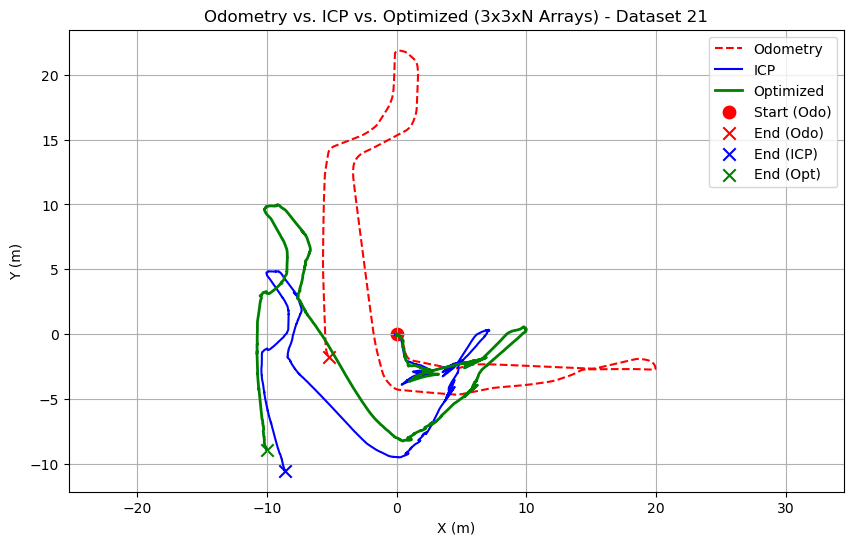

In [35]:
T_opt = build_3x3_array(optimized_poses)
plot_all_trajectories(T_odo,T_icp,T_opt)

Iteration: 0
Iteration 0: World Position: [-0.13323  0.     ] -> Grid Position: (330, 333)
Iteration: 1
Iteration 1: World Position: [-0.13373012  0.00074726] -> Grid Position: (330, 333)
Iteration: 2
Iteration 2: World Position: [-0.13358133  0.00029428] -> Grid Position: (330, 333)
Iteration: 3
Iteration 3: World Position: [-0.13358133  0.00029428] -> Grid Position: (330, 333)
Iteration: 4
Iteration 4: World Position: [-0.13347629 -0.0003027 ] -> Grid Position: (330, 333)
Iteration: 5
Iteration 5: World Position: [-0.13327751 -0.00061299] -> Grid Position: (330, 333)
Iteration: 6
Iteration 6: World Position: [-0.13327751 -0.00061299] -> Grid Position: (330, 333)
Iteration: 7
Iteration 7: World Position: [-0.13326169 -0.00084293] -> Grid Position: (330, 333)
Iteration: 8
Iteration 8: World Position: [-0.133269   -0.00111826] -> Grid Position: (330, 333)
Iteration: 9
Iteration 9: World Position: [-0.13357976 -0.00176699] -> Grid Position: (330, 333)
Iteration: 10
Iteration 10: World Po

Iteration: 89
Iteration 89: World Position: [-0.13189904 -0.01313965] -> Grid Position: (330, 333)
Iteration: 90
Iteration 90: World Position: [-0.13208808 -0.012968  ] -> Grid Position: (330, 333)
Iteration: 91
Iteration 91: World Position: [-0.13188514 -0.01309672] -> Grid Position: (330, 333)
Iteration: 92
Iteration 92: World Position: [-0.13201124 -0.01173122] -> Grid Position: (330, 333)
Iteration: 93
Iteration 93: World Position: [-0.13214843 -0.01152664] -> Grid Position: (330, 333)
Iteration: 94
Iteration 94: World Position: [-0.13184109 -0.01213067] -> Grid Position: (330, 333)
Iteration: 95
Iteration 95: World Position: [-0.13182055 -0.01267917] -> Grid Position: (330, 333)
Iteration: 96
Iteration 96: World Position: [-0.1320659  -0.01235424] -> Grid Position: (330, 333)
Iteration: 97
Iteration 97: World Position: [-0.13145973 -0.01321996] -> Grid Position: (330, 333)
Iteration: 98
Iteration 98: World Position: [-0.13145973 -0.01321996] -> Grid Position: (330, 333)
Iteration:

Iteration: 175
Iteration 175: World Position: [-0.13071356 -0.02067381] -> Grid Position: (330, 333)
Iteration: 176
Iteration 176: World Position: [-0.1306208  -0.02050955] -> Grid Position: (330, 333)
Iteration: 177
Iteration 177: World Position: [-0.13090867 -0.02038576] -> Grid Position: (330, 333)
Iteration: 178
Iteration 178: World Position: [-0.13090867 -0.02038576] -> Grid Position: (330, 333)
Iteration: 179
Iteration 179: World Position: [-0.13042543 -0.02075414] -> Grid Position: (330, 333)
Iteration: 180
Iteration 180: World Position: [-0.13087922 -0.01986926] -> Grid Position: (330, 333)
Iteration: 181
Iteration 181: World Position: [-0.13089582 -0.02055933] -> Grid Position: (330, 333)
Iteration: 182
Iteration 182: World Position: [-0.13072131 -0.02047435] -> Grid Position: (330, 333)
Iteration: 183
Iteration 183: World Position: [-0.13072131 -0.02047435] -> Grid Position: (330, 333)
Iteration: 184
Iteration 184: World Position: [-0.13128898 -0.02145043] -> Grid Position: (

Iteration: 257
Iteration 257: World Position: [-0.1290588  -0.03148586] -> Grid Position: (330, 332)
Iteration: 258
Iteration 258: World Position: [-0.12928669 -0.03175609] -> Grid Position: (330, 332)
Iteration: 259
Iteration 259: World Position: [-0.12933819 -0.03257553] -> Grid Position: (330, 332)
Iteration: 260
Iteration 260: World Position: [-0.12977788 -0.03272479] -> Grid Position: (330, 332)
Iteration: 261
Iteration 261: World Position: [-0.1300874  -0.03354693] -> Grid Position: (330, 332)
Iteration: 262
Iteration 262: World Position: [-0.12923161 -0.03439257] -> Grid Position: (330, 332)
Iteration: 263
Iteration 263: World Position: [-0.12930012 -0.03422892] -> Grid Position: (330, 332)
Iteration: 264
Iteration 264: World Position: [-0.12939817 -0.03469932] -> Grid Position: (330, 332)
Iteration: 265
Iteration 265: World Position: [-0.12924344 -0.03492421] -> Grid Position: (330, 332)
Iteration: 266
Iteration 266: World Position: [-0.12924055 -0.03570471] -> Grid Position: (

Iteration: 339
Iteration 339: World Position: [-0.12763767 -0.05286311] -> Grid Position: (330, 332)
Iteration: 340
Iteration 340: World Position: [-0.12721438 -0.05289394] -> Grid Position: (330, 332)
Iteration: 341
Iteration 341: World Position: [-0.12758882 -0.05335799] -> Grid Position: (330, 332)
Iteration: 342
Iteration 342: World Position: [-0.12679672 -0.05340809] -> Grid Position: (330, 332)
Iteration: 343
Iteration 343: World Position: [-0.12664729 -0.05324088] -> Grid Position: (330, 332)
Iteration: 344
Iteration 344: World Position: [-0.12715146 -0.05347204] -> Grid Position: (330, 332)
Iteration: 345
Iteration 345: World Position: [-0.12701489 -0.05363853] -> Grid Position: (330, 332)
Iteration: 346
Iteration 346: World Position: [-0.126875   -0.05400981] -> Grid Position: (330, 332)
Iteration: 347
Iteration 347: World Position: [-0.12687881 -0.05428573] -> Grid Position: (330, 332)
Iteration: 348
Iteration 348: World Position: [-0.12685539 -0.05395904] -> Grid Position: (

Iteration: 422
Iteration 422: World Position: [-0.1253717  -0.06804139] -> Grid Position: (330, 332)
Iteration: 423
Iteration 423: World Position: [-0.12501925 -0.06813721] -> Grid Position: (330, 332)
Iteration: 424
Iteration 424: World Position: [-0.12508719 -0.06835136] -> Grid Position: (330, 332)
Iteration: 425
Iteration 425: World Position: [-0.12519153 -0.06759716] -> Grid Position: (330, 332)
Iteration: 426
Iteration 426: World Position: [-0.12487167 -0.06906678] -> Grid Position: (331, 332)
Iteration: 427
Iteration 427: World Position: [-0.12467074 -0.06851029] -> Grid Position: (331, 332)
Iteration: 428
Iteration 428: World Position: [-0.12460907 -0.06825116] -> Grid Position: (331, 332)
Iteration: 429
Iteration 429: World Position: [-0.12470649 -0.06866309] -> Grid Position: (331, 332)
Iteration: 430
Iteration 430: World Position: [-0.124523   -0.06870672] -> Grid Position: (331, 332)
Iteration: 431
Iteration 431: World Position: [-0.12432263 -0.06982008] -> Grid Position: (

Iteration: 505
Iteration 505: World Position: [-0.12363956 -0.08092349] -> Grid Position: (331, 331)
Iteration: 506
Iteration 506: World Position: [-0.12302844 -0.08112755] -> Grid Position: (331, 331)
Iteration: 507
Iteration 507: World Position: [-0.12393827 -0.08147747] -> Grid Position: (331, 331)
Iteration: 508
Iteration 508: World Position: [-0.12375983 -0.08336879] -> Grid Position: (331, 331)
Iteration: 509
Iteration 509: World Position: [-0.12393762 -0.08293686] -> Grid Position: (331, 331)
Iteration: 510
Iteration 510: World Position: [-0.12336799 -0.08228002] -> Grid Position: (331, 331)
Iteration: 511
Iteration 511: World Position: [-0.12353776 -0.0830133 ] -> Grid Position: (331, 331)
Iteration: 512
Iteration 512: World Position: [-0.12274322 -0.08332857] -> Grid Position: (331, 331)
Iteration: 513
Iteration 513: World Position: [-0.12200545 -0.08299703] -> Grid Position: (331, 331)
Iteration: 514
Iteration 514: World Position: [-0.12263831 -0.0830353 ] -> Grid Position: (

Iteration: 594
Iteration 594: World Position: [ 0.33405148 -0.32022023] -> Grid Position: (340, 327)
Iteration: 595
Iteration 595: World Position: [ 0.33835925 -0.32955638] -> Grid Position: (340, 326)
Iteration: 596
Iteration 596: World Position: [ 0.34275857 -0.3431008 ] -> Grid Position: (340, 326)
Iteration: 597
Iteration 597: World Position: [ 0.3468144  -0.35201872] -> Grid Position: (340, 326)
Iteration: 598
Iteration 598: World Position: [ 0.3460494  -0.37573778] -> Grid Position: (340, 325)
Iteration: 599
Iteration 599: World Position: [ 0.35097097 -0.38715327] -> Grid Position: (340, 325)
Iteration: 600
Iteration 600: World Position: [ 0.35618889 -0.3981118 ] -> Grid Position: (340, 325)
Iteration: 601
Iteration 601: World Position: [ 0.3596998  -0.41214631] -> Grid Position: (340, 325)
Iteration: 602
Iteration 602: World Position: [ 0.36144508 -0.42382075] -> Grid Position: (340, 325)
Iteration: 603
Iteration 603: World Position: [ 0.36422794 -0.4379459 ] -> Grid Position: (

Iteration: 679
Iteration 679: World Position: [ 0.57753284 -1.6422185 ] -> Grid Position: (345, 300)
Iteration: 680
Iteration 680: World Position: [ 0.58115869 -1.6609619 ] -> Grid Position: (345, 300)
Iteration: 681
Iteration 681: World Position: [ 0.5809386  -1.67571239] -> Grid Position: (345, 299)
Iteration: 682
Iteration 682: World Position: [ 0.57710737 -1.69096737] -> Grid Position: (345, 299)
Iteration: 683
Iteration 683: World Position: [ 0.57774386 -1.70870804] -> Grid Position: (345, 299)
Iteration: 684
Iteration 684: World Position: [ 0.58398565 -1.72245297] -> Grid Position: (345, 299)
Iteration: 685
Iteration 685: World Position: [ 0.58751212 -1.7346138 ] -> Grid Position: (345, 298)
Iteration: 686
Iteration 686: World Position: [ 0.58946159 -1.74439479] -> Grid Position: (345, 298)
Iteration: 687
Iteration 687: World Position: [ 0.59717353 -1.76094085] -> Grid Position: (345, 298)
Iteration: 688
Iteration 688: World Position: [ 0.60470918 -1.77362242] -> Grid Position: (

Iteration: 762
Iteration 762: World Position: [ 1.65354109 -2.35804423] -> Grid Position: (366, 286)
Iteration: 763
Iteration 763: World Position: [ 1.70299486 -2.37144757] -> Grid Position: (367, 286)
Iteration: 764
Iteration 764: World Position: [ 1.79179288 -2.39083884] -> Grid Position: (369, 285)
Iteration: 765
Iteration 765: World Position: [ 1.86281589 -2.40614534] -> Grid Position: (370, 285)
Iteration: 766
Iteration 766: World Position: [ 1.92103884 -2.4375596 ] -> Grid Position: (371, 284)
Iteration: 767
Iteration 767: World Position: [ 1.95445347 -2.45385487] -> Grid Position: (372, 284)
Iteration: 768
Iteration 768: World Position: [ 1.98926009 -2.46662342] -> Grid Position: (373, 284)
Iteration: 769
Iteration 769: World Position: [ 2.00550538 -2.47750235] -> Grid Position: (373, 283)
Iteration: 770
Iteration 770: World Position: [ 2.0373264  -2.48934842] -> Grid Position: (374, 283)
Iteration: 771
Iteration 771: World Position: [ 2.06341348 -2.49724289] -> Grid Position: (

Iteration: 847
Iteration 847: World Position: [ 1.95935022 -2.94842272] -> Grid Position: (372, 274)
Iteration: 848
Iteration 848: World Position: [ 1.99625376 -2.95015832] -> Grid Position: (373, 274)
Iteration: 849
Iteration 849: World Position: [ 1.99193299 -2.9560821 ] -> Grid Position: (373, 274)
Iteration: 850
Iteration 850: World Position: [ 2.00188928 -2.96194147] -> Grid Position: (373, 274)
Iteration: 851
Iteration 851: World Position: [ 2.02206149 -2.96721279] -> Grid Position: (373, 274)
Iteration: 852
Iteration 852: World Position: [ 2.01992442 -2.97278783] -> Grid Position: (373, 274)
Iteration: 853
Iteration 853: World Position: [ 1.97760507 -2.98264887] -> Grid Position: (373, 273)
Iteration: 854
Iteration 854: World Position: [ 1.93756035 -2.99198709] -> Grid Position: (372, 273)
Iteration: 855
Iteration 855: World Position: [ 1.93250176 -2.9963347 ] -> Grid Position: (372, 273)
Iteration: 856
Iteration 856: World Position: [ 1.95101666 -2.99790881] -> Grid Position: (

Iteration: 936
Iteration 936: World Position: [ 0.67463642 -3.67847425] -> Grid Position: (346, 259)
Iteration: 937
Iteration 937: World Position: [ 0.68447712 -3.66931078] -> Grid Position: (347, 260)
Iteration: 938
Iteration 938: World Position: [ 0.68275201 -3.66296827] -> Grid Position: (347, 260)
Iteration: 939
Iteration 939: World Position: [ 0.70028389 -3.64952324] -> Grid Position: (347, 260)
Iteration: 940
Iteration 940: World Position: [ 0.71849995 -3.63558121] -> Grid Position: (347, 260)
Iteration: 941
Iteration 941: World Position: [ 0.72600632 -3.62682301] -> Grid Position: (348, 260)
Iteration: 942
Iteration 942: World Position: [ 0.73524548 -3.61774774] -> Grid Position: (348, 261)
Iteration: 943
Iteration 943: World Position: [ 0.75145292 -3.60782745] -> Grid Position: (348, 261)
Iteration: 944
Iteration 944: World Position: [ 0.7626785  -3.59802308] -> Grid Position: (348, 261)
Iteration: 945
Iteration 945: World Position: [ 0.77284593 -3.58786701] -> Grid Position: (

Iteration: 1018
Iteration 1018: World Position: [ 1.76381184 -3.09242856] -> Grid Position: (368, 271)
Iteration: 1019
Iteration 1019: World Position: [ 1.77504842 -3.08803669] -> Grid Position: (369, 271)
Iteration: 1020
Iteration 1020: World Position: [ 1.78878923 -3.08363607] -> Grid Position: (369, 271)
Iteration: 1021
Iteration 1021: World Position: [ 1.80059076 -3.0797642 ] -> Grid Position: (369, 271)
Iteration: 1022
Iteration 1022: World Position: [ 1.8142708  -3.07520676] -> Grid Position: (369, 271)
Iteration: 1023
Iteration 1023: World Position: [ 1.82981602 -3.07019816] -> Grid Position: (370, 272)
Iteration: 1024
Iteration 1024: World Position: [ 1.84851691 -3.06504137] -> Grid Position: (370, 272)
Iteration: 1025
Iteration 1025: World Position: [ 1.87410798 -3.05685353] -> Grid Position: (370, 272)
Iteration: 1026
Iteration 1026: World Position: [ 1.89833815 -3.04653167] -> Grid Position: (371, 272)
Iteration: 1027
Iteration 1027: World Position: [ 1.91733783 -3.04178796]

Iteration: 1104
Iteration 1104: World Position: [ 2.92863891 -2.77597807] -> Grid Position: (392, 277)
Iteration: 1105
Iteration 1105: World Position: [ 2.93908479 -2.7735858 ] -> Grid Position: (392, 278)
Iteration: 1106
Iteration 1106: World Position: [ 2.95292795 -2.76880561] -> Grid Position: (392, 278)
Iteration: 1107
Iteration 1107: World Position: [ 2.96395963 -2.76621126] -> Grid Position: (392, 278)
Iteration: 1108
Iteration 1108: World Position: [ 2.97797128 -2.76140036] -> Grid Position: (393, 278)
Iteration: 1109
Iteration 1109: World Position: [ 2.9924225  -2.75719418] -> Grid Position: (393, 278)
Iteration: 1110
Iteration 1110: World Position: [ 3.00694836 -2.75236736] -> Grid Position: (393, 278)
Iteration: 1111
Iteration 1111: World Position: [ 3.02027459 -2.74871148] -> Grid Position: (393, 278)
Iteration: 1112
Iteration 1112: World Position: [ 3.03315443 -2.74241791] -> Grid Position: (394, 278)
Iteration: 1113
Iteration 1113: World Position: [ 3.04627618 -2.73798764]

Iteration: 1192
Iteration 1192: World Position: [ 3.63334177 -2.61948154] -> Grid Position: (406, 281)
Iteration: 1193
Iteration 1193: World Position: [ 3.63334177 -2.61948154] -> Grid Position: (406, 281)
Iteration: 1194
Iteration 1194: World Position: [ 3.6326578  -2.61763011] -> Grid Position: (406, 281)
Iteration: 1195
Iteration 1195: World Position: [ 3.72147131 -2.57366538] -> Grid Position: (407, 282)
Iteration: 1196
Iteration 1196: World Position: [ 3.73441803 -2.56909063] -> Grid Position: (408, 282)
Iteration: 1197
Iteration 1197: World Position: [ 3.73441803 -2.56909063] -> Grid Position: (408, 282)
Iteration: 1198
Iteration 1198: World Position: [ 3.75115257 -2.56301293] -> Grid Position: (408, 282)
Iteration: 1199
Iteration 1199: World Position: [ 3.7834487  -2.54772509] -> Grid Position: (409, 282)
Iteration: 1200
Iteration 1200: World Position: [ 3.80047268 -2.54074559] -> Grid Position: (409, 282)
Iteration: 1201
Iteration 1201: World Position: [ 3.80047268 -2.54074559]

Iteration: 1272
Iteration 1272: World Position: [ 4.51976763 -2.32051165] -> Grid Position: (423, 287)
Iteration: 1273
Iteration 1273: World Position: [ 4.57667218 -2.28712778] -> Grid Position: (425, 287)
Iteration: 1274
Iteration 1274: World Position: [ 4.59160134 -2.27600887] -> Grid Position: (425, 287)
Iteration: 1275
Iteration 1275: World Position: [ 4.56318766 -2.29116067] -> Grid Position: (424, 287)
Iteration: 1276
Iteration 1276: World Position: [ 4.540661   -2.30921425] -> Grid Position: (424, 287)
Iteration: 1277
Iteration 1277: World Position: [ 4.5354785  -2.31893123] -> Grid Position: (424, 287)
Iteration: 1278
Iteration 1278: World Position: [ 4.5418603  -2.31794182] -> Grid Position: (424, 287)
Iteration: 1279
Iteration 1279: World Position: [ 4.55527642 -2.31055184] -> Grid Position: (424, 287)
Iteration: 1280
Iteration 1280: World Position: [ 4.56378554 -2.3062752 ] -> Grid Position: (424, 287)
Iteration: 1281
Iteration 1281: World Position: [ 4.57779476 -2.29907271]

Iteration: 1359
Iteration 1359: World Position: [ 3.78993216 -3.08012767] -> Grid Position: (409, 271)
Iteration: 1360
Iteration 1360: World Position: [ 3.79984486 -3.07418707] -> Grid Position: (409, 272)
Iteration: 1361
Iteration 1361: World Position: [ 3.80888114 -3.06690008] -> Grid Position: (409, 272)
Iteration: 1362
Iteration 1362: World Position: [ 3.81953277 -3.05820689] -> Grid Position: (409, 272)
Iteration: 1363
Iteration 1363: World Position: [ 3.82877    -3.05345191] -> Grid Position: (410, 272)
Iteration: 1364
Iteration 1364: World Position: [ 3.84091635 -3.04429707] -> Grid Position: (410, 272)
Iteration: 1365
Iteration 1365: World Position: [ 3.85335038 -3.03503569] -> Grid Position: (410, 272)
Iteration: 1366
Iteration 1366: World Position: [ 3.86432539 -3.0258676 ] -> Grid Position: (410, 272)
Iteration: 1367
Iteration 1367: World Position: [ 3.87642296 -3.0178352 ] -> Grid Position: (411, 273)
Iteration: 1368
Iteration 1368: World Position: [ 3.88841293 -3.0088597 ]

Iteration: 1449
Iteration 1449: World Position: [ 4.81809286 -2.04979987] -> Grid Position: (429, 292)
Iteration: 1450
Iteration 1450: World Position: [ 4.83194978 -2.02954985] -> Grid Position: (430, 292)
Iteration: 1451
Iteration 1451: World Position: [ 4.84533442 -2.00965254] -> Grid Position: (430, 293)
Iteration: 1452
Iteration 1452: World Position: [ 4.85767718 -1.98871505] -> Grid Position: (430, 293)
Iteration: 1453
Iteration 1453: World Position: [ 4.86822528 -1.97146022] -> Grid Position: (430, 294)
Iteration: 1454
Iteration 1454: World Position: [ 4.87917125 -1.95342567] -> Grid Position: (431, 294)
Iteration: 1455
Iteration 1455: World Position: [ 4.89288213 -1.93289437] -> Grid Position: (431, 294)
Iteration: 1456
Iteration 1456: World Position: [ 4.90515817 -1.91234399] -> Grid Position: (431, 295)
Iteration: 1457
Iteration 1457: World Position: [ 4.91801683 -1.89020535] -> Grid Position: (431, 295)
Iteration: 1458
Iteration 1458: World Position: [ 4.92884228 -1.87023406]

Iteration: 1536
Iteration 1536: World Position: [ 5.99916308 -0.22058608] -> Grid Position: (453, 329)
Iteration: 1537
Iteration 1537: World Position: [ 6.01229234 -0.2058508 ] -> Grid Position: (453, 329)
Iteration: 1538
Iteration 1538: World Position: [ 6.02485304 -0.18973274] -> Grid Position: (453, 329)
Iteration: 1539
Iteration 1539: World Position: [ 6.03715915 -0.17467025] -> Grid Position: (454, 330)
Iteration: 1540
Iteration 1540: World Position: [ 6.05091514 -0.15863443] -> Grid Position: (454, 330)
Iteration: 1541
Iteration 1541: World Position: [ 6.06391232 -0.14504197] -> Grid Position: (454, 330)
Iteration: 1542
Iteration 1542: World Position: [ 6.07651095 -0.13142311] -> Grid Position: (455, 330)
Iteration: 1543
Iteration 1543: World Position: [ 6.08858791 -0.11764142] -> Grid Position: (455, 331)
Iteration: 1544
Iteration 1544: World Position: [ 6.10184035 -0.10472479] -> Grid Position: (455, 331)
Iteration: 1545
Iteration 1545: World Position: [ 6.11321954 -0.09276544]

Iteration: 1623
Iteration 1623: World Position: [7.01375355 0.2734015 ] -> Grid Position: (473, 338)
Iteration: 1624
Iteration 1624: World Position: [7.0162461  0.26635829] -> Grid Position: (473, 338)
Iteration: 1625
Iteration 1625: World Position: [7.08600472 0.34045482] -> Grid Position: (475, 340)
Iteration: 1626
Iteration 1626: World Position: [7.09055933 0.33688413] -> Grid Position: (475, 340)
Iteration: 1627
Iteration 1627: World Position: [7.09457511 0.3325056 ] -> Grid Position: (475, 340)
Iteration: 1628
Iteration 1628: World Position: [7.09627063 0.32964767] -> Grid Position: (475, 340)
Iteration: 1629
Iteration 1629: World Position: [7.09657737 0.32253944] -> Grid Position: (475, 339)
Iteration: 1630
Iteration 1630: World Position: [7.10284543 0.32266405] -> Grid Position: (475, 339)
Iteration: 1631
Iteration 1631: World Position: [7.10315493 0.31351734] -> Grid Position: (475, 339)
Iteration: 1632
Iteration 1632: World Position: [7.10191053 0.30239446] -> Grid Position: (

Iteration: 1709
Iteration 1709: World Position: [ 6.74023137 -0.24388677] -> Grid Position: (468, 328)
Iteration: 1710
Iteration 1710: World Position: [ 6.72566804 -0.25927081] -> Grid Position: (468, 328)
Iteration: 1711
Iteration 1711: World Position: [ 6.71091738 -0.27359286] -> Grid Position: (467, 328)
Iteration: 1712
Iteration 1712: World Position: [ 6.69323916 -0.29242196] -> Grid Position: (467, 327)
Iteration: 1713
Iteration 1713: World Position: [ 6.677419   -0.30851411] -> Grid Position: (467, 327)
Iteration: 1714
Iteration 1714: World Position: [ 6.6637193  -0.32383503] -> Grid Position: (466, 327)
Iteration: 1715
Iteration 1715: World Position: [ 6.6470719  -0.34215504] -> Grid Position: (466, 326)
Iteration: 1716
Iteration 1716: World Position: [ 6.62917355 -0.36144627] -> Grid Position: (466, 326)
Iteration: 1717
Iteration 1717: World Position: [ 6.61308789 -0.37671366] -> Grid Position: (465, 325)
Iteration: 1718
Iteration 1718: World Position: [ 6.59960939 -0.38954088]

Iteration: 1791
Iteration 1791: World Position: [ 5.63070214 -1.47580447] -> Grid Position: (446, 303)
Iteration: 1792
Iteration 1792: World Position: [ 5.61854968 -1.49049931] -> Grid Position: (445, 303)
Iteration: 1793
Iteration 1793: World Position: [ 5.60694093 -1.50194795] -> Grid Position: (445, 303)
Iteration: 1794
Iteration 1794: World Position: [ 5.59428337 -1.51660126] -> Grid Position: (445, 303)
Iteration: 1795
Iteration 1795: World Position: [ 5.58639071 -1.5270194 ] -> Grid Position: (445, 302)
Iteration: 1796
Iteration 1796: World Position: [ 5.57247063 -1.54274381] -> Grid Position: (444, 302)
Iteration: 1797
Iteration 1797: World Position: [ 5.54717759 -1.57131667] -> Grid Position: (444, 302)
Iteration: 1798
Iteration 1798: World Position: [ 5.54717759 -1.57131667] -> Grid Position: (444, 302)
Iteration: 1799
Iteration 1799: World Position: [ 5.53630136 -1.58310386] -> Grid Position: (444, 301)
Iteration: 1800
Iteration 1800: World Position: [ 5.52227902 -1.59787868]

Iteration: 1872
Iteration 1872: World Position: [ 4.81125749 -2.35522794] -> Grid Position: (429, 286)
Iteration: 1873
Iteration 1873: World Position: [ 4.8041024  -2.37085399] -> Grid Position: (429, 286)
Iteration: 1874
Iteration 1874: World Position: [ 4.79922759 -2.37780509] -> Grid Position: (429, 285)
Iteration: 1875
Iteration 1875: World Position: [ 4.7926823 -2.3922126] -> Grid Position: (429, 285)
Iteration: 1876
Iteration 1876: World Position: [ 4.78964055 -2.40131471] -> Grid Position: (429, 285)
Iteration: 1877
Iteration 1877: World Position: [ 4.78566059 -2.41320803] -> Grid Position: (429, 285)
Iteration: 1878
Iteration 1878: World Position: [ 4.78330623 -2.41912606] -> Grid Position: (429, 285)
Iteration: 1879
Iteration 1879: World Position: [ 4.77315898 -2.44108515] -> Grid Position: (428, 284)
Iteration: 1880
Iteration 1880: World Position: [ 4.7675314  -2.45744043] -> Grid Position: (428, 284)
Iteration: 1881
Iteration 1881: World Position: [ 4.76188204 -2.47368439] -

Iteration: 1953
Iteration 1953: World Position: [ 4.35165198 -3.52231225] -> Grid Position: (420, 263)
Iteration: 1954
Iteration 1954: World Position: [ 4.30754648 -3.5920218 ] -> Grid Position: (419, 261)
Iteration: 1955
Iteration 1955: World Position: [ 4.28817288 -3.62396583] -> Grid Position: (419, 261)
Iteration: 1956
Iteration 1956: World Position: [ 4.24184949 -3.70326942] -> Grid Position: (418, 259)
Iteration: 1957
Iteration 1957: World Position: [ 4.19907614 -3.77921205] -> Grid Position: (417, 257)
Iteration: 1958
Iteration 1958: World Position: [ 4.15142754 -3.87018258] -> Grid Position: (416, 256)
Iteration: 1959
Iteration 1959: World Position: [ 4.11483202 -3.94363492] -> Grid Position: (415, 254)
Iteration: 1960
Iteration 1960: World Position: [ 4.06638968 -4.03184665] -> Grid Position: (414, 252)
Iteration: 1961
Iteration 1961: World Position: [ 4.03020327 -4.10281569] -> Grid Position: (414, 251)
Iteration: 1962
Iteration 1962: World Position: [ 4.01620255 -4.14160059]

Iteration: 2039
Iteration 2039: World Position: [ 3.82932001 -4.88780245] -> Grid Position: (410, 235)
Iteration: 2040
Iteration 2040: World Position: [ 3.83209457 -4.88243627] -> Grid Position: (410, 235)
Iteration: 2041
Iteration 2041: World Position: [ 3.83307565 -4.87689733] -> Grid Position: (410, 235)
Iteration: 2042
Iteration 2042: World Position: [ 3.83426295 -4.87642459] -> Grid Position: (410, 235)
Iteration: 2043
Iteration 2043: World Position: [ 3.83812985 -4.87350762] -> Grid Position: (410, 236)
Iteration: 2044
Iteration 2044: World Position: [ 3.84634287 -4.86288567] -> Grid Position: (410, 236)
Iteration: 2045
Iteration 2045: World Position: [ 3.86566054 -4.83042232] -> Grid Position: (410, 236)
Iteration: 2046
Iteration 2046: World Position: [ 3.91397641 -4.73854339] -> Grid Position: (411, 238)
Iteration: 2047
Iteration 2047: World Position: [ 3.94503754 -4.67783476] -> Grid Position: (412, 239)
Iteration: 2048
Iteration 2048: World Position: [ 4.01485669 -4.52703409]

Iteration: 2130
Iteration 2130: World Position: [ 3.78744974 -5.07495779] -> Grid Position: (409, 232)
Iteration: 2131
Iteration 2131: World Position: [ 3.82781497 -5.0099712 ] -> Grid Position: (410, 233)
Iteration: 2132
Iteration 2132: World Position: [ 3.8792332 -4.9327117] -> Grid Position: (411, 234)
Iteration: 2133
Iteration 2133: World Position: [ 3.92327025 -4.86858428] -> Grid Position: (411, 236)
Iteration: 2134
Iteration 2134: World Position: [ 3.95629931 -4.82189097] -> Grid Position: (412, 237)
Iteration: 2135
Iteration 2135: World Position: [ 3.98972396 -4.77348122] -> Grid Position: (413, 238)
Iteration: 2136
Iteration 2136: World Position: [ 4.04105587 -4.6994446 ] -> Grid Position: (414, 239)
Iteration: 2137
Iteration 2137: World Position: [ 4.10836721 -4.5973565 ] -> Grid Position: (415, 241)
Iteration: 2138
Iteration 2138: World Position: [ 4.19025528 -4.47776586] -> Grid Position: (417, 243)
Iteration: 2139
Iteration 2139: World Position: [ 4.28518694 -4.33196235] -

Iteration: 2210
Iteration 2210: World Position: [ 3.88562711 -4.93621625] -> Grid Position: (411, 234)
Iteration: 2211
Iteration 2211: World Position: [ 3.8727191 -4.9551411] -> Grid Position: (410, 234)
Iteration: 2212
Iteration 2212: World Position: [ 3.85978843 -4.97442212] -> Grid Position: (410, 234)
Iteration: 2213
Iteration 2213: World Position: [ 3.8471012  -4.99401262] -> Grid Position: (410, 233)
Iteration: 2214
Iteration 2214: World Position: [ 3.83599355 -5.0118184 ] -> Grid Position: (410, 233)
Iteration: 2215
Iteration 2215: World Position: [ 3.82378632 -5.02971456] -> Grid Position: (409, 232)
Iteration: 2216
Iteration 2216: World Position: [ 3.81135872 -5.04778703] -> Grid Position: (409, 232)
Iteration: 2217
Iteration 2217: World Position: [ 3.79997986 -5.0647552 ] -> Grid Position: (409, 232)
Iteration: 2218
Iteration 2218: World Position: [ 3.78713329 -5.08387933] -> Grid Position: (409, 231)
Iteration: 2219
Iteration 2219: World Position: [ 3.77573133 -5.09830734] -

Iteration: 2295
Iteration 2295: World Position: [ 2.77942612 -6.82499693] -> Grid Position: (389, 197)
Iteration: 2296
Iteration 2296: World Position: [ 2.76808063 -6.84735722] -> Grid Position: (388, 196)
Iteration: 2297
Iteration 2297: World Position: [ 2.75628862 -6.86810698] -> Grid Position: (388, 196)
Iteration: 2298
Iteration 2298: World Position: [ 2.77296989 -6.86089325] -> Grid Position: (388, 196)
Iteration: 2299
Iteration 2299: World Position: [ 2.76067365 -6.88467396] -> Grid Position: (388, 195)
Iteration: 2300
Iteration 2300: World Position: [ 2.74890399 -6.90649688] -> Grid Position: (388, 195)
Iteration: 2301
Iteration 2301: World Position: [ 2.7367383  -6.92955509] -> Grid Position: (388, 194)
Iteration: 2302
Iteration 2302: World Position: [ 2.71224612 -6.97512228] -> Grid Position: (387, 193)
Iteration: 2303
Iteration 2303: World Position: [ 2.69955129 -6.99749242] -> Grid Position: (387, 193)
Iteration: 2304
Iteration 2304: World Position: [ 2.67263581 -7.04423436]

Iteration: 2380
Iteration 2380: World Position: [ 2.10450895 -7.72220333] -> Grid Position: (375, 179)
Iteration: 2381
Iteration 2381: World Position: [ 2.10450895 -7.72220333] -> Grid Position: (375, 179)
Iteration: 2382
Iteration 2382: World Position: [ 2.1114444  -7.65730858] -> Grid Position: (375, 180)
Iteration: 2383
Iteration 2383: World Position: [ 2.10133623 -7.67374224] -> Grid Position: (375, 180)
Iteration: 2384
Iteration 2384: World Position: [ 2.09338535 -7.68283947] -> Grid Position: (375, 179)
Iteration: 2385
Iteration 2385: World Position: [ 2.08568521 -7.69104278] -> Grid Position: (375, 179)
Iteration: 2386
Iteration 2386: World Position: [ 2.077899   -7.70107947] -> Grid Position: (375, 179)
Iteration: 2387
Iteration 2387: World Position: [ 2.06930685 -7.71113477] -> Grid Position: (374, 179)
Iteration: 2388
Iteration 2388: World Position: [ 2.05400902 -7.73239252] -> Grid Position: (374, 178)
Iteration: 2389
Iteration 2389: World Position: [ 2.05400902 -7.73239252]

Iteration: 2465
Iteration 2465: World Position: [ 1.11868712 -8.77722714] -> Grid Position: (355, 157)
Iteration: 2466
Iteration 2466: World Position: [ 1.11369348 -8.78674141] -> Grid Position: (355, 157)
Iteration: 2467
Iteration 2467: World Position: [ 1.11369348 -8.78674141] -> Grid Position: (355, 157)
Iteration: 2468
Iteration 2468: World Position: [ 1.10548043 -8.79573158] -> Grid Position: (355, 157)
Iteration: 2469
Iteration 2469: World Position: [ 1.10548043 -8.79573158] -> Grid Position: (355, 157)
Iteration: 2470
Iteration 2470: World Position: [ 1.09071054 -8.80785796] -> Grid Position: (355, 157)
Iteration: 2471
Iteration 2471: World Position: [ 1.0798842  -8.81577554] -> Grid Position: (355, 157)
Iteration: 2472
Iteration 2472: World Position: [ 1.0798842  -8.81577554] -> Grid Position: (355, 157)
Iteration: 2473
Iteration 2473: World Position: [ 1.07617455 -8.82000538] -> Grid Position: (355, 157)
Iteration: 2474
Iteration 2474: World Position: [ 1.07617455 -8.82000538]

Iteration: 2545
Iteration 2545: World Position: [ 0.72282949 -9.33197199] -> Grid Position: (347, 146)
Iteration: 2546
Iteration 2546: World Position: [ 0.70641443 -9.34044525] -> Grid Position: (347, 146)
Iteration: 2547
Iteration 2547: World Position: [ 0.68371863 -9.34477789] -> Grid Position: (347, 146)
Iteration: 2548
Iteration 2548: World Position: [ 0.668011  -9.3502981] -> Grid Position: (346, 146)
Iteration: 2549
Iteration 2549: World Position: [ 0.65421452 -9.35730316] -> Grid Position: (346, 146)
Iteration: 2550
Iteration 2550: World Position: [ 0.63733417 -9.36393496] -> Grid Position: (346, 146)
Iteration: 2551
Iteration 2551: World Position: [ 0.62238269 -9.36873611] -> Grid Position: (345, 146)
Iteration: 2552
Iteration 2552: World Position: [ 0.60915606 -9.37579321] -> Grid Position: (345, 145)
Iteration: 2553
Iteration 2553: World Position: [ 0.58552082 -9.38641776] -> Grid Position: (345, 145)
Iteration: 2554
Iteration 2554: World Position: [ 0.56812272 -9.38969253] -

Iteration: 2628
Iteration 2628: World Position: [-0.89835992 -9.25256544] -> Grid Position: (315, 148)
Iteration: 2629
Iteration 2629: World Position: [-0.92112954 -9.24240285] -> Grid Position: (315, 148)
Iteration: 2630
Iteration 2630: World Position: [-0.94017001 -9.23307717] -> Grid Position: (314, 148)
Iteration: 2631
Iteration 2631: World Position: [-0.9563209  -9.22491928] -> Grid Position: (314, 149)
Iteration: 2632
Iteration 2632: World Position: [-0.98151952 -9.21813846] -> Grid Position: (313, 149)
Iteration: 2633
Iteration 2633: World Position: [-1.00124652 -9.20505547] -> Grid Position: (313, 149)
Iteration: 2634
Iteration 2634: World Position: [-1.0239347  -9.19592783] -> Grid Position: (313, 149)
Iteration: 2635
Iteration 2635: World Position: [-1.04557092 -9.18486732] -> Grid Position: (312, 149)
Iteration: 2636
Iteration 2636: World Position: [-1.05911006 -9.1745836 ] -> Grid Position: (312, 150)
Iteration: 2637
Iteration 2637: World Position: [-1.07958012 -9.16405784]

Iteration: 2714
Iteration 2714: World Position: [-2.33466921 -8.41021217] -> Grid Position: (286, 165)
Iteration: 2715
Iteration 2715: World Position: [-2.34507453 -8.39919396] -> Grid Position: (286, 165)
Iteration: 2716
Iteration 2716: World Position: [-2.35323285 -8.3891408 ] -> Grid Position: (286, 165)
Iteration: 2717
Iteration 2717: World Position: [-2.36017821 -8.38145486] -> Grid Position: (286, 165)
Iteration: 2718
Iteration 2718: World Position: [-2.36210754 -8.37776052] -> Grid Position: (286, 165)
Iteration: 2719
Iteration 2719: World Position: [-2.37173794 -8.36821549] -> Grid Position: (286, 166)
Iteration: 2720
Iteration 2720: World Position: [-2.38266638 -8.35577733] -> Grid Position: (285, 166)
Iteration: 2721
Iteration 2721: World Position: [-2.39808347 -8.35205898] -> Grid Position: (285, 166)
Iteration: 2722
Iteration 2722: World Position: [-2.4025287  -8.34538188] -> Grid Position: (285, 166)
Iteration: 2723
Iteration 2723: World Position: [-2.40909296 -8.34150874]

Iteration: 2795
Iteration 2795: World Position: [-3.2930419  -7.46315519] -> Grid Position: (267, 184)
Iteration: 2796
Iteration 2796: World Position: [-3.30500155 -7.45184165] -> Grid Position: (267, 184)
Iteration: 2797
Iteration 2797: World Position: [-3.31562045 -7.44093775] -> Grid Position: (267, 184)
Iteration: 2798
Iteration 2798: World Position: [-3.32823088 -7.42623671] -> Grid Position: (266, 184)
Iteration: 2799
Iteration 2799: World Position: [-3.34286595 -7.41217576] -> Grid Position: (266, 185)
Iteration: 2800
Iteration 2800: World Position: [-3.35317853 -7.40025378] -> Grid Position: (266, 185)
Iteration: 2801
Iteration 2801: World Position: [-3.36478264 -7.38911021] -> Grid Position: (266, 185)
Iteration: 2802
Iteration 2802: World Position: [-3.37598549 -7.37837115] -> Grid Position: (265, 185)
Iteration: 2803
Iteration 2803: World Position: [-3.3870689  -7.36741229] -> Grid Position: (265, 186)
Iteration: 2804
Iteration 2804: World Position: [-3.40253692 -7.352393  ]

Iteration: 2879
Iteration 2879: World Position: [-4.38793066 -6.2807507 ] -> Grid Position: (245, 207)
Iteration: 2880
Iteration 2880: World Position: [-4.40086427 -6.26728753] -> Grid Position: (245, 208)
Iteration: 2881
Iteration 2881: World Position: [-4.40086427 -6.26728753] -> Grid Position: (245, 208)
Iteration: 2882
Iteration 2882: World Position: [-4.41351562 -6.25296354] -> Grid Position: (245, 208)
Iteration: 2883
Iteration 2883: World Position: [-4.44497117 -6.21801672] -> Grid Position: (244, 209)
Iteration: 2884
Iteration 2884: World Position: [-4.46080966 -6.20103762] -> Grid Position: (244, 209)
Iteration: 2885
Iteration 2885: World Position: [-4.47426418 -6.1872957 ] -> Grid Position: (244, 209)
Iteration: 2886
Iteration 2886: World Position: [-4.47426418 -6.1872957 ] -> Grid Position: (244, 209)
Iteration: 2887
Iteration 2887: World Position: [-4.5026467  -6.15556121] -> Grid Position: (243, 210)
Iteration: 2888
Iteration 2888: World Position: [-4.51768067 -6.13845061]

Iteration: 2964
Iteration 2964: World Position: [-5.75703011 -4.83411387] -> Grid Position: (218, 236)
Iteration: 2965
Iteration 2965: World Position: [-5.77280781 -4.81648857] -> Grid Position: (218, 237)
Iteration: 2966
Iteration 2966: World Position: [-5.77280781 -4.81648857] -> Grid Position: (218, 237)
Iteration: 2967
Iteration 2967: World Position: [-5.80951259 -4.77802486] -> Grid Position: (217, 237)
Iteration: 2968
Iteration 2968: World Position: [-5.8252243  -4.76117696] -> Grid Position: (216, 238)
Iteration: 2969
Iteration 2969: World Position: [-5.8252243  -4.76117696] -> Grid Position: (216, 238)
Iteration: 2970
Iteration 2970: World Position: [-5.84137647 -4.74500504] -> Grid Position: (216, 238)
Iteration: 2971
Iteration 2971: World Position: [-5.87966848 -4.69719041] -> Grid Position: (215, 239)
Iteration: 2972
Iteration 2972: World Position: [-5.87966848 -4.69719041] -> Grid Position: (215, 239)
Iteration: 2973
Iteration 2973: World Position: [-5.9126603  -4.66806389]

Iteration: 3048
Iteration 3048: World Position: [-7.26105618 -3.32166291] -> Grid Position: (188, 267)
Iteration: 3049
Iteration 3049: World Position: [-7.29969676 -3.28879694] -> Grid Position: (187, 267)
Iteration: 3050
Iteration 3050: World Position: [-7.29969676 -3.28879694] -> Grid Position: (187, 267)
Iteration: 3051
Iteration 3051: World Position: [-7.33802722 -3.25414716] -> Grid Position: (186, 268)
Iteration: 3052
Iteration 3052: World Position: [-7.33802722 -3.25414716] -> Grid Position: (186, 268)
Iteration: 3053
Iteration 3053: World Position: [-7.37617676 -3.2191019 ] -> Grid Position: (185, 269)
Iteration: 3054
Iteration 3054: World Position: [-7.37617676 -3.2191019 ] -> Grid Position: (185, 269)
Iteration: 3055
Iteration 3055: World Position: [-7.41666515 -3.18255866] -> Grid Position: (185, 269)
Iteration: 3056
Iteration 3056: World Position: [-7.41666515 -3.18255866] -> Grid Position: (185, 269)
Iteration: 3057
Iteration 3057: World Position: [-7.4544113  -3.14154927]

Iteration: 3130
Iteration 3130: World Position: [-8.39006665 -1.63907387] -> Grid Position: (165, 300)
Iteration: 3131
Iteration 3131: World Position: [-8.39060618 -1.63865185] -> Grid Position: (165, 300)
Iteration: 3132
Iteration 3132: World Position: [-8.39155221 -1.61681469] -> Grid Position: (165, 301)
Iteration: 3133
Iteration 3133: World Position: [-8.39067462 -1.59391396] -> Grid Position: (165, 301)
Iteration: 3134
Iteration 3134: World Position: [-8.38995264 -1.57364318] -> Grid Position: (165, 302)
Iteration: 3135
Iteration 3135: World Position: [-8.39390773 -1.54673817] -> Grid Position: (165, 302)
Iteration: 3136
Iteration 3136: World Position: [-8.39415016 -1.52856699] -> Grid Position: (165, 302)
Iteration: 3137
Iteration 3137: World Position: [-8.38728923 -1.48546309] -> Grid Position: (165, 303)
Iteration: 3138
Iteration 3138: World Position: [-8.38786558 -1.48547823] -> Grid Position: (165, 303)
Iteration: 3139
Iteration 3139: World Position: [-8.38691695 -1.46415107]

Iteration: 3212
Iteration 3212: World Position: [-7.89137043  0.26005613] -> Grid Position: (175, 338)
Iteration: 3213
Iteration 3213: World Position: [-7.88478277  0.28421815] -> Grid Position: (175, 339)
Iteration: 3214
Iteration 3214: World Position: [-7.87856567  0.31046841] -> Grid Position: (175, 339)
Iteration: 3215
Iteration 3215: World Position: [-7.86687963  0.35969951] -> Grid Position: (176, 340)
Iteration: 3216
Iteration 3216: World Position: [-7.86033035  0.38424702] -> Grid Position: (176, 341)
Iteration: 3217
Iteration 3217: World Position: [-7.85387532  0.40938246] -> Grid Position: (176, 341)
Iteration: 3218
Iteration 3218: World Position: [-7.85387532  0.40938246] -> Grid Position: (176, 341)
Iteration: 3219
Iteration 3219: World Position: [-7.84066095  0.45909559] -> Grid Position: (176, 342)
Iteration: 3220
Iteration 3220: World Position: [-7.83230738  0.48447929] -> Grid Position: (176, 343)
Iteration: 3221
Iteration 3221: World Position: [-7.82347326  0.51051018]

Iteration: 3297
Iteration 3297: World Position: [-7.38989236  2.12950406] -> Grid Position: (185, 376)
Iteration: 3298
Iteration 3298: World Position: [-7.38989236  2.12950406] -> Grid Position: (185, 376)
Iteration: 3299
Iteration 3299: World Position: [-7.39775004  2.16382634] -> Grid Position: (185, 376)
Iteration: 3300
Iteration 3300: World Position: [-7.40903248  2.18560453] -> Grid Position: (185, 377)
Iteration: 3301
Iteration 3301: World Position: [-7.41217515  2.20214117] -> Grid Position: (185, 377)
Iteration: 3302
Iteration 3302: World Position: [-7.41217515  2.20214117] -> Grid Position: (185, 377)
Iteration: 3303
Iteration 3303: World Position: [-7.42817533  2.24525646] -> Grid Position: (184, 378)
Iteration: 3304
Iteration 3304: World Position: [-7.42817533  2.24525646] -> Grid Position: (184, 378)
Iteration: 3305
Iteration 3305: World Position: [-7.43920526  2.28191551] -> Grid Position: (184, 379)
Iteration: 3306
Iteration 3306: World Position: [-7.43920526  2.28191551]

Iteration: 3382
Iteration 3382: World Position: [-8.07236386  3.52613828] -> Grid Position: (172, 404)
Iteration: 3383
Iteration 3383: World Position: [-8.09886868  3.56365096] -> Grid Position: (171, 404)
Iteration: 3384
Iteration 3384: World Position: [-8.09886868  3.56365096] -> Grid Position: (171, 404)
Iteration: 3385
Iteration 3385: World Position: [-8.12786674  3.60389187] -> Grid Position: (170, 405)
Iteration: 3386
Iteration 3386: World Position: [-8.12786674  3.60389187] -> Grid Position: (170, 405)
Iteration: 3387
Iteration 3387: World Position: [-8.15443521  3.64385944] -> Grid Position: (170, 406)
Iteration: 3388
Iteration 3388: World Position: [-8.15443521  3.64385944] -> Grid Position: (170, 406)
Iteration: 3389
Iteration 3389: World Position: [-8.16774959  3.66321135] -> Grid Position: (170, 406)
Iteration: 3390
Iteration 3390: World Position: [-8.18313977  3.68416639] -> Grid Position: (169, 407)
Iteration: 3391
Iteration 3391: World Position: [-8.21327149  3.72645994]

Iteration: 3468
Iteration 3468: World Position: [-9.33387973  4.82072428] -> Grid Position: (146, 429)
Iteration: 3469
Iteration 3469: World Position: [-9.33387973  4.82072428] -> Grid Position: (146, 429)
Iteration: 3470
Iteration 3470: World Position: [-9.37704371  4.82242892] -> Grid Position: (145, 429)
Iteration: 3471
Iteration 3471: World Position: [-9.40044614  4.82642135] -> Grid Position: (145, 430)
Iteration: 3472
Iteration 3472: World Position: [-9.42626058  4.82762163] -> Grid Position: (144, 430)
Iteration: 3473
Iteration 3473: World Position: [-9.47034517  4.82853395] -> Grid Position: (144, 430)
Iteration: 3474
Iteration 3474: World Position: [-9.49647558  4.82961372] -> Grid Position: (143, 430)
Iteration: 3475
Iteration 3475: World Position: [-9.52209087  4.83366808] -> Grid Position: (143, 430)
Iteration: 3476
Iteration 3476: World Position: [-9.56915654  4.83365522] -> Grid Position: (142, 430)
Iteration: 3477
Iteration 3477: World Position: [-9.59176177  4.83386273]

Iteration: 3553
Iteration 3553: World Position: [-9.69307352  4.1151861 ] -> Grid Position: (139, 415)
Iteration: 3554
Iteration 3554: World Position: [-9.66549973  4.07424923] -> Grid Position: (140, 414)
Iteration: 3555
Iteration 3555: World Position: [-9.65196307  4.05353423] -> Grid Position: (140, 414)
Iteration: 3556
Iteration 3556: World Position: [-9.63757246  4.0341109 ] -> Grid Position: (140, 414)
Iteration: 3557
Iteration 3557: World Position: [-9.60823276  3.99103469] -> Grid Position: (141, 413)
Iteration: 3558
Iteration 3558: World Position: [-9.5925767  3.9681052] -> Grid Position: (141, 412)
Iteration: 3559
Iteration 3559: World Position: [-9.57740963  3.94726589] -> Grid Position: (141, 412)
Iteration: 3560
Iteration 3560: World Position: [-9.56210535  3.92640328] -> Grid Position: (142, 412)
Iteration: 3561
Iteration 3561: World Position: [-9.5318746  3.8838727] -> Grid Position: (142, 411)
Iteration: 3562
Iteration 3562: World Position: [-9.5172662   3.86327989] -> 

Iteration: 3639
Iteration 3639: World Position: [-8.40802683  2.10408317] -> Grid Position: (165, 375)
Iteration: 3640
Iteration 3640: World Position: [-8.40108394  2.08588338] -> Grid Position: (165, 375)
Iteration: 3641
Iteration 3641: World Position: [-8.39006466  2.04995915] -> Grid Position: (165, 374)
Iteration: 3642
Iteration 3642: World Position: [-8.38580219  2.02919614] -> Grid Position: (165, 374)
Iteration: 3643
Iteration 3643: World Position: [-8.38046479  2.00994164] -> Grid Position: (165, 373)
Iteration: 3644
Iteration 3644: World Position: [-8.37540712  1.98901017] -> Grid Position: (165, 373)
Iteration: 3645
Iteration 3645: World Position: [-8.36593846  1.95096445] -> Grid Position: (166, 372)
Iteration: 3646
Iteration 3646: World Position: [-8.36119548  1.93007916] -> Grid Position: (166, 372)
Iteration: 3647
Iteration 3647: World Position: [-8.35690813  1.91065313] -> Grid Position: (166, 371)
Iteration: 3648
Iteration 3648: World Position: [-8.35690813  1.91065313]

Iteration: 3731
Iteration 3731: World Position: [-8.34791097  0.49225932] -> Grid Position: (166, 343)
Iteration: 3732
Iteration 3732: World Position: [-8.34791097  0.49225932] -> Grid Position: (166, 343)
Iteration: 3733
Iteration 3733: World Position: [-8.34709678  0.4926271 ] -> Grid Position: (166, 343)
Iteration: 3734
Iteration 3734: World Position: [-8.34887883  0.46990589] -> Grid Position: (166, 342)
Iteration: 3735
Iteration 3735: World Position: [-8.34807618  0.47023966] -> Grid Position: (166, 342)
Iteration: 3736
Iteration 3736: World Position: [-8.34807618  0.47023966] -> Grid Position: (166, 342)
Iteration: 3737
Iteration 3737: World Position: [-8.34727599  0.4705736 ] -> Grid Position: (166, 342)
Iteration: 3738
Iteration 3738: World Position: [-8.34727599  0.4705736 ] -> Grid Position: (166, 342)
Iteration: 3739
Iteration 3739: World Position: [-8.34672584  0.44956455] -> Grid Position: (166, 342)
Iteration: 3740
Iteration 3740: World Position: [-8.34575683  0.44999458]

Iteration: 3816
Iteration 3816: World Position: [-9.50852392 -0.96527722] -> Grid Position: (143, 314)
Iteration: 3817
Iteration 3817: World Position: [-9.53420429 -0.98043931] -> Grid Position: (142, 313)
Iteration: 3818
Iteration 3818: World Position: [-9.55551824 -0.99810495] -> Grid Position: (142, 313)
Iteration: 3819
Iteration 3819: World Position: [-9.57807465 -1.01671939] -> Grid Position: (141, 313)
Iteration: 3820
Iteration 3820: World Position: [-9.59764308 -1.03411631] -> Grid Position: (141, 312)
Iteration: 3821
Iteration 3821: World Position: [-9.61940081 -1.05151519] -> Grid Position: (141, 312)
Iteration: 3822
Iteration 3822: World Position: [-9.64221029 -1.0691734 ] -> Grid Position: (140, 312)
Iteration: 3823
Iteration 3823: World Position: [-9.66326001 -1.08837299] -> Grid Position: (140, 311)
Iteration: 3824
Iteration 3824: World Position: [-9.68462369 -1.10683576] -> Grid Position: (139, 311)
Iteration: 3825
Iteration 3825: World Position: [-9.70297913 -1.11753544]

Iteration: 3895
Iteration 3895: World Position: [-10.40048244  -2.00507004] -> Grid Position: (125, 293)
Iteration: 3896
Iteration 3896: World Position: [-10.4005845   -2.02975505] -> Grid Position: (125, 292)
Iteration: 3897
Iteration 3897: World Position: [-10.40178349  -2.05154675] -> Grid Position: (125, 292)
Iteration: 3898
Iteration 3898: World Position: [-10.40289531  -2.07260548] -> Grid Position: (125, 292)
Iteration: 3899
Iteration 3899: World Position: [-10.4031703   -2.09643253] -> Grid Position: (125, 291)
Iteration: 3900
Iteration 3900: World Position: [-10.40289155  -2.11766172] -> Grid Position: (125, 291)
Iteration: 3901
Iteration 3901: World Position: [-10.40248513  -2.14236657] -> Grid Position: (125, 290)
Iteration: 3902
Iteration 3902: World Position: [-10.4021032   -2.16643567] -> Grid Position: (125, 290)
Iteration: 3903
Iteration 3903: World Position: [-10.40164347  -2.18921778] -> Grid Position: (125, 289)
Iteration: 3904
Iteration 3904: World Position: [-10.40

Iteration: 3979
Iteration 3979: World Position: [-10.36857546  -3.54098905] -> Grid Position: (126, 262)
Iteration: 3980
Iteration 3980: World Position: [-10.3654223   -3.56002659] -> Grid Position: (126, 262)
Iteration: 3981
Iteration 3981: World Position: [-10.36242342  -3.57545145] -> Grid Position: (126, 261)
Iteration: 3982
Iteration 3982: World Position: [-10.35777946  -3.59412795] -> Grid Position: (126, 261)
Iteration: 3983
Iteration 3983: World Position: [-10.35236172  -3.61684486] -> Grid Position: (126, 261)
Iteration: 3984
Iteration 3984: World Position: [-10.34823991  -3.63418216] -> Grid Position: (126, 260)
Iteration: 3985
Iteration 3985: World Position: [-10.34401095  -3.65252068] -> Grid Position: (126, 260)
Iteration: 3986
Iteration 3986: World Position: [-10.3376217   -3.67786247] -> Grid Position: (126, 259)
Iteration: 3987
Iteration 3987: World Position: [-10.33479648  -3.69607105] -> Grid Position: (126, 259)
Iteration: 3988
Iteration 3988: World Position: [-10.33

Iteration: 4065
Iteration 4065: World Position: [-10.12353166  -5.03209186] -> Grid Position: (131, 232)
Iteration: 4066
Iteration 4066: World Position: [-10.12088909  -5.04967711] -> Grid Position: (131, 232)
Iteration: 4067
Iteration 4067: World Position: [-10.11199355  -5.07669001] -> Grid Position: (131, 231)
Iteration: 4068
Iteration 4068: World Position: [-10.11076754  -5.10302268] -> Grid Position: (131, 231)
Iteration: 4069
Iteration 4069: World Position: [-10.10556302  -5.12669978] -> Grid Position: (131, 230)
Iteration: 4070
Iteration 4070: World Position: [-10.10288385  -5.14476664] -> Grid Position: (131, 230)
Iteration: 4071
Iteration 4071: World Position: [-10.09992391  -5.16244052] -> Grid Position: (131, 230)
Iteration: 4072
Iteration 4072: World Position: [-10.09837913  -5.17873236] -> Grid Position: (131, 229)
Iteration: 4073
Iteration 4073: World Position: [-10.09397402  -5.20164569] -> Grid Position: (131, 229)
Iteration: 4074
Iteration 4074: World Position: [-10.08

Iteration: 4148
Iteration 4148: World Position: [-9.7929251  -6.52351962] -> Grid Position: (137, 203)
Iteration: 4149
Iteration 4149: World Position: [-9.78732617 -6.54568219] -> Grid Position: (137, 202)
Iteration: 4150
Iteration 4150: World Position: [-9.77978548 -6.57098873] -> Grid Position: (137, 202)
Iteration: 4151
Iteration 4151: World Position: [-9.77716698 -6.58225551] -> Grid Position: (137, 201)
Iteration: 4152
Iteration 4152: World Position: [-9.77176642 -6.60251894] -> Grid Position: (138, 201)
Iteration: 4153
Iteration 4153: World Position: [-9.76552078 -6.62205321] -> Grid Position: (138, 201)
Iteration: 4154
Iteration 4154: World Position: [-9.76379978 -6.62701875] -> Grid Position: (138, 200)
Iteration: 4155
Iteration 4155: World Position: [-9.76470931 -6.62613169] -> Grid Position: (138, 200)
Iteration: 4156
Iteration 4156: World Position: [-9.78149162 -6.55659135] -> Grid Position: (137, 202)
Iteration: 4157
Iteration 4157: World Position: [-9.77617535 -6.5769246 ]

Iteration: 4234
Iteration 4234: World Position: [-9.39686253 -7.9436751 ] -> Grid Position: (145, 174)
Iteration: 4235
Iteration 4235: World Position: [-9.39078272 -7.96427868] -> Grid Position: (145, 174)
Iteration: 4236
Iteration 4236: World Position: [-9.38136727 -8.00603868] -> Grid Position: (145, 173)
Iteration: 4237
Iteration 4237: World Position: [-9.37638216 -8.02496476] -> Grid Position: (145, 173)
Iteration: 4238
Iteration 4238: World Position: [-9.36911284 -8.04935625] -> Grid Position: (146, 172)
Iteration: 4239
Iteration 4239: World Position: [-9.35738199 -8.09412857] -> Grid Position: (146, 171)
Iteration: 4240
Iteration 4240: World Position: [-9.35317756 -8.11484019] -> Grid Position: (146, 171)
Iteration: 4241
Iteration 4241: World Position: [-9.34664035 -8.13884198] -> Grid Position: (146, 170)
Iteration: 4242
Iteration 4242: World Position: [-9.34113944 -8.16381021] -> Grid Position: (146, 170)
Iteration: 4243
Iteration 4243: World Position: [-9.34113944 -8.16381021]

Iteration: 4318
Iteration 4318: World Position: [-8.83170786 -9.75344225] -> Grid Position: (156, 138)
Iteration: 4319
Iteration 4319: World Position: [-8.82608435 -9.78883403] -> Grid Position: (156, 137)
Iteration: 4320
Iteration 4320: World Position: [-8.82757325 -9.81841791] -> Grid Position: (156, 137)
Iteration: 4321
Iteration 4321: World Position: [-8.82175744 -9.84589966] -> Grid Position: (157, 136)
Iteration: 4322
Iteration 4322: World Position: [-8.81284474 -9.87355518] -> Grid Position: (157, 136)
Iteration: 4323
Iteration 4323: World Position: [-8.80402594 -9.90121273] -> Grid Position: (157, 135)
Iteration: 4324
Iteration 4324: World Position: [-8.79709667 -9.9261993 ] -> Grid Position: (157, 134)
Iteration: 4325
Iteration 4325: World Position: [-8.78857257 -9.94640016] -> Grid Position: (157, 134)
Iteration: 4326
Iteration 4326: World Position: [-8.78428205 -9.94999705] -> Grid Position: (157, 134)
Iteration: 4327
Iteration 4327: World Position: [-8.78919151 -9.99454344]

Iteration: 4403
Iteration 4403: World Position: [ -8.6547301  -10.46610388] -> Grid Position: (160, 124)
Iteration: 4404
Iteration 4404: World Position: [ -8.65457399 -10.46613798] -> Grid Position: (160, 124)
Iteration: 4405
Iteration 4405: World Position: [ -8.65453934 -10.46713913] -> Grid Position: (160, 124)
Iteration: 4406
Iteration 4406: World Position: [ -8.65487424 -10.46814005] -> Grid Position: (160, 124)
Iteration: 4407
Iteration 4407: World Position: [ -8.6544875  -10.46880455] -> Grid Position: (160, 124)
Iteration: 4408
Iteration 4408: World Position: [ -8.65463097 -10.46902673] -> Grid Position: (160, 124)
Iteration: 4409
Iteration 4409: World Position: [ -8.65416822 -10.46890468] -> Grid Position: (160, 124)
Iteration: 4410
Iteration 4410: World Position: [ -8.65398624 -10.4688158 ] -> Grid Position: (160, 124)
Iteration: 4411
Iteration 4411: World Position: [ -8.65382337 -10.46878309] -> Grid Position: (160, 124)
Iteration: 4412
Iteration 4412: World Position: [ -8.65

Iteration: 4488
Iteration 4488: World Position: [ -8.649306   -10.47665929] -> Grid Position: (160, 123)
Iteration: 4489
Iteration 4489: World Position: [ -8.64923206 -10.47716516] -> Grid Position: (160, 123)
Iteration: 4490
Iteration 4490: World Position: [ -8.64918516 -10.4764753 ] -> Grid Position: (160, 123)
Iteration: 4491
Iteration 4491: World Position: [ -8.64961908 -10.47647575] -> Grid Position: (160, 123)
Iteration: 4492
Iteration 4492: World Position: [ -8.64910058 -10.47740488] -> Grid Position: (160, 123)
Iteration: 4493
Iteration 4493: World Position: [ -8.64927116 -10.47718441] -> Grid Position: (160, 123)
Iteration: 4494
Iteration 4494: World Position: [ -8.64874287 -10.47654752] -> Grid Position: (160, 123)
Iteration: 4495
Iteration 4495: World Position: [ -8.64891061 -10.47682639] -> Grid Position: (160, 123)
Iteration: 4496
Iteration 4496: World Position: [ -8.64926027 -10.47734818] -> Grid Position: (160, 123)
Iteration: 4497
Iteration 4497: World Position: [ -8.64

Iteration: 4574
Iteration 4574: World Position: [ -8.64626672 -10.49429855] -> Grid Position: (160, 123)
Iteration: 4575
Iteration 4575: World Position: [ -8.6461798  -10.49631604] -> Grid Position: (160, 123)
Iteration: 4576
Iteration 4576: World Position: [ -8.64626584 -10.49661916] -> Grid Position: (160, 123)
Iteration: 4577
Iteration 4577: World Position: [ -8.64565218 -10.49659867] -> Grid Position: (160, 123)
Iteration: 4578
Iteration 4578: World Position: [ -8.64592187 -10.4964624 ] -> Grid Position: (160, 123)
Iteration: 4579
Iteration 4579: World Position: [ -8.64619734 -10.49758959] -> Grid Position: (160, 123)
Iteration: 4580
Iteration 4580: World Position: [ -8.64538411 -10.49697434] -> Grid Position: (160, 123)
Iteration: 4581
Iteration 4581: World Position: [ -8.6456139 -10.4966505] -> Grid Position: (160, 123)
Iteration: 4582
Iteration 4582: World Position: [ -8.64503074 -10.49582663] -> Grid Position: (160, 123)
Iteration: 4583
Iteration 4583: World Position: [ -8.6450

Iteration: 4654
Iteration 4654: World Position: [ -8.63619955 -10.50852304] -> Grid Position: (160, 123)
Iteration: 4655
Iteration 4655: World Position: [ -8.63686595 -10.51177215] -> Grid Position: (160, 123)
Iteration: 4656
Iteration 4656: World Position: [ -8.6366441  -10.51163228] -> Grid Position: (160, 123)
Iteration: 4657
Iteration 4657: World Position: [ -8.635915   -10.51153089] -> Grid Position: (160, 123)
Iteration: 4658
Iteration 4658: World Position: [ -8.63582083 -10.51152555] -> Grid Position: (160, 123)
Iteration: 4659
Iteration 4659: World Position: [ -8.63625257 -10.51243164] -> Grid Position: (160, 123)
Iteration: 4660
Iteration 4660: World Position: [ -8.63601367 -10.51243574] -> Grid Position: (160, 123)
Iteration: 4661
Iteration 4661: World Position: [ -8.63599498 -10.51330712] -> Grid Position: (160, 123)
Iteration: 4662
Iteration 4662: World Position: [ -8.63599498 -10.51330712] -> Grid Position: (160, 123)
Iteration: 4663
Iteration 4663: World Position: [ -8.63

Iteration: 4734
Iteration 4734: World Position: [ -8.62908982 -10.53075964] -> Grid Position: (160, 122)
Iteration: 4735
Iteration 4735: World Position: [ -8.6288797  -10.53069011] -> Grid Position: (160, 122)
Iteration: 4736
Iteration 4736: World Position: [ -8.629105   -10.53119047] -> Grid Position: (160, 122)
Iteration: 4737
Iteration 4737: World Position: [ -8.62902903 -10.53034528] -> Grid Position: (160, 122)
Iteration: 4738
Iteration 4738: World Position: [ -8.62856302 -10.53070645] -> Grid Position: (160, 122)
Iteration: 4739
Iteration 4739: World Position: [ -8.62907383 -10.53132239] -> Grid Position: (160, 122)
Iteration: 4740
Iteration 4740: World Position: [ -8.62837599 -10.5307312 ] -> Grid Position: (160, 122)
Iteration: 4741
Iteration 4741: World Position: [ -8.62737617 -10.5308736 ] -> Grid Position: (160, 122)
Iteration: 4742
Iteration 4742: World Position: [ -8.62781128 -10.53095099] -> Grid Position: (160, 122)
Iteration: 4743
Iteration 4743: World Position: [ -8.62

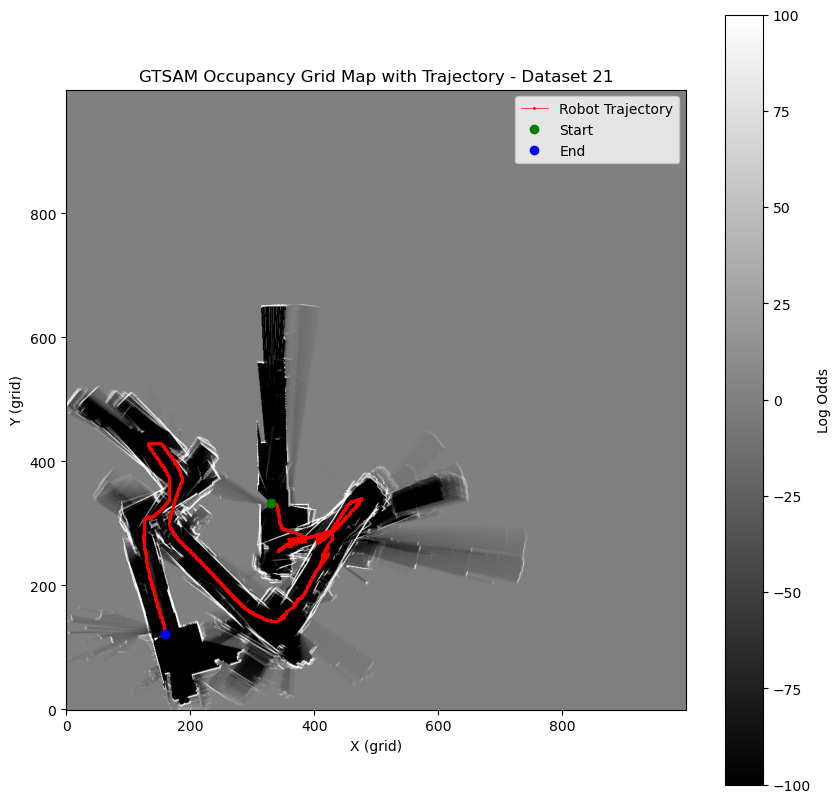

In [36]:
# Plotting with trajectory - T_opt

resolution = 0.05  # 5 cm per grid cell (meters per grid unit)
scale_factor = 1 / resolution  # Convert meters to grid units
grid_size = 1000  #Define a large fixed occupancy grid

occupancy_grid_opt = np.zeros((grid_size, grid_size), dtype=np.float32)
grid_center_x = grid_size // 3
grid_center_y = grid_size // 3

l_occupied = + 4
l_free = -0.5
l_max = 100
l_min = -100

positions_world_opt = []
robot_origin = np.array([0, 0, 1])  # Start in world coordinates (meters)

for i in range(e_time.shape[0]):
    print(f"Iteration: {i}")

    curr_origin = np.dot(T_icp[:, :, i], robot_origin)
    positions_world_opt.append(curr_origin[:2])

    robot_x_grid = np.round(curr_origin[0] * scale_factor + grid_center_x).astype(int)
    robot_y_grid = np.round(curr_origin[1] * scale_factor + grid_center_y).astype(int)

    print(f"Iteration {i}: World Position: {curr_origin[:2]} -> Grid Position: ({robot_x_grid}, {robot_y_grid})")

    ff = pc_sync[:, :, i]
    valid_mask = np.isfinite(ff).all(axis=0)  # Eliminate nan
    ff = ff[:, valid_mask]

    ff_homo = np.vstack((ff, np.ones(ff.shape[1])))
    ff_trans = T_icp[:, :, i] @ ff_homo  

    ff_trans = np.where(np.isfinite(ff_trans), ff_trans, np.nan)
    ff_trans = ff_trans[:, ~np.isnan(ff_trans).any(axis=0)]

    x_world = ff_trans[0, :]
    y_world = ff_trans[1, :]

    x_grid = np.round(x_world * scale_factor + grid_center_x).astype(int)
    y_grid = np.round(y_world * scale_factor + grid_center_y).astype(int)

    valid_mask = (x_grid >= 0) & (x_grid < grid_size) & (y_grid >= 0) & (y_grid < grid_size)
    x_valid = x_grid[valid_mask]
    y_valid = y_grid[valid_mask]

    occupancy_grid_opt[y_valid, x_valid] = np.clip(occupancy_grid_opt[y_valid, x_valid] + l_occupied, l_min, l_max)

    free_x_list = []
    free_y_list = []

    for x_end, y_end in zip(x_valid, y_valid):
        free_cells = np.array(bresenham(robot_x_grid, robot_y_grid, x_end, y_end))[:-1]  # Exclude last occupied cell
        free_x_list.append(free_cells[:, 0])
        free_y_list.append(free_cells[:, 1])

    if free_x_list:
        free_x = np.concatenate(free_x_list)
        free_y = np.concatenate(free_y_list)

        valid_free_mask = (free_x >= 0) & (free_x < grid_size) & (free_y >= 0) & (free_y < grid_size)
        free_x = free_x[valid_free_mask]
        free_y = free_y[valid_free_mask]

        occupancy_grid_opt[free_y, free_x] = np.clip(occupancy_grid_opt[free_y, free_x] + l_free, l_min, l_max)

positions_world_opt = np.array(positions_world_opt)  # Convert to NumPy array
trajectory_x = np.round(positions_world_opt[:, 0] * scale_factor + grid_center_x).astype(int)
trajectory_y = np.round(positions_world_opt[:, 1] * scale_factor + grid_center_y).astype(int)

plt.figure(figsize=(10, 10))
plt.imshow(occupancy_grid_opt, cmap="gray", origin="lower")
plt.colorbar(label="Log Odds")

plt.plot(trajectory_x, trajectory_y, 'ro-', markersize=1, linewidth=.5, label="Robot Trajectory")
plt.plot(trajectory_x[0], trajectory_y[0], 'go', markersize=6, label="Start")  # Start position (Green)
plt.plot(trajectory_x[-1], trajectory_y[-1], 'bo', markersize=6, label="End")  # End position (Blue)

plt.xlabel("X (grid)")
plt.ylabel("Y (grid)")
plt.title("GTSAM Occupancy Grid Map with Trajectory - Dataset " + str(dataset))
plt.legend()
plt.show()


Processing RGB frame 0 at time 0.0
Processing RGB frame 1 at time 0.03302001953125
Processing RGB frame 2 at time 0.06698822975158691
Processing RGB frame 3 at time 0.09997105598449707
Processing RGB frame 4 at time 0.13301610946655273
Processing RGB frame 5 at time 0.16703319549560547
Processing RGB frame 6 at time 0.20002317428588867
Processing RGB frame 7 at time 0.23376822471618652
Processing RGB frame 8 at time 0.2670011520385742
Processing RGB frame 9 at time 0.4670600891113281
Processing RGB frame 10 at time 0.6330142021179199
Processing RGB frame 11 at time 0.66703200340271
Processing RGB frame 12 at time 0.7000100612640381
Processing RGB frame 13 at time 0.7329962253570557
Processing RGB frame 14 at time 0.7670462131500244
Processing RGB frame 15 at time 0.8000130653381348
Processing RGB frame 16 at time 0.8330550193786621
Processing RGB frame 17 at time 0.8670351505279541
Processing RGB frame 18 at time 0.9000182151794434
Processing RGB frame 19 at time 0.9330201148986816
Pro

Processing RGB frame 162 at time 8.168039083480835
Processing RGB frame 163 at time 8.201004028320312
Processing RGB frame 164 at time 8.235050201416016
Processing RGB frame 165 at time 8.268049001693726
Processing RGB frame 166 at time 8.302017211914062
Processing RGB frame 167 at time 8.501965999603271
Processing RGB frame 168 at time 8.535011053085327
Processing RGB frame 169 at time 8.567986011505127
Processing RGB frame 170 at time 8.601973056793213
Processing RGB frame 171 at time 8.635048151016235
Processing RGB frame 172 at time 8.668002128601074
Processing RGB frame 173 at time 8.702027082443237
Processing RGB frame 174 at time 8.735068082809448
Processing RGB frame 175 at time 8.768005132675171
Processing RGB frame 176 at time 8.96795105934143
Processing RGB frame 177 at time 9.00199818611145
Processing RGB frame 178 at time 9.035047054290771
Processing RGB frame 179 at time 9.068004131317139
Processing RGB frame 180 at time 9.103072166442871
Processing RGB frame 181 at time 

Processing RGB frame 321 at time 16.303766012191772
Processing RGB frame 322 at time 16.336002111434937
Processing RGB frame 323 at time 16.5369930267334
Processing RGB frame 324 at time 16.570046186447144
Processing RGB frame 325 at time 16.603065013885498
Processing RGB frame 326 at time 16.636994123458862
Processing RGB frame 327 at time 16.670040130615234
Processing RGB frame 328 at time 16.70305609703064
Processing RGB frame 329 at time 16.73699402809143
Processing RGB frame 330 at time 16.770312070846558
Processing RGB frame 331 at time 16.80329203605652
Processing RGB frame 332 at time 17.003071069717407
Processing RGB frame 333 at time 17.037042140960693
Processing RGB frame 334 at time 17.070005178451538
Processing RGB frame 335 at time 17.102989196777344
Processing RGB frame 336 at time 17.137092113494873
Processing RGB frame 337 at time 17.169990062713623
Processing RGB frame 338 at time 17.203045129776
Processing RGB frame 339 at time 17.237048149108887
Processing RGB frame

Processing RGB frame 480 at time 24.739009141921997
Processing RGB frame 481 at time 24.772244215011597
Processing RGB frame 482 at time 24.972973108291626
Processing RGB frame 483 at time 25.006010055541992
Processing RGB frame 484 at time 25.03901720046997
Processing RGB frame 485 at time 25.0742290019989
Processing RGB frame 486 at time 25.10600709915161
Processing RGB frame 487 at time 25.138496160507202
Processing RGB frame 488 at time 25.172003030776978
Processing RGB frame 489 at time 25.205016136169434
Processing RGB frame 490 at time 25.404973030090332
Processing RGB frame 491 at time 25.438045024871826
Processing RGB frame 492 at time 25.47404718399048
Processing RGB frame 493 at time 25.504991054534912
Processing RGB frame 494 at time 25.538039207458496
Processing RGB frame 495 at time 25.57216715812683
Processing RGB frame 496 at time 25.60495114326477
Processing RGB frame 497 at time 25.638060092926025
Processing RGB frame 498 at time 25.672012090682983
Processing RGB fram

Processing RGB frame 640 at time 33.206998109817505
Processing RGB frame 641 at time 33.23999309539795
Processing RGB frame 642 at time 33.273030042648315
Processing RGB frame 643 at time 33.30698800086975
Processing RGB frame 644 at time 33.33996319770813
Processing RGB frame 645 at time 33.37305212020874
Processing RGB frame 646 at time 33.40699815750122
Processing RGB frame 647 at time 33.607030153274536
Processing RGB frame 648 at time 33.64001703262329
Processing RGB frame 649 at time 33.67413401603699
Processing RGB frame 650 at time 33.706969022750854
Processing RGB frame 651 at time 33.73999905586243
Processing RGB frame 652 at time 33.773488998413086
Processing RGB frame 653 at time 33.807011127471924
Processing RGB frame 654 at time 33.8400821685791
Processing RGB frame 655 at time 33.873064041137695
Processing RGB frame 656 at time 34.07307410240173
Processing RGB frame 657 at time 34.10704517364502
Processing RGB frame 658 at time 34.14006304740906
Processing RGB frame 659 

Processing RGB frame 800 at time 41.74420404434204
Processing RGB frame 801 at time 41.94406819343567
Processing RGB frame 802 at time 41.976065158843994
Processing RGB frame 803 at time 42.00812005996704
Processing RGB frame 804 at time 42.04381012916565
Processing RGB frame 805 at time 42.07583713531494
Processing RGB frame 806 at time 42.10796022415161
Processing RGB frame 807 at time 42.160258054733276
Processing RGB frame 808 at time 42.20828914642334
Processing RGB frame 809 at time 42.24289011955261
Processing RGB frame 810 at time 42.275116205215454
Processing RGB frame 811 at time 42.31963920593262
Processing RGB frame 812 at time 42.41142702102661
Processing RGB frame 813 at time 42.44378304481506
Processing RGB frame 814 at time 42.47575902938843
Processing RGB frame 815 at time 42.50817322731018
Processing RGB frame 816 at time 42.54389500617981
Processing RGB frame 817 at time 42.77585816383362
Processing RGB frame 818 at time 42.81178021430969
Processing RGB frame 819 at 

Processing RGB frame 960 at time 50.01587700843811
Processing RGB frame 961 at time 50.07977604866028
Processing RGB frame 962 at time 50.11037802696228
Processing RGB frame 963 at time 50.14366912841797
Processing RGB frame 964 at time 50.34311509132385
Processing RGB frame 965 at time 50.37703013420105
Processing RGB frame 966 at time 50.4162220954895
Processing RGB frame 967 at time 50.480334997177124
Processing RGB frame 968 at time 50.51176619529724
Processing RGB frame 969 at time 50.54406499862671
Processing RGB frame 970 at time 50.576993227005005
Processing RGB frame 971 at time 50.61003613471985
Processing RGB frame 972 at time 50.81001901626587
Processing RGB frame 973 at time 50.84308218955994
Processing RGB frame 974 at time 50.878310203552246
Processing RGB frame 975 at time 50.91184115409851
Processing RGB frame 976 at time 50.94749307632446
Processing RGB frame 977 at time 50.979769229888916
Processing RGB frame 978 at time 51.01125621795654
Processing RGB frame 979 at 

Processing RGB frame 1118 at time 58.745487213134766
Processing RGB frame 1119 at time 58.781304121017456
Processing RGB frame 1120 at time 58.81282114982605
Processing RGB frame 1121 at time 58.84560203552246
Processing RGB frame 1122 at time 58.88148903846741
Processing RGB frame 1123 at time 59.08131003379822
Processing RGB frame 1124 at time 59.11288619041443
Processing RGB frame 1125 at time 59.145724058151245
Processing RGB frame 1126 at time 59.18140912055969
Processing RGB frame 1127 at time 59.21281909942627
Processing RGB frame 1128 at time 59.24945306777954
Processing RGB frame 1129 at time 59.31285619735718
Processing RGB frame 1130 at time 59.349332094192505
Processing RGB frame 1131 at time 59.41280508041382
Processing RGB frame 1132 at time 59.44543123245239
Processing RGB frame 1133 at time 59.47926712036133
Processing RGB frame 1134 at time 59.6812961101532
Processing RGB frame 1135 at time 59.71280002593994
Processing RGB frame 1136 at time 59.74758005142212
Processin

Processing RGB frame 1276 at time 67.4160361289978
Processing RGB frame 1277 at time 67.44781804084778
Processing RGB frame 1278 at time 67.64793300628662
Processing RGB frame 1279 at time 67.68009805679321
Processing RGB frame 1280 at time 67.71605110168457
Processing RGB frame 1281 at time 67.74798822402954
Processing RGB frame 1282 at time 67.78003120422363
Processing RGB frame 1283 at time 67.81619215011597
Processing RGB frame 1284 at time 67.84782218933105
Processing RGB frame 1285 at time 67.87999701499939
Processing RGB frame 1286 at time 68.08194613456726
Processing RGB frame 1287 at time 68.11607623100281
Processing RGB frame 1288 at time 68.147794008255
Processing RGB frame 1289 at time 68.18003821372986
Processing RGB frame 1290 at time 68.21611309051514
Processing RGB frame 1291 at time 68.2478621006012
Processing RGB frame 1292 at time 68.28009414672852
Processing RGB frame 1293 at time 68.31607508659363
Processing RGB frame 1294 at time 68.51603317260742
Processing RGB f

Processing RGB frame 1435 at time 76.18365812301636
Processing RGB frame 1436 at time 76.2158751487732
Processing RGB frame 1437 at time 76.25169205665588
Processing RGB frame 1438 at time 76.28373122215271
Processing RGB frame 1439 at time 76.31579613685608
Processing RGB frame 1440 at time 76.5157961845398
Processing RGB frame 1441 at time 76.55173301696777
Processing RGB frame 1442 at time 76.5837140083313
Processing RGB frame 1443 at time 76.61572408676147
Processing RGB frame 1444 at time 76.65173316001892
Processing RGB frame 1445 at time 76.68372201919556
Processing RGB frame 1446 at time 76.71585011482239
Processing RGB frame 1447 at time 76.91603922843933
Processing RGB frame 1448 at time 76.95176100730896
Processing RGB frame 1449 at time 76.98369407653809
Processing RGB frame 1450 at time 77.01579999923706
Processing RGB frame 1451 at time 77.05173015594482
Processing RGB frame 1452 at time 77.08376121520996
Processing RGB frame 1453 at time 77.1158390045166
Processing RGB f

Processing RGB frame 1595 at time 85.15179109573364
Processing RGB frame 1596 at time 85.18775820732117
Processing RGB frame 1597 at time 85.21997308731079
Processing RGB frame 1598 at time 85.25178813934326
Processing RGB frame 1599 at time 85.2839720249176
Processing RGB frame 1600 at time 85.31992316246033
Processing RGB frame 1601 at time 85.35196900367737
Processing RGB frame 1602 at time 85.38547611236572
Processing RGB frame 1603 at time 85.58771514892578
Processing RGB frame 1604 at time 85.61996102333069
Processing RGB frame 1605 at time 85.65198707580566
Processing RGB frame 1606 at time 85.68772006034851
Processing RGB frame 1607 at time 85.71971917152405
Processing RGB frame 1608 at time 85.75198602676392
Processing RGB frame 1609 at time 85.7852840423584
Processing RGB frame 1610 at time 85.98771119117737
Processing RGB frame 1611 at time 86.01976418495178
Processing RGB frame 1612 at time 86.05195903778076
Processing RGB frame 1613 at time 86.0877251625061
Processing RGB 

Processing RGB frame 1753 at time 93.81900405883789
Processing RGB frame 1754 at time 93.85206723213196
Processing RGB frame 1755 at time 93.88598322868347
Processing RGB frame 1756 at time 93.91901302337646
Processing RGB frame 1757 at time 93.95202803611755
Processing RGB frame 1758 at time 93.98600101470947
Processing RGB frame 1759 at time 94.18596005439758
Processing RGB frame 1760 at time 94.21904611587524
Processing RGB frame 1761 at time 94.25198101997375
Processing RGB frame 1762 at time 94.28594708442688
Processing RGB frame 1763 at time 94.31905102729797
Processing RGB frame 1764 at time 94.3519880771637
Processing RGB frame 1765 at time 94.38621306419373
Processing RGB frame 1766 at time 94.4190571308136
Processing RGB frame 1767 at time 94.45202922821045
Processing RGB frame 1768 at time 94.65208601951599
Processing RGB frame 1769 at time 94.68602418899536
Processing RGB frame 1770 at time 94.71902203559875
Processing RGB frame 1771 at time 94.751962184906
Processing RGB f

Processing RGB frame 1911 at time 102.08695006370544
Processing RGB frame 1912 at time 102.12104105949402
Processing RGB frame 1913 at time 102.15403413772583
Processing RGB frame 1914 at time 102.32213521003723
Processing RGB frame 1915 at time 102.35404014587402
Processing RGB frame 1916 at time 102.38698601722717
Processing RGB frame 1917 at time 102.42102408409119
Processing RGB frame 1918 at time 102.45401310920715
Processing RGB frame 1919 at time 102.48698711395264
Processing RGB frame 1920 at time 102.52104902267456
Processing RGB frame 1921 at time 102.5540201663971
Processing RGB frame 1922 at time 102.75404000282288
Processing RGB frame 1923 at time 102.78704905509949
Processing RGB frame 1924 at time 102.82098722457886
Processing RGB frame 1925 at time 102.85401821136475
Processing RGB frame 1926 at time 102.88705515861511
Processing RGB frame 1927 at time 102.92103600502014
Processing RGB frame 1928 at time 102.95395517349243
Processing RGB frame 1929 at time 102.987052202

Processing RGB frame 2066 at time 110.18901205062866
Processing RGB frame 2067 at time 110.38905215263367
Processing RGB frame 2068 at time 110.42202019691467
Processing RGB frame 2069 at time 110.45599603652954
Processing RGB frame 2070 at time 110.48898005485535
Processing RGB frame 2071 at time 110.5230941772461
Processing RGB frame 2072 at time 110.55603218078613
Processing RGB frame 2073 at time 110.58902716636658
Processing RGB frame 2074 at time 110.62223720550537
Processing RGB frame 2075 at time 110.6560161113739
Processing RGB frame 2076 at time 110.85605120658875
Processing RGB frame 2077 at time 110.88940811157227
Processing RGB frame 2078 at time 110.92197823524475
Processing RGB frame 2079 at time 110.95595216751099
Processing RGB frame 2080 at time 110.98913812637329
Processing RGB frame 2081 at time 111.02200317382812
Processing RGB frame 2082 at time 111.05597805976868
Processing RGB frame 2083 at time 111.08906507492065
Processing RGB frame 2084 at time 111.1220481395

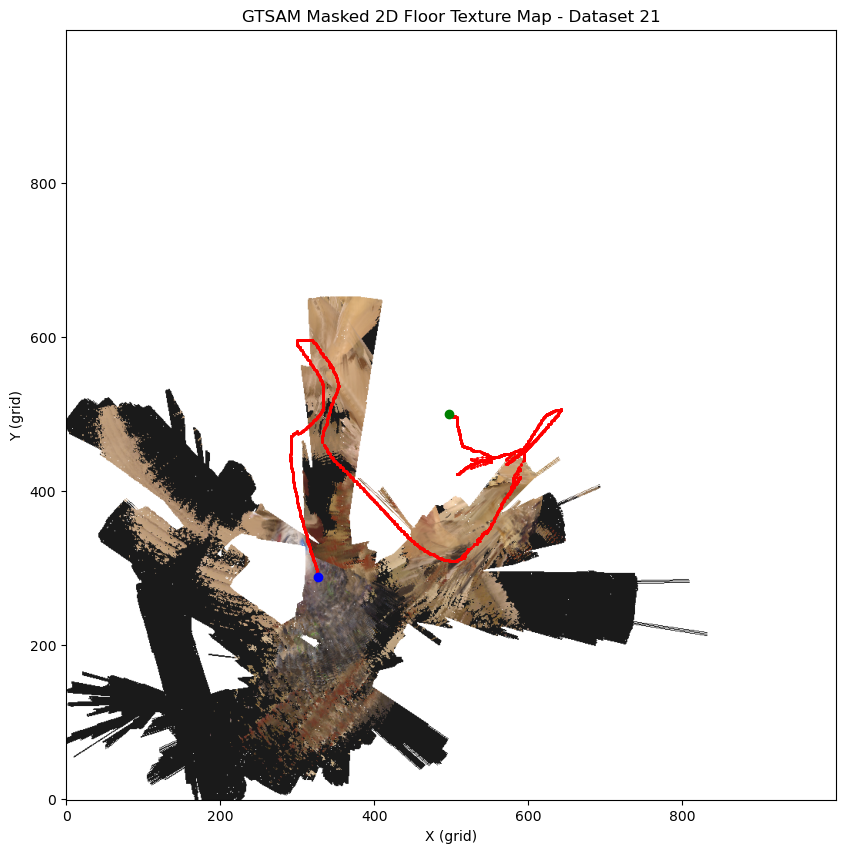

In [38]:
# GTSAM Texture Map
rgb_time = rgb_stamps-rgb_stamps[0]
disp_time = disp_stamps-disp_stamps[0]

grid_size = 1000  
resolution = 0.05  
scale_factor = 1 / resolution  
grid_center_x = grid_size // 2
grid_center_y = grid_size // 2

texture_grid = np.zeros((grid_size, grid_size, 3), dtype=np.float32)  
texture_count = np.zeros((grid_size, grid_size), dtype=np.int32)  

K = np.array([[585.05, 0, 242.94],
              [0, 585.05, 315.84],
              [0, 0, 1]])

roll, pitch, yaw = 0, .48, 0.021  

R_x = np.array([[1, 0, 0],
                [0, np.cos(roll), -np.sin(roll)],
                [0, np.sin(roll), np.cos(roll)]])

R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                [0, 1, 0],
                [-np.sin(pitch), 0, np.cos(pitch)]])

R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                [np.sin(yaw), np.cos(yaw), 0],
                [0, 0, 1]])

bRk = R_z @ R_y @ R_x  
oRr = np.array([[0, -1, 0], [0, 0, -1], [1, 0, 0]])  

kinect_position = np.array([[.18], [.005], [.36]])  

for rgb_idx, rgb_t in enumerate(rgb_time):
    print(f"Processing RGB frame {rgb_idx} at time {rgb_t}")

    disp_idx = find_nearest_time(rgb_t, disp_time)
    pose_idx = find_nearest_time(rgb_t, e_time)

    disp_path = f"../data/dataRGBD/Disparity20/disparity20_{disp_idx+1}.png"
    disp_img = cv.imread(disp_path, cv.IMREAD_UNCHANGED)
    if disp_img is None:
        print(f"Warning: Disparity image at index {disp_idx} not found!")
        continue

    wTb_3x3 = T_opt[:, :, pose_idx]  
    wTb_4x4 = convert_pose_3x3_to_4x4(wTb_3x3)

    rgb_path = f"../data/dataRGBD/RGB20/rgb20_{rgb_idx+1}.png"
    rgb_img = cv.imread(rgb_path)
    if rgb_img is None:
        print(f"Warning: RGB image at index {rgb_idx} not found!")
        continue
    rgb_img = cv.cvtColor(rgb_img, cv.COLOR_BGR2RGB)

    height, width = disp_img.shape
    dd = -0.00304 * disp_img + 3.31
    depth = 1.03 / dd

    j_idxs, i_idxs = np.meshgrid(np.arange(width), np.arange(height), indexing='xy')
    i_flat, j_flat = i_idxs.flatten(), j_idxs.flatten()
    
    rgb_i = np.clip(((526.37 * i_flat + 19276 - 7877.07 * dd.flatten()) / 585.051).astype(np.int32), 0, height - 1)
    rgb_j = np.clip(((526.37 * j_flat + 16662) / 585.051).astype(np.int32), 0, width - 1)

    colors = rgb_img[rgb_i, rgb_j]  

    uv1 = np.vstack([j_flat, i_flat, np.ones_like(i_flat)])
    points_camera = depth.flatten() * (np.linalg.inv(K) @ uv1)

    points_robot = (bRk @ oRr.T @ points_camera) + kinect_position
    points_homogeneous = np.vstack((points_robot, np.ones((1, points_robot.shape[1]))))
    points_world_homogeneous = wTb_4x4 @ points_homogeneous
    points_world = points_world_homogeneous[:3, :]

    x_grid = np.round(points_world[0, :] * scale_factor + grid_center_x).astype(np.int32)
    y_grid = np.round(points_world[1, :] * scale_factor + grid_center_y).astype(np.int32)

    valid_mask = (x_grid >= 0) & (x_grid < grid_size) & (y_grid >= 0) & (y_grid < grid_size)
    x_valid, y_valid = x_grid[valid_mask], y_grid[valid_mask]
    colors_valid = colors[valid_mask]

    np.add.at(texture_grid, (y_valid, x_valid), colors_valid)
    np.add.at(texture_count, (y_valid, x_valid), 1)

valid_mask = texture_count > 0  
texture_grid[valid_mask] /= texture_count[valid_mask][:, np.newaxis]  
texture_grid_display = np.clip(texture_grid, 0, 255).astype(np.uint8)  

masked_texture_grid = texture_grid_display.copy()
masked_texture_grid[occupancy_grid_opt == 0] = [255, 255, 255]  # Set masked areas to white

trajectory_x = np.round(positions_world_opt[:, 0] * scale_factor + grid_center_x).astype(int)
trajectory_y = np.round(positions_world_opt[:, 1] * scale_factor + grid_center_y).astype(int)

plt.figure(figsize=(10, 10))
plt.imshow(masked_texture_grid, origin="lower", alpha=0.9)  

plt.plot(trajectory_x, trajectory_y, 'ro-', markersize=1, linewidth=.5, label="Robot Trajectory")
plt.plot(trajectory_x[0], trajectory_y[0], 'go', markersize=6, label="Start")  # Start position (Green)
plt.plot(trajectory_x[-1], trajectory_y[-1], 'bo', markersize=6, label="End")  # End position (Blue)

plt.xlabel("X (grid)")
plt.ylabel("Y (grid)")
plt.title("GTSAM Masked 2D Floor Texture Map - Dataset " + str(dataset))
plt.show()
